# IMPORT LIBRARIES

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from keras.models import load_model
from tensorflow.keras.losses import Huber

In [16]:
df = pd.read_csv("SolarRadiationDataNewDelhicsv.csv")
df

name             datetime  temp  feelslike   dew  humidity  \
0      New Delhi  2023-01-01T00:00:00  11.0       11.0  10.0     93.55   
1      New Delhi  2023-01-01T01:00:00  10.0        9.6   9.0     93.50   
2      New Delhi  2023-01-01T02:00:00   8.6        8.6   7.6     93.83   
3      New Delhi  2023-01-01T03:00:00  10.0       10.0   9.0     93.50   
4      New Delhi  2023-01-01T04:00:00   9.0        8.5   9.0    100.00   
...          ...                  ...   ...        ...   ...       ...   
10483  new delhi  2024-03-12T19:00:00  25.0       25.0  12.0     44.28   
10484  new delhi  2024-03-12T20:00:00  22.8       22.8  13.9     57.44   
10485  new delhi  2024-03-12T21:00:00  23.0       23.0  14.0     56.90   
10486  new delhi  2024-03-12T22:00:00  23.0       23.0  13.0     53.32   
10487  new delhi  2024-03-12T23:00:00  20.6       20.6  14.7     68.71   

       precip  precipprob preciptype  snow  ...  sealevelpressure  cloudcover  \
0         0.0           0        NaN     0  ...            1020.0         0.0   
1         0.0           0        NaN     0  ...            1020.0         0.0   
2         0.0           0        NaN     0  ...            1019.5         5.0   
3         0.0           0        NaN     0  ...            1019.0         0.0   
4         0.0           0        NaN     0  ...            1019.0         0.0   
...       ...         ...        ...   ...  ...               ...         ...   
10483     0.0           0        NaN     0  ...            1014.0         0.0   
10484     0.0           0        NaN     0  ...            1013.1         0.0   
10485     0.0           0        NaN     0  ...            1015.0         0.0   
10486     0.0           0        NaN     0  ...            1015.0         0.0   
10487     0.0           0        NaN     0  ...            1013.5         0.0   

       visibility  solarradiation  solarenergy  uvindex  severerisk  \
0             2.0               0          0.0        0          10   
1             2.0               0          0.0        0          10   
2             1.2               0          0.0        0          10   
3             2.0               0          0.0        0          10   
4             1.0               0          0.0        0          10   
...           ...             ...          ...      ...         ...   
10483         4.0              41          0.1        0          10   
10484         2.3               0          0.0        0          10   
10485         4.0               0          0.0        0          10   
10486         4.0               0          0.0        0          10   
10487         2.3               0          0.0        0          10   

       conditions         icon                      stations  
0           Clear  clear-night              VIDP,42181099999  
1           Clear  clear-night              VIDP,42181099999  
2           Clear  clear-night  42182099999,VIDP,42181099999  
3           Clear  clear-night              VIDP,42181099999  
4           Clear  clear-night              VIDP,42181099999  
...           ...          ...                           ...  
10483       Clear  clear-night              VIDP,42181099999  
10484       Clear  clear-night  42182099999,VIDP,42181099999  
10485       Clear  clear-night              VIDP,42181099999  
10486       Clear  clear-night              VIDP,42181099999  
10487       Clear  clear-night  42182099999,VIDP,42181099999  

[10488 rows x 24 columns]

In [17]:
columns_to_drop = ['conditions','icon', 'stations','uvindex', 'severerisk','precip',
       'precipprob', 'preciptype', 'snow','temp', 'feelslike', 'snowdepth','humidity','name']
df.drop(columns=columns_to_drop, inplace=True)

df.insert(0, 'Datetime', pd.Series([float('nan')] * len(df)))

df['Datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S')

df['Datetime'].dt.strftime('%d-%m-%Y %H--00-00')

df.index = pd.to_datetime(df['Datetime'])

In [22]:
df = df[~((df['Datetime'].dt.hour >= 0) & (df['Datetime'].dt.hour <= 8) |
                  (df['Datetime'].dt.hour >= 19) & (df['Datetime'].dt.hour < 24))]

In [23]:
df

Datetime             datetime   dew  windgust  \
Datetime                                                                       
2023-01-01 09:00:00 2023-01-01 09:00:00  2023-01-01T09:00:00  10.0       4.3   
2023-01-01 10:00:00 2023-01-01 10:00:00  2023-01-01T10:00:00  10.0       1.8   
2023-01-01 11:00:00 2023-01-01 11:00:00  2023-01-01T11:00:00  10.7       2.2   
2023-01-01 12:00:00 2023-01-01 12:00:00  2023-01-01T12:00:00  11.0       3.2   
2023-01-01 13:00:00 2023-01-01 13:00:00  2023-01-01T13:00:00  12.0       2.9   
...                                 ...                  ...   ...       ...   
2024-03-12 14:00:00 2024-03-12 14:00:00  2024-03-12T14:00:00  10.6      17.6   
2024-03-12 15:00:00 2024-03-12 15:00:00  2024-03-12T15:00:00   6.0      18.4   
2024-03-12 16:00:00 2024-03-12 16:00:00  2024-03-12T16:00:00   6.0      18.7   
2024-03-12 17:00:00 2024-03-12 17:00:00  2024-03-12T17:00:00  10.4      18.0   
2024-03-12 18:00:00 2024-03-12 18:00:00  2024-03-12T18:00:00   9.0      18.0   

                     windspeed  winddir  sealevelpressure  cloudcover  \
Datetime                                                                
2023-01-01 09:00:00        5.4    250.0            1022.0         0.0   
2023-01-01 10:00:00        9.4    250.0            1023.0         0.0   
2023-01-01 11:00:00        8.0    250.0            1022.5         0.0   
2023-01-01 12:00:00        7.6    270.0            1022.0         0.0   
2023-01-01 13:00:00        5.4    270.0            1021.0         0.0   
...                        ...      ...               ...         ...   
2024-03-12 14:00:00        8.5    298.0            1012.9         0.0   
2024-03-12 15:00:00       13.0    300.0            1014.0         0.0   
2024-03-12 16:00:00       13.0    300.0            1013.0         0.0   
2024-03-12 17:00:00        6.1    282.0            1012.0         0.0   
2024-03-12 18:00:00       11.2    300.0            1013.0         0.0   

                     visibility  solarradiation  solarenergy  
Datetime                                                      
2023-01-01 09:00:00         1.0              73          0.3  
2023-01-01 10:00:00         2.0             209          0.8  
2023-01-01 11:00:00         1.9             409          1.5  
2023-01-01 12:00:00         2.0             529          1.9  
2023-01-01 13:00:00         2.0             589          2.1  
...                         ...             ...          ...  
2024-03-12 14:00:00         4.1             837          3.0  
2024-03-12 15:00:00         5.0             767          2.8  
2024-03-12 16:00:00         5.0             630          2.3  
2024-03-12 17:00:00         4.1             441          1.6  
2024-03-12 18:00:00         4.0             226          0.8  

[4370 rows x 11 columns]

In [24]:
df.drop(columns = ['datetime', 'Datetime'], inplace = True)

/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_19857/2306889241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = ['datetime', 'Datetime'], inplace = True)


In [25]:
df

dew  windgust  windspeed  winddir  sealevelpressure  \
Datetime                                                                    
2023-01-01 09:00:00  10.0       4.3        5.4    250.0            1022.0   
2023-01-01 10:00:00  10.0       1.8        9.4    250.0            1023.0   
2023-01-01 11:00:00  10.7       2.2        8.0    250.0            1022.5   
2023-01-01 12:00:00  11.0       3.2        7.6    270.0            1022.0   
2023-01-01 13:00:00  12.0       2.9        5.4    270.0            1021.0   
...                   ...       ...        ...      ...               ...   
2024-03-12 14:00:00  10.6      17.6        8.5    298.0            1012.9   
2024-03-12 15:00:00   6.0      18.4       13.0    300.0            1014.0   
2024-03-12 16:00:00   6.0      18.7       13.0    300.0            1013.0   
2024-03-12 17:00:00  10.4      18.0        6.1    282.0            1012.0   
2024-03-12 18:00:00   9.0      18.0       11.2    300.0            1013.0   

                     cloudcover  visibility  solarradiation  solarenergy  
Datetime                                                                  
2023-01-01 09:00:00         0.0         1.0              73          0.3  
2023-01-01 10:00:00         0.0         2.0             209          0.8  
2023-01-01 11:00:00         0.0         1.9             409          1.5  
2023-01-01 12:00:00         0.0         2.0             529          1.9  
2023-01-01 13:00:00         0.0         2.0             589          2.1  
...                         ...         ...             ...          ...  
2024-03-12 14:00:00         0.0         4.1             837          3.0  
2024-03-12 15:00:00         0.0         5.0             767          2.8  
2024-03-12 16:00:00         0.0         5.0             630          2.3  
2024-03-12 17:00:00         0.0         4.1             441          1.6  
2024-03-12 18:00:00         0.0         4.0             226          0.8  

[4370 rows x 9 columns]

In [26]:
df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
df

/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_19857/3527561163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Seconds'] = df.index.map(pd.Timestamp.timestamp)


dew  windgust  windspeed  winddir  sealevelpressure  \
Datetime                                                                    
2023-01-01 09:00:00  10.0       4.3        5.4    250.0            1022.0   
2023-01-01 10:00:00  10.0       1.8        9.4    250.0            1023.0   
2023-01-01 11:00:00  10.7       2.2        8.0    250.0            1022.5   
2023-01-01 12:00:00  11.0       3.2        7.6    270.0            1022.0   
2023-01-01 13:00:00  12.0       2.9        5.4    270.0            1021.0   
...                   ...       ...        ...      ...               ...   
2024-03-12 14:00:00  10.6      17.6        8.5    298.0            1012.9   
2024-03-12 15:00:00   6.0      18.4       13.0    300.0            1014.0   
2024-03-12 16:00:00   6.0      18.7       13.0    300.0            1013.0   
2024-03-12 17:00:00  10.4      18.0        6.1    282.0            1012.0   
2024-03-12 18:00:00   9.0      18.0       11.2    300.0            1013.0   

                     cloudcover  visibility  solarradiation  solarenergy  \
Datetime                                                                   
2023-01-01 09:00:00         0.0         1.0              73          0.3   
2023-01-01 10:00:00         0.0         2.0             209          0.8   
2023-01-01 11:00:00         0.0         1.9             409          1.5   
2023-01-01 12:00:00         0.0         2.0             529          1.9   
2023-01-01 13:00:00         0.0         2.0             589          2.1   
...                         ...         ...             ...          ...   
2024-03-12 14:00:00         0.0         4.1             837          3.0   
2024-03-12 15:00:00         0.0         5.0             767          2.8   
2024-03-12 16:00:00         0.0         5.0             630          2.3   
2024-03-12 17:00:00         0.0         4.1             441          1.6   
2024-03-12 18:00:00         0.0         4.0             226          0.8   

                          Seconds  
Datetime                           
2023-01-01 09:00:00  1.672564e+09  
2023-01-01 10:00:00  1.672567e+09  
2023-01-01 11:00:00  1.672571e+09  
2023-01-01 12:00:00  1.672574e+09  
2023-01-01 13:00:00  1.672578e+09  
...                           ...  
2024-03-12 14:00:00  1.710252e+09  
2024-03-12 15:00:00  1.710256e+09  
2024-03-12 16:00:00  1.710259e+09  
2024-03-12 17:00:00  1.710263e+09  
2024-03-12 18:00:00  1.710266e+09  

[4370 rows x 10 columns]

In [27]:
day = 60*60*24
month = 30*day

df['Day sin'] = np.sin(df['Seconds'] * (2* np.pi / day))
df['Day cos'] = np.cos(df['Seconds'] * (2 * np.pi / day))
df['Month sin'] = np.sin(df['Seconds'] * (2 * np.pi / month))
df['Month cos'] = np.cos(df['Seconds'] * (2 * np.pi / month))
df.head()

/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_19857/83241650.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day sin'] = np.sin(df['Seconds'] * (2* np.pi / day))
/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_19857/83241650.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day cos'] = np.cos(df['Seconds'] * (2 * np.pi / day))
/var/folders/8n/95vlvnl93lg2r18pnsrgf8f40000gn/T/ipykernel_19857/83241650.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of

dew  windgust  windspeed  winddir  sealevelpressure  \
Datetime                                                                    
2023-01-01 09:00:00  10.0       4.3        5.4    250.0            1022.0   
2023-01-01 10:00:00  10.0       1.8        9.4    250.0            1023.0   
2023-01-01 11:00:00  10.7       2.2        8.0    250.0            1022.5   
2023-01-01 12:00:00  11.0       3.2        7.6    270.0            1022.0   
2023-01-01 13:00:00  12.0       2.9        5.4    270.0            1021.0   

                     cloudcover  visibility  solarradiation  solarenergy  \
Datetime                                                                   
2023-01-01 09:00:00         0.0         1.0              73          0.3   
2023-01-01 10:00:00         0.0         2.0             209          0.8   
2023-01-01 11:00:00         0.0         1.9             409          1.5   
2023-01-01 12:00:00         0.0         2.0             529          1.9   
2023-01-01 13:00:00         0.0         2.0             589          2.1   

                          Seconds       Day sin   Day cos  Month sin  \
Datetime                                                               
2023-01-01 09:00:00  1.672564e+09  7.071068e-01 -0.707107   0.983255   
2023-01-01 10:00:00  1.672567e+09  5.000000e-01 -0.866025   0.981627   
2023-01-01 11:00:00  1.672571e+09  2.588190e-01 -0.965926   0.979925   
2023-01-01 12:00:00  1.672574e+09  1.867320e-12 -1.000000   0.978148   
2023-01-01 13:00:00  1.672578e+09 -2.588190e-01 -0.965926   0.976296   

                     Month cos  
Datetime                        
2023-01-01 09:00:00  -0.182236  
2023-01-01 10:00:00  -0.190809  
2023-01-01 11:00:00  -0.199368  
2023-01-01 12:00:00  -0.207912  
2023-01-01 13:00:00  -0.216440

In [28]:
df = df.drop('Seconds', axis=1)
df.head()

dew  windgust  windspeed  winddir  sealevelpressure  \
Datetime                                                                    
2023-01-01 09:00:00  10.0       4.3        5.4    250.0            1022.0   
2023-01-01 10:00:00  10.0       1.8        9.4    250.0            1023.0   
2023-01-01 11:00:00  10.7       2.2        8.0    250.0            1022.5   
2023-01-01 12:00:00  11.0       3.2        7.6    270.0            1022.0   
2023-01-01 13:00:00  12.0       2.9        5.4    270.0            1021.0   

                     cloudcover  visibility  solarradiation  solarenergy  \
Datetime                                                                   
2023-01-01 09:00:00         0.0         1.0              73          0.3   
2023-01-01 10:00:00         0.0         2.0             209          0.8   
2023-01-01 11:00:00         0.0         1.9             409          1.5   
2023-01-01 12:00:00         0.0         2.0             529          1.9   
2023-01-01 13:00:00         0.0         2.0             589          2.1   

                          Day sin   Day cos  Month sin  Month cos  
Datetime                                                           
2023-01-01 09:00:00  7.071068e-01 -0.707107   0.983255  -0.182236  
2023-01-01 10:00:00  5.000000e-01 -0.866025   0.981627  -0.190809  
2023-01-01 11:00:00  2.588190e-01 -0.965926   0.979925  -0.199368  
2023-01-01 12:00:00  1.867320e-12 -1.000000   0.978148  -0.207912  
2023-01-01 13:00:00 -2.588190e-01 -0.965926   0.976296  -0.216440

In [29]:
df[7:15]

dew  windgust  windspeed  winddir  sealevelpressure  \
Datetime                                                                    
2023-01-01 16:00:00   9.0       4.0        5.4    270.0            1020.0   
2023-01-01 17:00:00  10.5       5.8        2.6    269.0            1019.2   
2023-01-01 18:00:00   9.0       6.1        0.0      0.0            1020.0   
2023-01-02 09:00:00  10.0       1.1        0.0      0.0            1023.0   
2023-01-02 10:00:00  10.0       2.5        0.0      0.0            1023.0   
2023-01-02 11:00:00  10.5       1.1        0.0    353.9            1023.3   
2023-01-02 12:00:00  11.0       2.2        5.4    210.0            1022.0   
2023-01-02 13:00:00  11.0       3.6        9.4    240.0            1022.0   

                     cloudcover  visibility  solarradiation  solarenergy  \
Datetime                                                                   
2023-01-01 16:00:00        50.0         2.0             315          1.1   
2023-01-01 17:00:00        57.4         2.0             183          0.7   
2023-01-01 18:00:00        88.9         3.0              47          0.2   
2023-01-02 09:00:00         0.0         1.0              74          0.3   
2023-01-02 10:00:00         0.0         1.0             244          0.9   
2023-01-02 11:00:00         3.3         1.0             407          1.5   
2023-01-02 12:00:00         0.0         1.0             527          1.9   
2023-01-02 13:00:00         0.0         1.0             588          2.1   

                          Day sin       Day cos  Month sin  Month cos  
Datetime                                                               
2023-01-01 16:00:00 -8.660254e-01 -5.000000e-01   0.970296  -0.241922  
2023-01-01 17:00:00 -9.659258e-01 -2.588190e-01   0.968148  -0.250380  
2023-01-01 18:00:00 -1.000000e+00 -4.430664e-12   0.965926  -0.258819  
2023-01-02 09:00:00  7.071068e-01 -7.071068e-01   0.923880  -0.382683  
2023-01-02 10:00:00  5.000000e-01 -8.660254e-01   0.920505  -0.390731  
2023-01-02 11:00:00  2.588190e-01 -9.659258e-01   0.917060  -0.398749  
2023-01-02 12:00:00  1.212070e-11 -1.000000e+00   0.913545  -0.406737  
2023-01-02 13:00:00 -2.588190e-01 -9.659258e-01   0.909961  -0.414693

In [30]:
data = df

In [31]:
data.isna().sum()

dew                 0
windgust            0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
Day sin             0
Day cos             0
Month sin           0
Month cos           0
dtype: int64

In [32]:
data.columns

Index(['dew', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'Day sin',
       'Day cos', 'Month sin', 'Month cos'],
      dtype='object')

# OUTLINERS

Text(0.5, 1.0, 'Day cos')

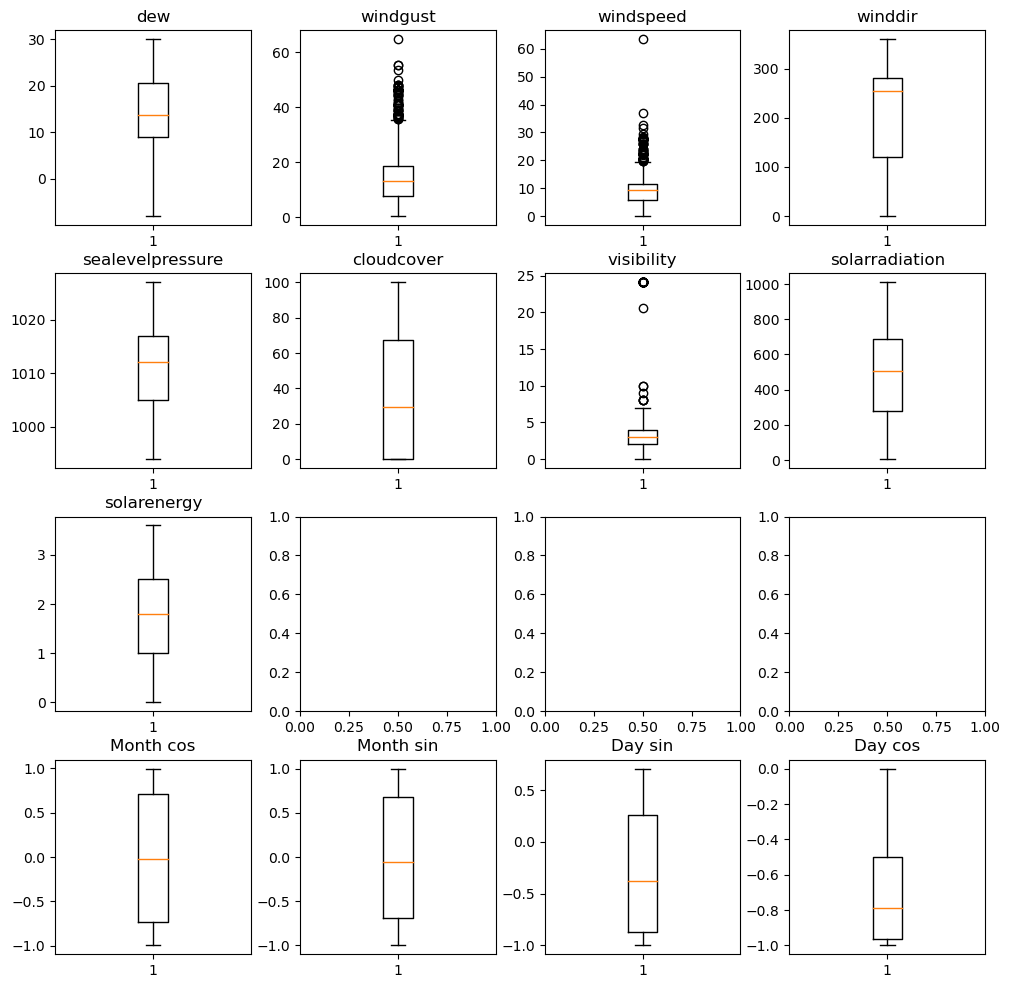

In [33]:
fig, ax = plt.subplots(4,4,figsize=(12,12))
fig.subplots_adjust(wspace=0.25, hspace=0.25)

ax[0][0].boxplot(data['dew'])
ax[0][0].set_title('dew')

ax[0][1].boxplot(data['windgust'])
ax[0][1].set_title('windgust')

ax[0][2].boxplot(data['windspeed'])
ax[0][2].set_title('windspeed')

ax[0][3].boxplot(data['winddir'])
ax[0][3].set_title('winddir')

ax[1][0].boxplot(data['sealevelpressure'])
ax[1][0].set_title('sealevelpressure')

ax[1][1].boxplot(data['cloudcover'])
ax[1][1].set_title('cloudcover')

ax[1][2].boxplot(data['visibility'])
ax[1][2].set_title('visibility')

ax[1][3].boxplot(data['solarradiation'])
ax[1][3].set_title('solarradiation')

ax[2][0].boxplot(data['solarenergy'])
ax[2][0].set_title('solarenergy')

ax[3][0].boxplot(data['Month cos'])
ax[3][0].set_title('Month cos')

ax[3][1].boxplot(data['Month sin'])
ax[3][1].set_title('Month sin')

ax[3][2].boxplot(data['Day sin'])
ax[3][2].set_title('Day sin')

ax[3][3].boxplot(data['Day cos'])
ax[3][3].set_title('Day cos')

In [34]:
data 

dew  windgust  windspeed  winddir  sealevelpressure  \
Datetime                                                                    
2023-01-01 09:00:00  10.0       4.3        5.4    250.0            1022.0   
2023-01-01 10:00:00  10.0       1.8        9.4    250.0            1023.0   
2023-01-01 11:00:00  10.7       2.2        8.0    250.0            1022.5   
2023-01-01 12:00:00  11.0       3.2        7.6    270.0            1022.0   
2023-01-01 13:00:00  12.0       2.9        5.4    270.0            1021.0   
...                   ...       ...        ...      ...               ...   
2024-03-12 14:00:00  10.6      17.6        8.5    298.0            1012.9   
2024-03-12 15:00:00   6.0      18.4       13.0    300.0            1014.0   
2024-03-12 16:00:00   6.0      18.7       13.0    300.0            1013.0   
2024-03-12 17:00:00  10.4      18.0        6.1    282.0            1012.0   
2024-03-12 18:00:00   9.0      18.0       11.2    300.0            1013.0   

                     cloudcover  visibility  solarradiation  solarenergy  \
Datetime                                                                   
2023-01-01 09:00:00         0.0         1.0              73          0.3   
2023-01-01 10:00:00         0.0         2.0             209          0.8   
2023-01-01 11:00:00         0.0         1.9             409          1.5   
2023-01-01 12:00:00         0.0         2.0             529          1.9   
2023-01-01 13:00:00         0.0         2.0             589          2.1   
...                         ...         ...             ...          ...   
2024-03-12 14:00:00         0.0         4.1             837          3.0   
2024-03-12 15:00:00         0.0         5.0             767          2.8   
2024-03-12 16:00:00         0.0         5.0             630          2.3   
2024-03-12 17:00:00         0.0         4.1             441          1.6   
2024-03-12 18:00:00         0.0         4.0             226          0.8   

                          Day sin       Day cos  Month sin  Month cos  
Datetime                                                               
2023-01-01 09:00:00  7.071068e-01 -7.071068e-01   0.983255  -0.182236  
2023-01-01 10:00:00  5.000000e-01 -8.660254e-01   0.981627  -0.190809  
2023-01-01 11:00:00  2.588190e-01 -9.659258e-01   0.979925  -0.199368  
2023-01-01 12:00:00  1.867320e-12 -1.000000e+00   0.978148  -0.207912  
2023-01-01 13:00:00 -2.588190e-01 -9.659258e-01   0.976296  -0.216440  
...                           ...           ...        ...        ...  
2024-03-12 14:00:00 -5.000000e-01 -8.660254e-01  -0.906308   0.422618  
2024-03-12 15:00:00 -7.071068e-01 -7.071068e-01  -0.902585   0.430511  
2024-03-12 16:00:00 -8.660254e-01 -5.000000e-01  -0.898794   0.438371  
2024-03-12 17:00:00 -9.659258e-01 -2.588190e-01  -0.894934   0.446198  
2024-03-12 18:00:00 -1.000000e+00 -7.464889e-12  -0.891007   0.453990  

[4370 rows x 13 columns]

In [35]:
import numpy as np

for i in data.columns:  
    
    dt = np.array(data[i], dtype=float)  
    Q1 = np.percentile(dt, 25)
    Q3 = np.percentile(dt, 75)
    IQ = Q3 - Q1
    upper = Q3 + 1.5 * IQ
    lower = Q1 - 1.5 * IQ

    dt[(dt > upper) | (dt < lower)] = np.nan
    data[i] = dt


In [36]:
data.isna().sum()

dew                   0
windgust            124
windspeed            62
winddir               0
sealevelpressure      0
cloudcover            0
visibility           39
solarradiation        0
solarenergy           0
Day sin               0
Day cos               0
Month sin             0
Month cos             0
dtype: int64

In [37]:
data=data.interpolate(method='linear', axis=0)
data.isna().sum()

dew                 0
windgust            0
windspeed           0
winddir             0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
solarenergy         0
Day sin             0
Day cos             0
Month sin           0
Month cos           0
dtype: int64

Text(0.5, 1.0, 'Day cos')

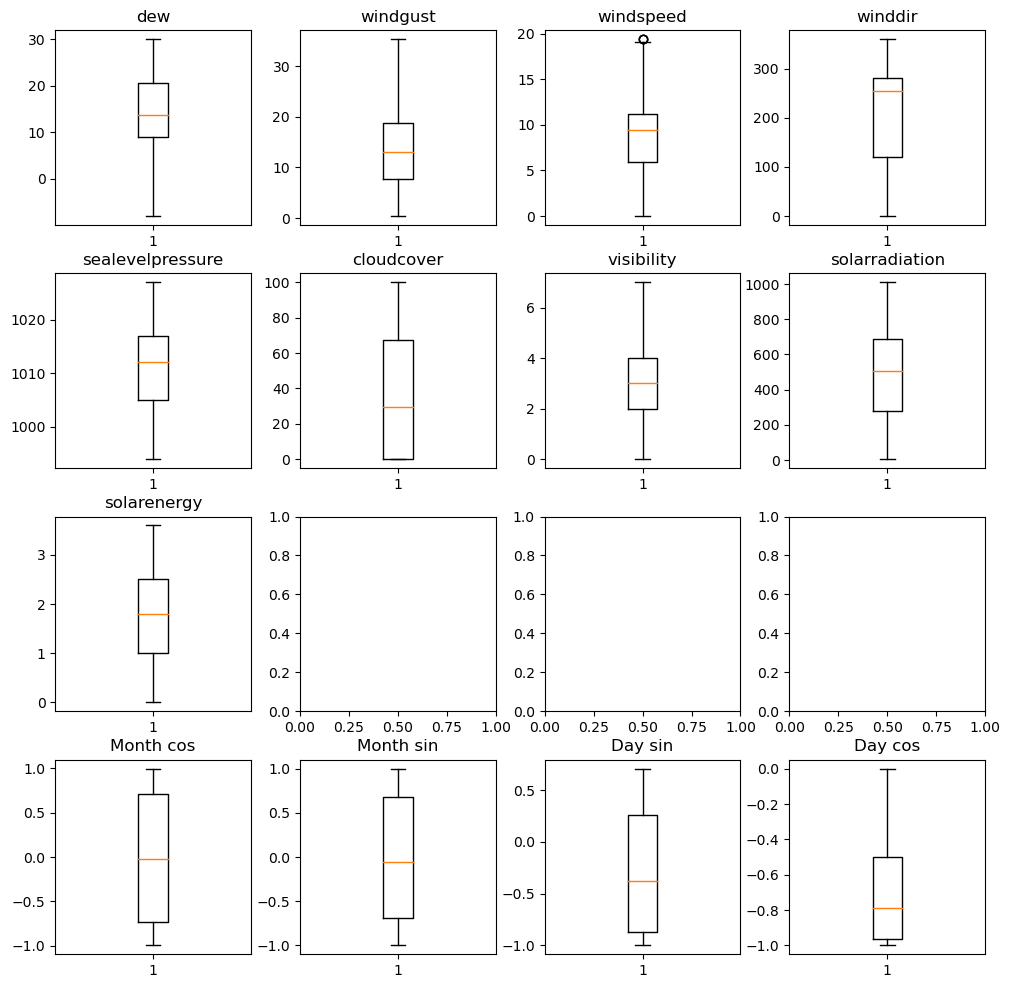

In [38]:
fig, ax = plt.subplots(4,4,figsize=(12,12))
fig.subplots_adjust(wspace=0.25, hspace=0.25)

ax[0][0].boxplot(data['dew'])
ax[0][0].set_title('dew')

ax[0][1].boxplot(data['windgust'])
ax[0][1].set_title('windgust')

ax[0][2].boxplot(data['windspeed'])
ax[0][2].set_title('windspeed')

ax[0][3].boxplot(data['winddir'])
ax[0][3].set_title('winddir')

ax[1][0].boxplot(data['sealevelpressure'])
ax[1][0].set_title('sealevelpressure')

ax[1][1].boxplot(data['cloudcover'])
ax[1][1].set_title('cloudcover')

ax[1][2].boxplot(data['visibility'])
ax[1][2].set_title('visibility')

ax[1][3].boxplot(data['solarradiation'])
ax[1][3].set_title('solarradiation')

ax[2][0].boxplot(data['solarenergy'])
ax[2][0].set_title('solarenergy')

ax[3][0].boxplot(data['Month cos'])
ax[3][0].set_title('Month cos')

ax[3][1].boxplot(data['Month sin'])
ax[3][1].set_title('Month sin')

ax[3][2].boxplot(data['Day sin'])
ax[3][2].set_title('Day sin')

ax[3][3].boxplot(data['Day cos'])
ax[3][3].set_title('Day cos')

In [39]:
data

dew  windgust  windspeed  winddir  sealevelpressure  \
Datetime                                                                    
2023-01-01 09:00:00  10.0       4.3        5.4    250.0            1022.0   
2023-01-01 10:00:00  10.0       1.8        9.4    250.0            1023.0   
2023-01-01 11:00:00  10.7       2.2        8.0    250.0            1022.5   
2023-01-01 12:00:00  11.0       3.2        7.6    270.0            1022.0   
2023-01-01 13:00:00  12.0       2.9        5.4    270.0            1021.0   
...                   ...       ...        ...      ...               ...   
2024-03-12 14:00:00  10.6      17.6        8.5    298.0            1012.9   
2024-03-12 15:00:00   6.0      18.4       13.0    300.0            1014.0   
2024-03-12 16:00:00   6.0      18.7       13.0    300.0            1013.0   
2024-03-12 17:00:00  10.4      18.0        6.1    282.0            1012.0   
2024-03-12 18:00:00   9.0      18.0       11.2    300.0            1013.0   

                     cloudcover  visibility  solarradiation  solarenergy  \
Datetime                                                                   
2023-01-01 09:00:00         0.0         1.0            73.0          0.3   
2023-01-01 10:00:00         0.0         2.0           209.0          0.8   
2023-01-01 11:00:00         0.0         1.9           409.0          1.5   
2023-01-01 12:00:00         0.0         2.0           529.0          1.9   
2023-01-01 13:00:00         0.0         2.0           589.0          2.1   
...                         ...         ...             ...          ...   
2024-03-12 14:00:00         0.0         4.1           837.0          3.0   
2024-03-12 15:00:00         0.0         5.0           767.0          2.8   
2024-03-12 16:00:00         0.0         5.0           630.0          2.3   
2024-03-12 17:00:00         0.0         4.1           441.0          1.6   
2024-03-12 18:00:00         0.0         4.0           226.0          0.8   

                          Day sin       Day cos  Month sin  Month cos  
Datetime                                                               
2023-01-01 09:00:00  7.071068e-01 -7.071068e-01   0.983255  -0.182236  
2023-01-01 10:00:00  5.000000e-01 -8.660254e-01   0.981627  -0.190809  
2023-01-01 11:00:00  2.588190e-01 -9.659258e-01   0.979925  -0.199368  
2023-01-01 12:00:00  1.867320e-12 -1.000000e+00   0.978148  -0.207912  
2023-01-01 13:00:00 -2.588190e-01 -9.659258e-01   0.976296  -0.216440  
...                           ...           ...        ...        ...  
2024-03-12 14:00:00 -5.000000e-01 -8.660254e-01  -0.906308   0.422618  
2024-03-12 15:00:00 -7.071068e-01 -7.071068e-01  -0.902585   0.430511  
2024-03-12 16:00:00 -8.660254e-01 -5.000000e-01  -0.898794   0.438371  
2024-03-12 17:00:00 -9.659258e-01 -2.588190e-01  -0.894934   0.446198  
2024-03-12 18:00:00 -1.000000e+00 -7.464889e-12  -0.891007   0.453990  

[4370 rows x 13 columns]

In [40]:
data.dropna(inplace=True)

In [41]:
data

dew  windgust  windspeed  winddir  sealevelpressure  \
Datetime                                                                    
2023-01-01 09:00:00  10.0       4.3        5.4    250.0            1022.0   
2023-01-01 10:00:00  10.0       1.8        9.4    250.0            1023.0   
2023-01-01 11:00:00  10.7       2.2        8.0    250.0            1022.5   
2023-01-01 12:00:00  11.0       3.2        7.6    270.0            1022.0   
2023-01-01 13:00:00  12.0       2.9        5.4    270.0            1021.0   
...                   ...       ...        ...      ...               ...   
2024-03-12 14:00:00  10.6      17.6        8.5    298.0            1012.9   
2024-03-12 15:00:00   6.0      18.4       13.0    300.0            1014.0   
2024-03-12 16:00:00   6.0      18.7       13.0    300.0            1013.0   
2024-03-12 17:00:00  10.4      18.0        6.1    282.0            1012.0   
2024-03-12 18:00:00   9.0      18.0       11.2    300.0            1013.0   

                     cloudcover  visibility  solarradiation  solarenergy  \
Datetime                                                                   
2023-01-01 09:00:00         0.0         1.0            73.0          0.3   
2023-01-01 10:00:00         0.0         2.0           209.0          0.8   
2023-01-01 11:00:00         0.0         1.9           409.0          1.5   
2023-01-01 12:00:00         0.0         2.0           529.0          1.9   
2023-01-01 13:00:00         0.0         2.0           589.0          2.1   
...                         ...         ...             ...          ...   
2024-03-12 14:00:00         0.0         4.1           837.0          3.0   
2024-03-12 15:00:00         0.0         5.0           767.0          2.8   
2024-03-12 16:00:00         0.0         5.0           630.0          2.3   
2024-03-12 17:00:00         0.0         4.1           441.0          1.6   
2024-03-12 18:00:00         0.0         4.0           226.0          0.8   

                          Day sin       Day cos  Month sin  Month cos  
Datetime                                                               
2023-01-01 09:00:00  7.071068e-01 -7.071068e-01   0.983255  -0.182236  
2023-01-01 10:00:00  5.000000e-01 -8.660254e-01   0.981627  -0.190809  
2023-01-01 11:00:00  2.588190e-01 -9.659258e-01   0.979925  -0.199368  
2023-01-01 12:00:00  1.867320e-12 -1.000000e+00   0.978148  -0.207912  
2023-01-01 13:00:00 -2.588190e-01 -9.659258e-01   0.976296  -0.216440  
...                           ...           ...        ...        ...  
2024-03-12 14:00:00 -5.000000e-01 -8.660254e-01  -0.906308   0.422618  
2024-03-12 15:00:00 -7.071068e-01 -7.071068e-01  -0.902585   0.430511  
2024-03-12 16:00:00 -8.660254e-01 -5.000000e-01  -0.898794   0.438371  
2024-03-12 17:00:00 -9.659258e-01 -2.588190e-01  -0.894934   0.446198  
2024-03-12 18:00:00 -1.000000e+00 -7.464889e-12  -0.891007   0.453990  

[4370 rows x 13 columns]

Text(0.5, 1.0, 'Solar Irradiance Data')

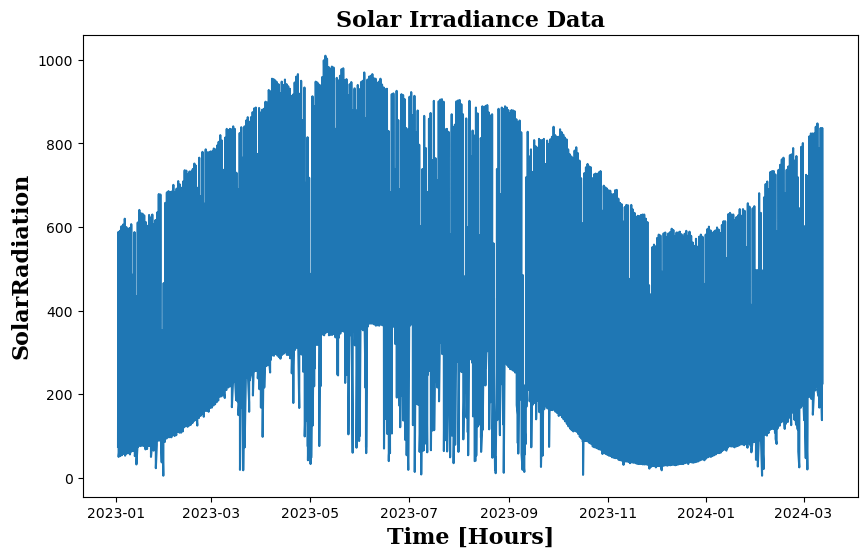

In [7]:
plt.figure(figsize=(10,6))
plt.plot(data['solarradiation'])

plt.xlabel('Time [Hours]',fontsize=16, fontweight='bold',fontfamily='serif')
plt.ylabel('SolarRadiation',fontsize=16, fontweight='bold',fontfamily='serif')
plt.title('Solar Irradiance Data',fontsize=16, fontweight='bold',fontfamily='serif')

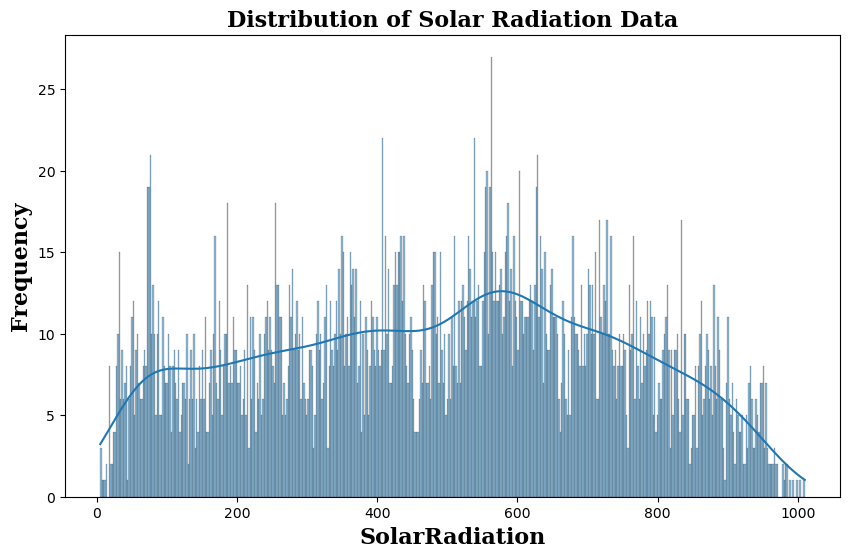

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=data['solarradiation'], bins=500, kde=True)  

plt.xlabel('SolarRadiation', fontsize=16, fontweight='bold', fontfamily='serif')
plt.ylabel('Frequency', fontsize=16, fontweight='bold', fontfamily='serif')
plt.title('Distribution of Solar Radiation Data', fontsize=16, fontweight='bold', fontfamily='serif')

plt.show()


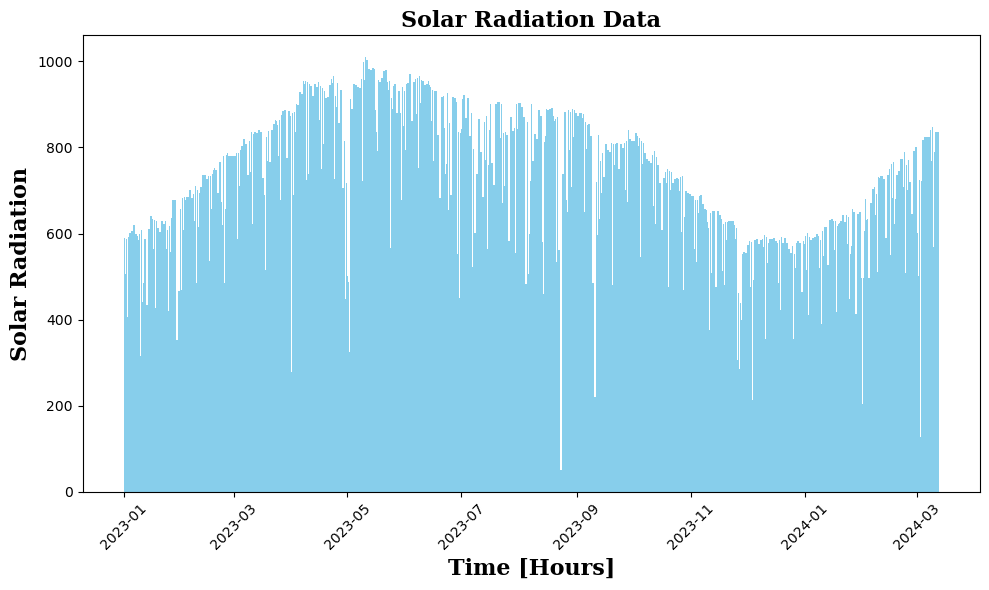

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(data.index, data['solarradiation'], color='skyblue')

plt.xlabel('Time [Hours]', fontsize=16, fontweight='bold', fontfamily='serif')
plt.ylabel('Solar Radiation', fontsize=16, fontweight='bold', fontfamily='serif')
plt.title('Solar Radiation Data', fontsize=16, fontweight='bold', fontfamily='serif')

plt.xticks(rotation=45)  
plt.tight_layout()  

plt.show()



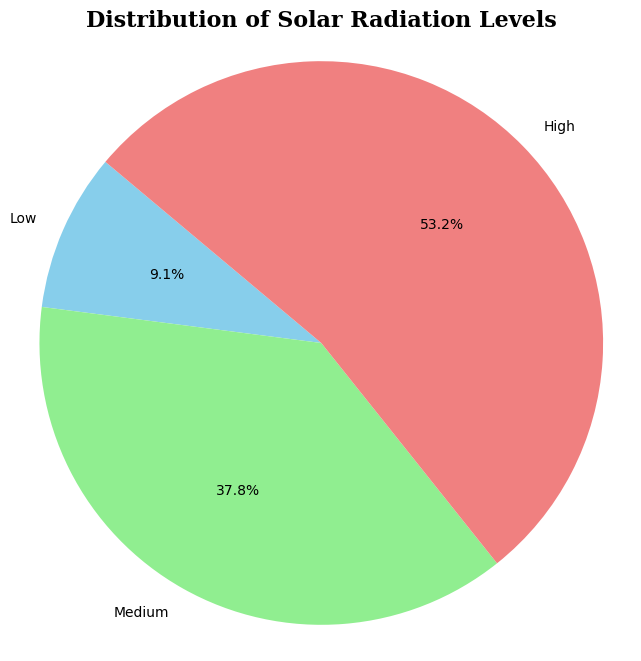

In [104]:
import matplotlib.pyplot as plt


categories = ['Low', 'Medium', 'High']  
category_counts = [len(data[data['solarradiation'] < threshold]) for threshold in [200, 650, 1000]] 
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=categories, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Distribution of Solar Radiation Levels', fontsize=16, fontweight='bold', fontfamily='serif')
plt.axis('equal')  
plt.show()





In [2]:
data = pd.read_csv("deseasonalized_data.csv")
data.index =pd.to_datetime(data['Datetime'])
data = data.drop('Datetime', axis=1)

In [3]:
df = data

In [4]:
data

dew  windgust  windspeed  winddir  sealevelpressure  \
Datetime                                                                    
2023-01-02 09:00:00  10.0       1.1        0.0      0.0            1023.0   
2023-01-02 10:00:00  10.0       2.5        0.0      0.0            1023.0   
2023-01-02 11:00:00  10.5       1.1        0.0    353.9            1023.3   
2023-01-02 12:00:00  11.0       2.2        5.4    210.0            1022.0   
2023-01-02 13:00:00  11.0       3.6        9.4    240.0            1022.0   
...                   ...       ...        ...      ...               ...   
2024-03-12 14:00:00  10.6      17.6        8.5    298.0            1012.9   
2024-03-12 15:00:00   6.0      18.4       13.0    300.0            1014.0   
2024-03-12 16:00:00   6.0      18.7       13.0    300.0            1013.0   
2024-03-12 17:00:00  10.4      18.0        6.1    282.0            1012.0   
2024-03-12 18:00:00   9.0      18.0       11.2    300.0            1013.0   

                     cloudcover  visibility  solarradiation  solarenergy  \
Datetime                                                                   
2023-01-02 09:00:00         0.0         1.0            74.0          0.3   
2023-01-02 10:00:00         0.0         1.0           244.0          0.9   
2023-01-02 11:00:00         3.3         1.0           407.0          1.5   
2023-01-02 12:00:00         0.0         1.0           527.0          1.9   
2023-01-02 13:00:00         0.0         1.0           588.0          2.1   
...                         ...         ...             ...          ...   
2024-03-12 14:00:00         0.0         4.1           837.0          3.0   
2024-03-12 15:00:00         0.0         5.0           767.0          2.8   
2024-03-12 16:00:00         0.0         5.0           630.0          2.3   
2024-03-12 17:00:00         0.0         4.1           441.0          1.6   
2024-03-12 18:00:00         0.0         4.0           226.0          0.8   

                     deseasonalised       Day sin       Day cos  Month sin  \
Datetime                                                                     
2023-01-02 09:00:00             1.0  7.071068e-01 -7.071068e-01   0.923880   
2023-01-02 10:00:00            35.0  5.000000e-01 -8.660254e-01   0.920505   
2023-01-02 11:00:00            -2.0  2.588190e-01 -9.659258e-01   0.917060   
2023-01-02 12:00:00            -2.0  1.212070e-11 -1.000000e+00   0.913545   
2023-01-02 13:00:00            -1.0 -2.588190e-01 -9.659258e-01   0.909961   
...                             ...           ...           ...        ...   
2024-03-12 14:00:00             0.0 -5.000000e-01 -8.660254e-01  -0.906308   
2024-03-12 15:00:00             1.0 -7.071068e-01 -7.071068e-01  -0.902585   
2024-03-12 16:00:00             2.0 -8.660254e-01 -5.000000e-01  -0.898794   
2024-03-12 17:00:00             1.0 -9.659258e-01 -2.588190e-01  -0.894934   
2024-03-12 18:00:00             1.0 -1.000000e+00 -7.464889e-12  -0.891007   

                     Month cos  
Datetime                        
2023-01-02 09:00:00  -0.382683  
2023-01-02 10:00:00  -0.390731  
2023-01-02 11:00:00  -0.398749  
2023-01-02 12:00:00  -0.406737  
2023-01-02 13:00:00  -0.414693  
...                        ...  
2024-03-12 14:00:00   0.422618  
2024-03-12 15:00:00   0.430511  
2024-03-12 16:00:00   0.438371  
2024-03-12 17:00:00   0.446198  
2024-03-12 18:00:00   0.453990  

[4360 rows x 14 columns]

In [5]:
dt_arr=np.array(data)
dt_arr

array([[ 1.00000000e+01,  1.10000000e+00,  0.00000000e+00, ...,
        -7.07106781e-01,  9.23879533e-01, -3.82683432e-01],
       [ 1.00000000e+01,  2.50000000e+00,  0.00000000e+00, ...,
        -8.66025404e-01,  9.20504853e-01, -3.90731128e-01],
       [ 1.05000000e+01,  1.10000000e+00,  0.00000000e+00, ...,
        -9.65925826e-01,  9.17060074e-01, -3.98749069e-01],
       ...,
       [ 6.00000000e+00,  1.87000000e+01,  1.30000000e+01, ...,
        -5.00000000e-01, -8.98794046e-01,  4.38371147e-01],
       [ 1.04000000e+01,  1.80000000e+01,  6.10000000e+00, ...,
        -2.58819045e-01, -8.94934362e-01,  4.46197813e-01],
       [ 9.00000000e+00,  1.80000000e+01,  1.12000000e+01, ...,
        -7.46488907e-12, -8.91006524e-01,  4.53990500e-01]])

In [6]:
from sklearn.preprocessing import minmax_scale
scaler=minmax_scale

In [7]:
for i in range (dt_arr.shape[1]):
    dt_arr[:,i]=scaler(dt_arr[:,i])

In [8]:
dt_arr

array([[0.47368421, 0.02005731, 0.        , ..., 0.29289322, 0.96193977,
        0.3083957 ],
       [0.47368421, 0.06017192, 0.        , ..., 0.1339746 , 0.96025243,
        0.30436633],
       [0.48684211, 0.02005731, 0.        , ..., 0.03407417, 0.95853004,
        0.30035185],
       ...,
       [0.36842105, 0.5243553 , 0.67010309, ..., 0.5       , 0.05060298,
        0.71948637],
       [0.48421053, 0.50429799, 0.31443299, ..., 0.74118095, 0.05253282,
        0.72340508],
       [0.44736842, 0.50429799, 0.57731959, ..., 1.        , 0.05449674,
        0.72730677]])

In [9]:
data

dew  windgust  windspeed  winddir  sealevelpressure  \
Datetime                                                                    
2023-01-02 09:00:00  10.0       1.1        0.0      0.0            1023.0   
2023-01-02 10:00:00  10.0       2.5        0.0      0.0            1023.0   
2023-01-02 11:00:00  10.5       1.1        0.0    353.9            1023.3   
2023-01-02 12:00:00  11.0       2.2        5.4    210.0            1022.0   
2023-01-02 13:00:00  11.0       3.6        9.4    240.0            1022.0   
...                   ...       ...        ...      ...               ...   
2024-03-12 14:00:00  10.6      17.6        8.5    298.0            1012.9   
2024-03-12 15:00:00   6.0      18.4       13.0    300.0            1014.0   
2024-03-12 16:00:00   6.0      18.7       13.0    300.0            1013.0   
2024-03-12 17:00:00  10.4      18.0        6.1    282.0            1012.0   
2024-03-12 18:00:00   9.0      18.0       11.2    300.0            1013.0   

                     cloudcover  visibility  solarradiation  solarenergy  \
Datetime                                                                   
2023-01-02 09:00:00         0.0         1.0            74.0          0.3   
2023-01-02 10:00:00         0.0         1.0           244.0          0.9   
2023-01-02 11:00:00         3.3         1.0           407.0          1.5   
2023-01-02 12:00:00         0.0         1.0           527.0          1.9   
2023-01-02 13:00:00         0.0         1.0           588.0          2.1   
...                         ...         ...             ...          ...   
2024-03-12 14:00:00         0.0         4.1           837.0          3.0   
2024-03-12 15:00:00         0.0         5.0           767.0          2.8   
2024-03-12 16:00:00         0.0         5.0           630.0          2.3   
2024-03-12 17:00:00         0.0         4.1           441.0          1.6   
2024-03-12 18:00:00         0.0         4.0           226.0          0.8   

                     deseasonalised       Day sin       Day cos  Month sin  \
Datetime                                                                     
2023-01-02 09:00:00             1.0  7.071068e-01 -7.071068e-01   0.923880   
2023-01-02 10:00:00            35.0  5.000000e-01 -8.660254e-01   0.920505   
2023-01-02 11:00:00            -2.0  2.588190e-01 -9.659258e-01   0.917060   
2023-01-02 12:00:00            -2.0  1.212070e-11 -1.000000e+00   0.913545   
2023-01-02 13:00:00            -1.0 -2.588190e-01 -9.659258e-01   0.909961   
...                             ...           ...           ...        ...   
2024-03-12 14:00:00             0.0 -5.000000e-01 -8.660254e-01  -0.906308   
2024-03-12 15:00:00             1.0 -7.071068e-01 -7.071068e-01  -0.902585   
2024-03-12 16:00:00             2.0 -8.660254e-01 -5.000000e-01  -0.898794   
2024-03-12 17:00:00             1.0 -9.659258e-01 -2.588190e-01  -0.894934   
2024-03-12 18:00:00             1.0 -1.000000e+00 -7.464889e-12  -0.891007   

                     Month cos  
Datetime                        
2023-01-02 09:00:00  -0.382683  
2023-01-02 10:00:00  -0.390731  
2023-01-02 11:00:00  -0.398749  
2023-01-02 12:00:00  -0.406737  
2023-01-02 13:00:00  -0.414693  
...                        ...  
2024-03-12 14:00:00   0.422618  
2024-03-12 15:00:00   0.430511  
2024-03-12 16:00:00   0.438371  
2024-03-12 17:00:00   0.446198  
2024-03-12 18:00:00   0.453990  

[4360 rows x 14 columns]

In [10]:
def create_dataset(data,time_window, label):   
                                              
    X,Y=[],[]

    for i in range (len(data)-time_window-1) :
        
        a=data[i:i+time_window,0:data.shape[1]]
        X.append(a)
        Y.append(data[i+time_window,label])
        
    return (np.array(X),np.array(Y))

In [11]:
dt_train, d_test= dt_arr[0:round(0.75*len(dt_arr))] ,  dt_arr[round(0.75*len(dt_arr)):] 
dt_val, dt_test= d_test[0:round(0.5*len(d_test))], d_test[round(0.5*len(d_test)):] 

In [12]:
X_train,Y_train=create_dataset(dt_train, 7,9)
X_val, Y_val=create_dataset(dt_val,7,9)
X_test, Y_test=create_dataset(dt_test,7,9)

In [13]:
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((3262, 7, 14), (3262,), (537, 7, 14), (537,), (537, 7, 14), (537,))

In [14]:
data

dew  windgust  windspeed  winddir  sealevelpressure  \
Datetime                                                                    
2023-01-02 09:00:00  10.0       1.1        0.0      0.0            1023.0   
2023-01-02 10:00:00  10.0       2.5        0.0      0.0            1023.0   
2023-01-02 11:00:00  10.5       1.1        0.0    353.9            1023.3   
2023-01-02 12:00:00  11.0       2.2        5.4    210.0            1022.0   
2023-01-02 13:00:00  11.0       3.6        9.4    240.0            1022.0   
...                   ...       ...        ...      ...               ...   
2024-03-12 14:00:00  10.6      17.6        8.5    298.0            1012.9   
2024-03-12 15:00:00   6.0      18.4       13.0    300.0            1014.0   
2024-03-12 16:00:00   6.0      18.7       13.0    300.0            1013.0   
2024-03-12 17:00:00  10.4      18.0        6.1    282.0            1012.0   
2024-03-12 18:00:00   9.0      18.0       11.2    300.0            1013.0   

                     cloudcover  visibility  solarradiation  solarenergy  \
Datetime                                                                   
2023-01-02 09:00:00         0.0         1.0            74.0          0.3   
2023-01-02 10:00:00         0.0         1.0           244.0          0.9   
2023-01-02 11:00:00         3.3         1.0           407.0          1.5   
2023-01-02 12:00:00         0.0         1.0           527.0          1.9   
2023-01-02 13:00:00         0.0         1.0           588.0          2.1   
...                         ...         ...             ...          ...   
2024-03-12 14:00:00         0.0         4.1           837.0          3.0   
2024-03-12 15:00:00         0.0         5.0           767.0          2.8   
2024-03-12 16:00:00         0.0         5.0           630.0          2.3   
2024-03-12 17:00:00         0.0         4.1           441.0          1.6   
2024-03-12 18:00:00         0.0         4.0           226.0          0.8   

                     deseasonalised       Day sin       Day cos  Month sin  \
Datetime                                                                     
2023-01-02 09:00:00             1.0  7.071068e-01 -7.071068e-01   0.923880   
2023-01-02 10:00:00            35.0  5.000000e-01 -8.660254e-01   0.920505   
2023-01-02 11:00:00            -2.0  2.588190e-01 -9.659258e-01   0.917060   
2023-01-02 12:00:00            -2.0  1.212070e-11 -1.000000e+00   0.913545   
2023-01-02 13:00:00            -1.0 -2.588190e-01 -9.659258e-01   0.909961   
...                             ...           ...           ...        ...   
2024-03-12 14:00:00             0.0 -5.000000e-01 -8.660254e-01  -0.906308   
2024-03-12 15:00:00             1.0 -7.071068e-01 -7.071068e-01  -0.902585   
2024-03-12 16:00:00             2.0 -8.660254e-01 -5.000000e-01  -0.898794   
2024-03-12 17:00:00             1.0 -9.659258e-01 -2.588190e-01  -0.894934   
2024-03-12 18:00:00             1.0 -1.000000e+00 -7.464889e-12  -0.891007   

                     Month cos  
Datetime                        
2023-01-02 09:00:00  -0.382683  
2023-01-02 10:00:00  -0.390731  
2023-01-02 11:00:00  -0.398749  
2023-01-02 12:00:00  -0.406737  
2023-01-02 13:00:00  -0.414693  
...                        ...  
2024-03-12 14:00:00   0.422618  
2024-03-12 15:00:00   0.430511  
2024-03-12 16:00:00   0.438371  
2024-03-12 17:00:00   0.446198  
2024-03-12 18:00:00   0.453990  

[4360 rows x 14 columns]

In [156]:
from tensorflow.keras.layers import Conv1D, LSTM


input_shape = (7, 14)  

model13 = Sequential()

# Add 1D CNN layers
model13.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='tanh', input_shape=input_shape))
model13.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='tanh'))
model13.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='tanh'))

# Add LSTM layers
model13.add(LSTM(units=64, return_sequences=True))
model13.add(LSTM(units=64, return_sequences=True))
model13.add(LSTM(units=64, return_sequences=False))

# Add Dense layers
model13.add(Dense(units=8, activation='tanh'))
model13.add(Dense(units=1, activation='linear'))

model13.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_49 (Conv1D)          (None, 7, 32)             1376      
                                                                 
 conv1d_50 (Conv1D)          (None, 7, 64)             6208      
                                                                 
 conv1d_51 (Conv1D)          (None, 7, 128)            24704     
                                                                 
 lstm_49 (LSTM)              (None, 7, 64)             49408     
                                                                 
 lstm_50 (LSTM)              (None, 7, 64)             33024     
                                                                 
 lstm_51 (LSTM)              (None, 64)                33024     
                                                                 
 dense_23 (Dense)            (None, 8)               

In [157]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

cp20 = ModelCheckpoint('model/model20/', save_best_only=True)
model13.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(),'mae'])
Model13 = model13.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, callbacks=[cp20])

Epoch 1/10
102/102 [==============================] - ETA: 0s - loss: 0.0576 - root_mean_squared_error: 0.2399 - mae: 0.1776INFO:tensorflow:Assets written to: model/model20/assets


INFO:tensorflow:Assets written to: model/model20/assets


102/102 [==============================] - 16s 114ms/step - loss: 0.0576 - root_mean_squared_error: 0.2399 - mae: 0.1776 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1476 - val_mae: 0.0997
Epoch 2/10
102/102 [==============================] - ETA: 0s - loss: 0.0290 - root_mean_squared_error: 0.1702 - mae: 0.1237INFO:tensorflow:Assets written to: model/model20/assets


INFO:tensorflow:Assets written to: model/model20/assets


102/102 [==============================] - 7s 66ms/step - loss: 0.0290 - root_mean_squared_error: 0.1702 - mae: 0.1237 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1423 - val_mae: 0.0966
Epoch 3/10
100/102 [============================>.] - ETA: 0s - loss: 0.0267 - root_mean_squared_error: 0.1633 - mae: 0.1177INFO:tensorflow:Assets written to: model/model20/assets


INFO:tensorflow:Assets written to: model/model20/assets


102/102 [==============================] - 7s 66ms/step - loss: 0.0265 - root_mean_squared_error: 0.1629 - mae: 0.1174 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1410 - val_mae: 0.0977
Epoch 4/10
102/102 [==============================] - ETA: 0s - loss: 0.0248 - root_mean_squared_error: 0.1576 - mae: 0.1122INFO:tensorflow:Assets written to: model/model20/assets


INFO:tensorflow:Assets written to: model/model20/assets


102/102 [==============================] - 8s 79ms/step - loss: 0.0248 - root_mean_squared_error: 0.1576 - mae: 0.1122 - val_loss: 0.0186 - val_root_mean_squared_error: 0.1364 - val_mae: 0.0937
Epoch 5/10
102/102 [==============================] - 2s 23ms/step - loss: 0.0233 - root_mean_squared_error: 0.1525 - mae: 0.1083 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1372 - val_mae: 0.0972
Epoch 6/10
102/102 [==============================] - ETA: 0s - loss: 0.0220 - root_mean_squared_error: 0.1483 - mae: 0.1039INFO:tensorflow:Assets written to: model/model20/assets


INFO:tensorflow:Assets written to: model/model20/assets


102/102 [==============================] - 7s 65ms/step - loss: 0.0220 - root_mean_squared_error: 0.1483 - mae: 0.1039 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1288 - val_mae: 0.0875
Epoch 7/10
102/102 [==============================] - 2s 22ms/step - loss: 0.0215 - root_mean_squared_error: 0.1466 - mae: 0.1035 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1320 - val_mae: 0.0940
Epoch 8/10
101/102 [============================>.] - ETA: 0s - loss: 0.0197 - root_mean_squared_error: 0.1402 - mae: 0.0971INFO:tensorflow:Assets written to: model/model20/assets


INFO:tensorflow:Assets written to: model/model20/assets


102/102 [==============================] - 7s 69ms/step - loss: 0.0198 - root_mean_squared_error: 0.1406 - mae: 0.0973 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1259 - val_mae: 0.0846
Epoch 9/10
102/102 [==============================] - 3s 29ms/step - loss: 0.0188 - root_mean_squared_error: 0.1373 - mae: 0.0951 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1274 - val_mae: 0.0865
Epoch 10/10
100/102 [============================>.] - ETA: 0s - loss: 0.0182 - root_mean_squared_error: 0.1350 - mae: 0.0935INFO:tensorflow:Assets written to: model/model20/assets


INFO:tensorflow:Assets written to: model/model20/assets


102/102 [==============================] - 8s 75ms/step - loss: 0.0183 - root_mean_squared_error: 0.1353 - mae: 0.0935 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1232 - val_mae: 0.0828


In [158]:
Y_pred=model13.predict(X_test)

17/17 [==============================] - 2s 22ms/step


In [159]:
from sklearn.metrics import r2_score, mean_squared_error

In [160]:
print ('R-Squared:',r2_score(Y_test,Y_pred))
print ('Mean squared error:', mean_squared_error (Y_test, Y_pred))
print('MAPE: ', mean_absolute_percentage_error(Y_test, Y_pred))

R-Squared: 0.5718247671975218
Mean squared error: 0.022289109108956703
MAPE:  tf.Tensor(1029755378.1813456, shape=(), dtype=float64)


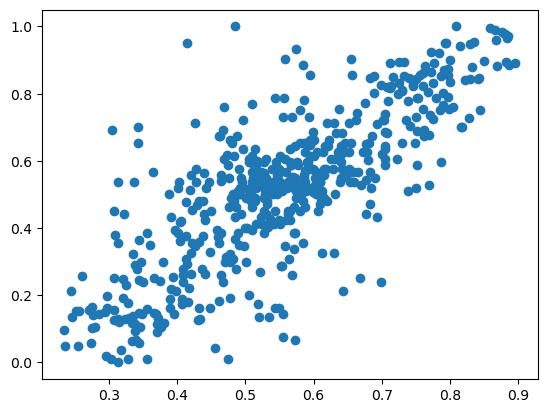

In [161]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred, Y_test)

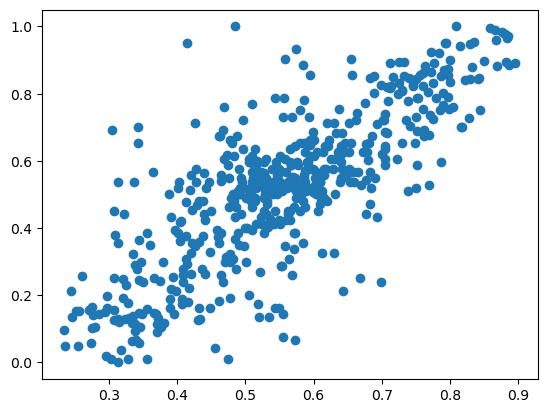

In [162]:
plt.scatter(Y_pred, Y_test)

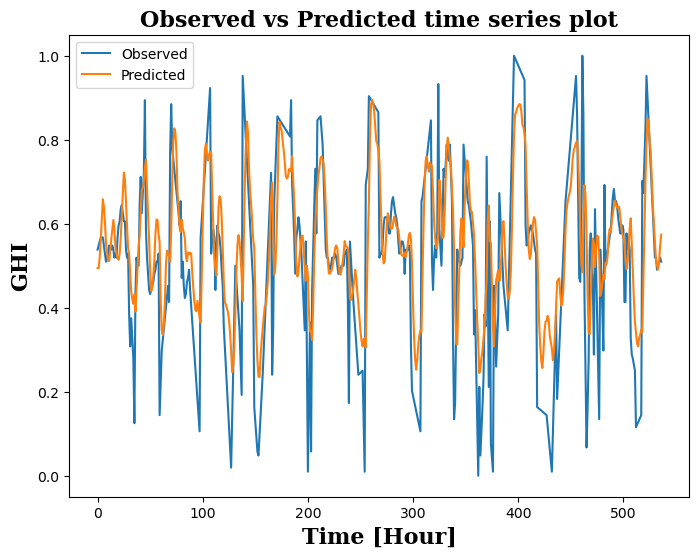

In [163]:
pltMod(Model13, Y_pred, Y_test)

17/17 [==============================] - 0s 8ms/step


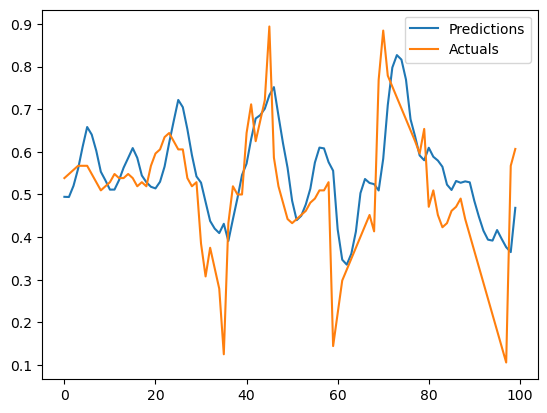

MAPE: 583830454.9393383
MSE for Predictions: 0.022289109108956703
MAE:  0.11242997


In [164]:
plot_predictions2(model13, X_test, Y_test)

In [168]:
import keras
from keras import layers
import tensorflow as tf


def lstm_attention_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    
    # LSTM layer
    lstm = layers.LSTM(100, return_sequences=True)(inputs)
    
    # Attention mechanism
    attention = layers.Dense(1, activation='tanh')(lstm)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(100)(attention)
    attention = layers.Permute([2, 1])(attention)
    attention = layers.Multiply()([lstm, attention])
    attention = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(attention)
    
    # Output layer
    outputs = layers.Dense(1)(attention)
    
    # Compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [169]:
model14=lstm_attention_model(input_shape=(7,14))

In [170]:
model14.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 7, 14)]              0         []                            
                                                                                                  
 lstm_53 (LSTM)              (None, 7, 100)               46000     ['input_11[0][0]']            
                                                                                                  
 dense_27 (Dense)            (None, 7, 1)                 101       ['lstm_53[0][0]']             
                                                                                                  
 flatten_8 (Flatten)         (None, 7)                    0         ['dense_27[0][0]']            
                                                                                            

In [171]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

cp14 = ModelCheckpoint('model/model14/', save_best_only=True)
model14.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
Model14 = model14.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, callbacks=[cp14])

Epoch 1/10
102/102 [==============================] - ETA: 0s - loss: 0.1025 - root_mean_squared_error: 0.3202INFO:tensorflow:Assets written to: model/model14/assets


INFO:tensorflow:Assets written to: model/model14/assets


102/102 [==============================] - 10s 61ms/step - loss: 0.1025 - root_mean_squared_error: 0.3202 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1713
Epoch 2/10
102/102 [==============================] - ETA: 0s - loss: 0.0333 - root_mean_squared_error: 0.1825INFO:tensorflow:Assets written to: model/model14/assets


INFO:tensorflow:Assets written to: model/model14/assets


102/102 [==============================] - 5s 49ms/step - loss: 0.0333 - root_mean_squared_error: 0.1825 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1636
Epoch 3/10
102/102 [==============================] - ETA: 0s - loss: 0.0320 - root_mean_squared_error: 0.1789INFO:tensorflow:Assets written to: model/model14/assets


INFO:tensorflow:Assets written to: model/model14/assets


102/102 [==============================] - 3s 32ms/step - loss: 0.0320 - root_mean_squared_error: 0.1789 - val_loss: 0.0241 - val_root_mean_squared_error: 0.1554
Epoch 4/10
 98/102 [===========================>..] - ETA: 0s - loss: 0.0309 - root_mean_squared_error: 0.1759INFO:tensorflow:Assets written to: model/model14/assets


INFO:tensorflow:Assets written to: model/model14/assets


102/102 [==============================] - 3s 30ms/step - loss: 0.0309 - root_mean_squared_error: 0.1757 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1518
Epoch 5/10
 98/102 [===========================>..] - ETA: 0s - loss: 0.0301 - root_mean_squared_error: 0.1734INFO:tensorflow:Assets written to: model/model14/assets


INFO:tensorflow:Assets written to: model/model14/assets


102/102 [==============================] - 3s 30ms/step - loss: 0.0300 - root_mean_squared_error: 0.1732 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1475
Epoch 6/10
102/102 [==============================] - ETA: 0s - loss: 0.0291 - root_mean_squared_error: 0.1706INFO:tensorflow:Assets written to: model/model14/assets


INFO:tensorflow:Assets written to: model/model14/assets


102/102 [==============================] - 4s 36ms/step - loss: 0.0291 - root_mean_squared_error: 0.1706 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1446
Epoch 7/10
100/102 [============================>.] - ETA: 0s - loss: 0.0282 - root_mean_squared_error: 0.1680INFO:tensorflow:Assets written to: model/model14/assets


INFO:tensorflow:Assets written to: model/model14/assets


102/102 [==============================] - 3s 30ms/step - loss: 0.0285 - root_mean_squared_error: 0.1687 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1430
Epoch 8/10
 99/102 [============================>.] - ETA: 0s - loss: 0.0280 - root_mean_squared_error: 0.1674INFO:tensorflow:Assets written to: model/model14/assets


INFO:tensorflow:Assets written to: model/model14/assets


102/102 [==============================] - 3s 30ms/step - loss: 0.0278 - root_mean_squared_error: 0.1668 - val_loss: 0.0204 - val_root_mean_squared_error: 0.1429
Epoch 9/10
102/102 [==============================] - ETA: 0s - loss: 0.0273 - root_mean_squared_error: 0.1654INFO:tensorflow:Assets written to: model/model14/assets


INFO:tensorflow:Assets written to: model/model14/assets


102/102 [==============================] - 3s 30ms/step - loss: 0.0273 - root_mean_squared_error: 0.1654 - val_loss: 0.0202 - val_root_mean_squared_error: 0.1422
Epoch 10/10
 99/102 [============================>.] - ETA: 0s - loss: 0.0270 - root_mean_squared_error: 0.1643INFO:tensorflow:Assets written to: model/model14/assets


INFO:tensorflow:Assets written to: model/model14/assets


102/102 [==============================] - 3s 32ms/step - loss: 0.0270 - root_mean_squared_error: 0.1642 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1417


In [172]:
Ypredd=model14.predict(X_test)

17/17 [==============================] - 1s 13ms/step


In [173]:
print ('R-Squared:',r2_score(Y_test,Ypredd))
print ('Mean squared error:', mean_squared_error (Y_test, Ypredd))

R-Squared: 0.2439290601729901
Mean squared error: 0.0393580627296342


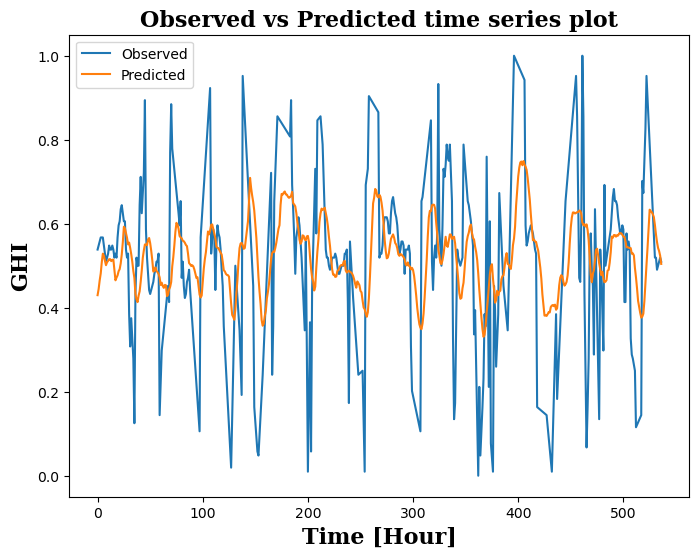

In [174]:
plt.figure(figsize=(8,6))

plt.plot(Y_test)
plt.plot(Ypredd)



plt.xlabel('Time [Hour]',fontsize=16, fontweight='bold',fontfamily='serif')
plt.ylabel('GHI',fontsize=16, fontweight='bold',fontfamily='serif')
plt.title('Observed vs Predicted time series plot',fontsize=16, fontweight='bold',fontfamily='serif')
plt.legend(['Observed','Predicted'])

In [175]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(Y_test, Y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r_squared)

Mean Squared Error (MSE): 0.022289109108956703
Mean Absolute Error (MAE): 0.11242996583998051
Root Mean Squared Error (RMSE): 0.14929537537699117
R-squared: 0.5718247671975218


17/17 [==============================] - 0s 7ms/step


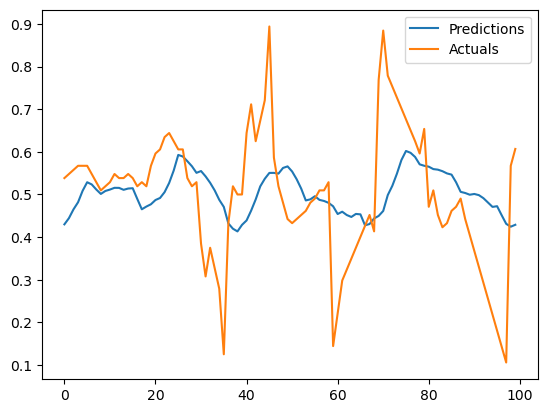

MAPE: 896010804.0217874
MSE for Predictions: 0.0393580627296342
MAE:  0.15596585


In [176]:
plot_predictions2(model14, X_test, Y_test)

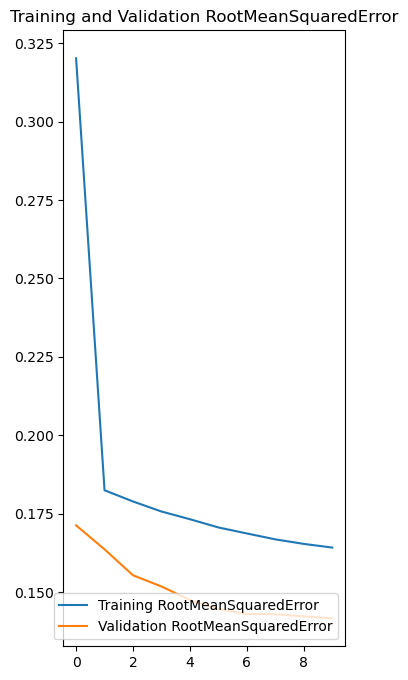

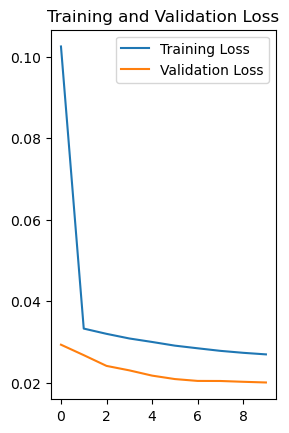

In [177]:
pltGraph(Model14, 10)

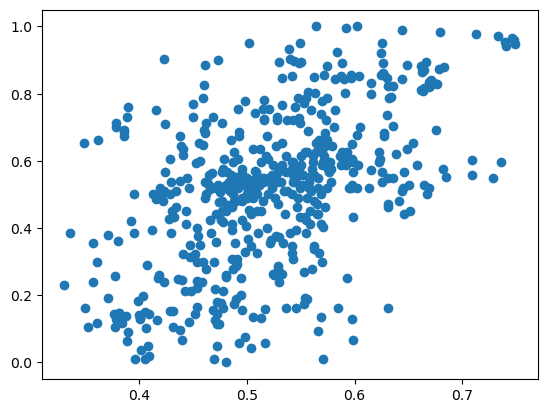

In [178]:
plt.scatter(Ypredd, Y_test)

In [14]:
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((3262, 7, 14), (3262,), (537, 7, 14), (537,), (537, 7, 14), (537,))

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Conv2D, MaxPooling2D, Flatten, Dense, Reshape

# Create the Sequential model
# model15 = Sequential()

# model15.add(InputLayer((7, 16)))
# # 1D CNN layers
# model15.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same', input_shape=(7, 16)))
# model15.add(MaxPooling1D(pool_size=2, padding='same'))
# model15.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
# model15.add(MaxPooling1D(pool_size=2, padding='same'))
# model15.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
# model15.add(MaxPooling1D(pool_size=2, padding='same'))
# model15.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))

# # LSTM layers
# model15.add(LSTM(units=64, return_sequences=True))
# model15.add(LSTM(units=64, return_sequences=True))
# model15.add(LSTM(units=64, return_sequences=True))

# # Reshape for 2D CNN layer
# model15.add(Reshape((64, 1, 1)))  # reshape to (batch_size, 64, 1, 1)

# # 2D CNN layers
# model15.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
# model15.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# model15.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
# model15.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# # Flatten layer
# model15.add(Flatten())

# # Output layer
# model15.add(Dense(units=1, activation='linear'))




model15 = Sequential()

model15.add(InputLayer((7, 14)))
# 1D CNN layers
model15.add(Conv1D(filters=32, kernel_size=3, activation='tanh', padding='same', input_shape=(7, 16)))
model15.add(Conv1D(filters=64, kernel_size=3, activation='tanh', padding='same'))


# LSTM layers
model15.add(LSTM(units=64, return_sequences=False))

# Reshape for 2D CNN layer
model15.add(Reshape((64, 1, 1)))  # reshape to (batch_size, 64, 1, 1)

# 2D CNN layers
model15.add(Conv2D(filters=32, kernel_size=(3, 3), activation='tanh', padding='same'))

model15.add(Conv2D(filters=64, kernel_size=(3, 3), activation='tanh', padding='same'))

# Flatten layer
model15.add(Flatten())

# Output layer
model15.add(Dense(units=1, activation='linear'))

# Display model summary
model15.summary()


2024-04-25 18:37:53.032068: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-25 18:37:53.032123: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-25 18:37:53.032137: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-25 18:37:53.032238: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-25 18:37:53.032305: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 32)             1376      
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             6208      
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 reshape (Reshape)           (None, 64, 1, 1)          0         
                                                                 
 conv2d (Conv2D)             (None, 64, 1, 32)         320       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 1, 64)         18496     
                                                                 
 flatten (Flatten)           (None, 4096)              0

In [183]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

cp15 = ModelCheckpoint('model/model15/', save_best_only=True)
model15.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
Model15 = model15.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=10, callbacks=[cp15])

Epoch 1/10
102/102 [==============================] - ETA: 0s - loss: 0.1241 - root_mean_squared_error: 0.3522INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


102/102 [==============================] - 10s 71ms/step - loss: 0.1241 - root_mean_squared_error: 0.3522 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1503
Epoch 2/10
102/102 [==============================] - ETA: 0s - loss: 0.0312 - root_mean_squared_error: 0.1765INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


102/102 [==============================] - 3s 30ms/step - loss: 0.0312 - root_mean_squared_error: 0.1765 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1448
Epoch 3/10
102/102 [==============================] - ETA: 0s - loss: 0.0299 - root_mean_squared_error: 0.1730INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


102/102 [==============================] - 4s 35ms/step - loss: 0.0299 - root_mean_squared_error: 0.1730 - val_loss: 0.0201 - val_root_mean_squared_error: 0.1417
Epoch 4/10
101/102 [============================>.] - ETA: 0s - loss: 0.0277 - root_mean_squared_error: 0.1664INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


102/102 [==============================] - 3s 32ms/step - loss: 0.0276 - root_mean_squared_error: 0.1661 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1414
Epoch 5/10
100/102 [============================>.] - ETA: 0s - loss: 0.0246 - root_mean_squared_error: 0.1569INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


102/102 [==============================] - 3s 31ms/step - loss: 0.0247 - root_mean_squared_error: 0.1571 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1313
Epoch 6/10
100/102 [============================>.] - ETA: 0s - loss: 0.0221 - root_mean_squared_error: 0.1486INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


102/102 [==============================] - 3s 33ms/step - loss: 0.0220 - root_mean_squared_error: 0.1484 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1273
Epoch 7/10
102/102 [==============================] - ETA: 0s - loss: 0.0206 - root_mean_squared_error: 0.1436INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


102/102 [==============================] - 4s 39ms/step - loss: 0.0206 - root_mean_squared_error: 0.1436 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1244
Epoch 8/10
 99/102 [============================>.] - ETA: 0s - loss: 0.0196 - root_mean_squared_error: 0.1400INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


102/102 [==============================] - 3s 30ms/step - loss: 0.0195 - root_mean_squared_error: 0.1397 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1216
Epoch 9/10
100/102 [============================>.] - ETA: 0s - loss: 0.0186 - root_mean_squared_error: 0.1363INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


102/102 [==============================] - 3s 30ms/step - loss: 0.0186 - root_mean_squared_error: 0.1362 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183
Epoch 10/10
100/102 [============================>.] - ETA: 0s - loss: 0.0178 - root_mean_squared_error: 0.1335INFO:tensorflow:Assets written to: model/model15/assets


INFO:tensorflow:Assets written to: model/model15/assets


102/102 [==============================] - 4s 43ms/step - loss: 0.0178 - root_mean_squared_error: 0.1334 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1176


In [184]:
Ypred15=model15.predict(X_test)

17/17 [==============================] - 1s 19ms/step


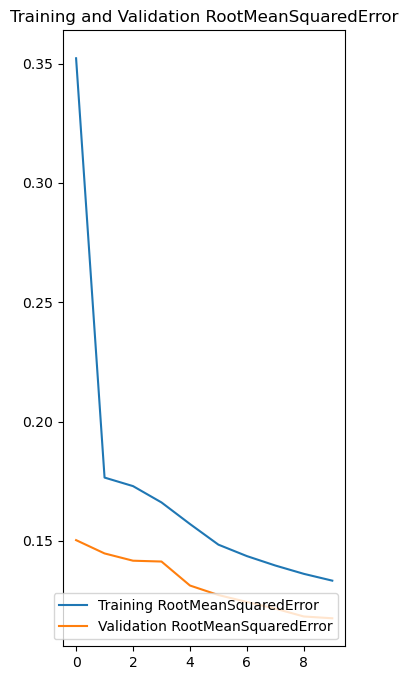

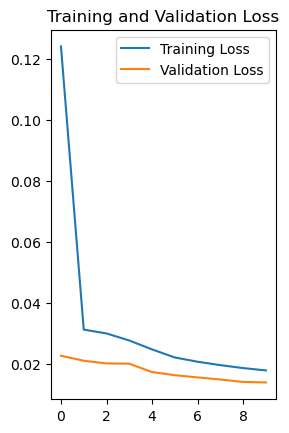

In [185]:
pltGraph(Model15, 10)

17/17 [==============================] - 0s 5ms/step


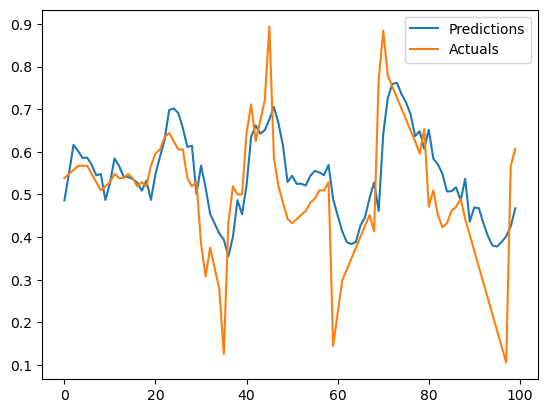

MAPE: 544963057.4405943
MSE for Predictions: 0.020109045013139603
MAE:  0.1052472


In [186]:
plot_predictions2(model15, X_test, Y_test)

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def pltMod(Model, Pred, Test):
    plt.figure(figsize=(8,6))

    plt.plot(Y_test)
    plt.plot(Y_pred)



    plt.xlabel('Time [Hour]',fontsize=16, fontweight='bold',fontfamily='serif')
    plt.ylabel('GHI',fontsize=16, fontweight='bold',fontfamily='serif')
    plt.title('Observed vs Predicted time series plot',fontsize=16, fontweight='bold',fontfamily='serif')
    plt.legend(['Observed','Predicted'])
    

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float64)
    y_pred = tf.cast(y_pred, dtype=tf.float64)
    
    epsilon = 1e-10
    y_true = tf.where(tf.equal(y_true, 0), y_true + epsilon, y_true)
    
    mape = tf.reduce_mean(tf.abs((y_true - y_pred) / y_true)) * 100
    
    return mape

def plot_predictions2(model, X, y, start=0, end=100):
    predictions = model.predict(X)
    target_preds = predictions[:, 0]  
    target_actuals = y        
    
    df = pd.DataFrame(data={'Predictions': target_preds, 'Actuals': target_actuals})
    plt.plot(df['Predictions'][start:end], label='Predictions')
    plt.plot(df['Actuals'][start:end], label='Actuals')
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(target_actuals, target_preds)
    mae = tf.keras.metrics.mean_absolute_error(target_actuals, target_preds).numpy()
    r_squared = r2_score(target_actuals, target_preds)
    
    print("MSE for Predictions:", mse)
    print("MAE: ", mae)
    print("r_squared error: ", r_squared)
    print(df[58:110])
    
    
def pltGraph(Model, i):
    RootMeanSquaredError = Model.history['root_mean_squared_error']
    val_RootMeanSquaredError = Model.history['val_root_mean_squared_error']
    loss = Model.history['loss'] 
    val_loss = Model.history['val_loss']
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(i), RootMeanSquaredError, label='Training RootMeanSquaredError') 
    plt.plot(range(i), val_RootMeanSquaredError, label='Validation RootMeanSquaredError') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation RootMeanSquaredError')
    plt.show()

    plt.subplot(1, 2, 2)
    plt.plot(range(i), loss, label='Training Loss') 
    plt.plot(range(i), val_loss, label='Validation Loss') 
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()

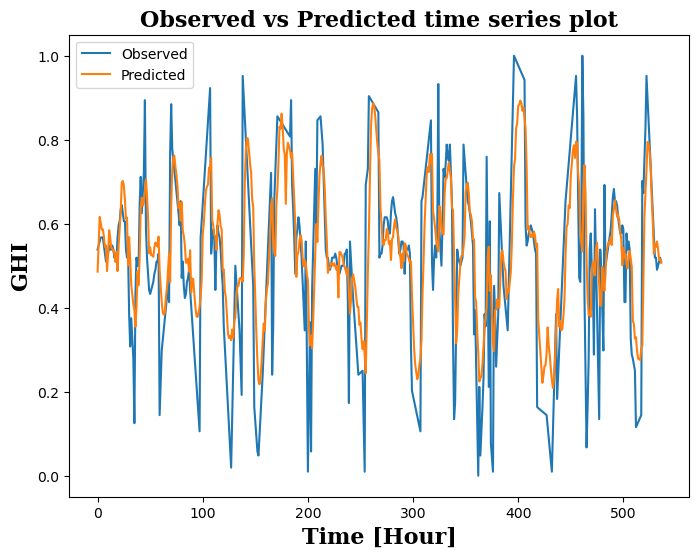

In [187]:
plt.figure(figsize=(8,6))

plt.plot(Y_test)
plt.plot(Ypred15)



plt.xlabel('Time [Hour]',fontsize=16, fontweight='bold',fontfamily='serif')
plt.ylabel('GHI',fontsize=16, fontweight='bold',fontfamily='serif')
plt.title('Observed vs Predicted time series plot',fontsize=16, fontweight='bold',fontfamily='serif')
plt.legend(['Observed','Predicted'])

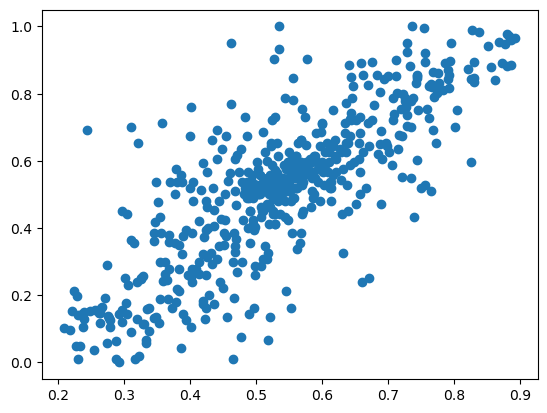

In [188]:
plt.scatter(Ypred15, Y_test)

In [16]:
from tensorflow.keras.losses import Huber

model = Sequential()

model.add(Conv1D(filters=128,  kernel_size= 1, activation='tanh',padding='same',input_shape=(7,14)))
# model.add(MaxPooling1D(pool_size=1, padding='same'))
model.add(LSTM(units=256, return_sequences=True,activation='tanh'))

model.add(Dropout(0.5))

model.add(Conv1D(filters=64,  kernel_size= 1, activation='tanh',padding='same',input_shape=(7,14)))
# model.add(MaxPooling1D(pool_size=1, padding='same'))
model.add(LSTM(units=128, return_sequences=True,activation='tanh'))

model.add(Dropout(0.4))

model.add(Conv1D(filters=32,  kernel_size= 1, activation='tanh',padding='same',input_shape=(7,14)))
# model.add(MaxPooling1D(pool_size=1, padding='same'))
model.add(LSTM(units=64, return_sequences=False,activation='tanh'))


model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 7, 128)            1920      
                                                                 
 lstm_1 (LSTM)               (None, 7, 256)            394240    
                                                                 
 dropout (Dropout)           (None, 7, 256)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 64)             16448     
                                                                 
 lstm_2 (LSTM)               (None, 7, 128)            98816     
                                                                 
 dropout_1 (Dropout)         (None, 7, 128)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 7, 32)            

In [193]:
cp21 = ModelCheckpoint('models/model21_10win_all/', save_best_only=True)
model.compile(loss=Huber(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(),'mse', 'mae'])

In [194]:
Model = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=5, callbacks=[cp21])

Epoch 1/5
102/102 [==============================] - ETA: 0s - loss: 0.0311 - root_mean_squared_error: 0.2494 - mse: 0.0622 - mae: 0.1855INFO:tensorflow:Assets written to: models/model21_10win_all/assets


INFO:tensorflow:Assets written to: models/model21_10win_all/assets


102/102 [==============================] - 15s 102ms/step - loss: 0.0311 - root_mean_squared_error: 0.2494 - mse: 0.0622 - mae: 0.1855 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1520 - val_mse: 0.0231 - val_mae: 0.1065
Epoch 2/5
102/102 [==============================] - ETA: 0s - loss: 0.0156 - root_mean_squared_error: 0.1765 - mse: 0.0312 - mae: 0.1298INFO:tensorflow:Assets written to: models/model21_10win_all/assets


INFO:tensorflow:Assets written to: models/model21_10win_all/assets


102/102 [==============================] - 7s 72ms/step - loss: 0.0156 - root_mean_squared_error: 0.1765 - mse: 0.0312 - mae: 0.1298 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1448 - val_mse: 0.0210 - val_mae: 0.0948
Epoch 3/5
101/102 [============================>.] - ETA: 0s - loss: 0.0151 - root_mean_squared_error: 0.1738 - mse: 0.0302 - mae: 0.1277INFO:tensorflow:Assets written to: models/model21_10win_all/assets


INFO:tensorflow:Assets written to: models/model21_10win_all/assets


102/102 [==============================] - 9s 87ms/step - loss: 0.0151 - root_mean_squared_error: 0.1738 - mse: 0.0302 - mae: 0.1277 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1437 - val_mse: 0.0206 - val_mae: 0.0952
Epoch 4/5
102/102 [==============================] - 3s 24ms/step - loss: 0.0141 - root_mean_squared_error: 0.1680 - mse: 0.0282 - mae: 0.1218 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1466 - val_mse: 0.0215 - val_mae: 0.1010
Epoch 5/5
102/102 [==============================] - ETA: 0s - loss: 0.0138 - root_mean_squared_error: 0.1663 - mse: 0.0277 - mae: 0.1193INFO:tensorflow:Assets written to: models/model21_10win_all/assets


INFO:tensorflow:Assets written to: models/model21_10win_all/assets


102/102 [==============================] - 7s 68ms/step - loss: 0.0138 - root_mean_squared_error: 0.1663 - mse: 0.0277 - mae: 0.1193 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1412 - val_mse: 0.0199 - val_mae: 0.0949


In [195]:
Ypred21=model.predict(X_test)

17/17 [==============================] - 1s 19ms/step


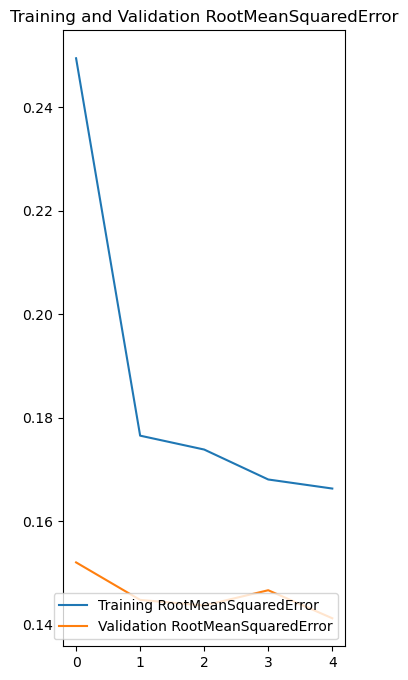

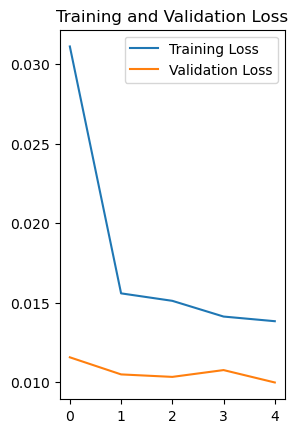

In [196]:
pltGraph(Model, 5)

17/17 [==============================] - 0s 8ms/step


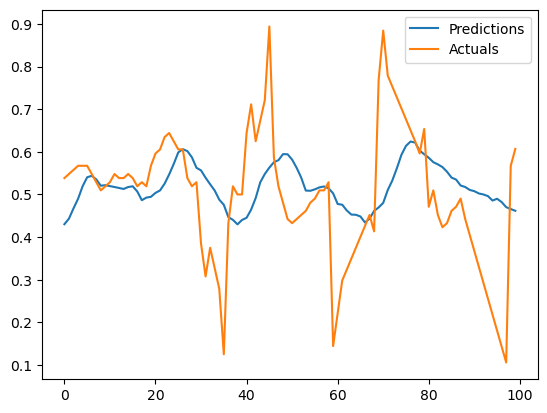

MAPE: 866189890.3542202
MSE for Predictions: 0.03969099187882264
MAE:  0.15668836


In [197]:
plot_predictions2(model, X_test, Y_test)

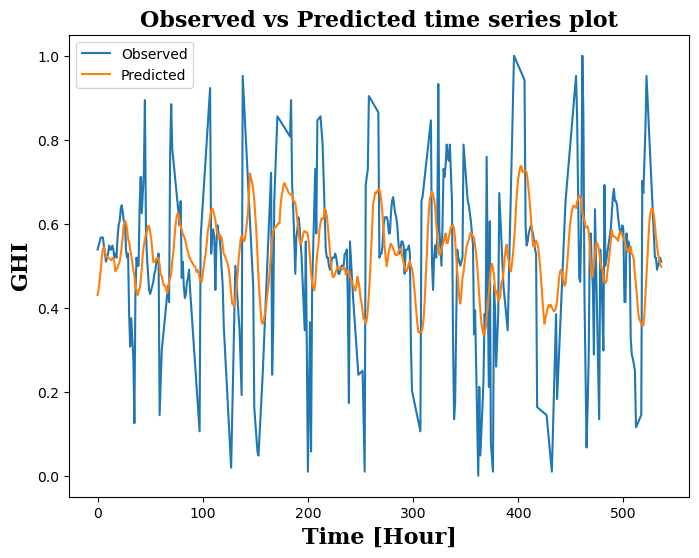

In [198]:
plt.figure(figsize=(8,6))

plt.plot(Y_test)
plt.plot(Ypred21)



plt.xlabel('Time [Hour]',fontsize=16, fontweight='bold',fontfamily='serif')
plt.ylabel('GHI',fontsize=16, fontweight='bold',fontfamily='serif')
plt.title('Observed vs Predicted time series plot',fontsize=16, fontweight='bold',fontfamily='serif')
plt.legend(['Observed','Predicted'])

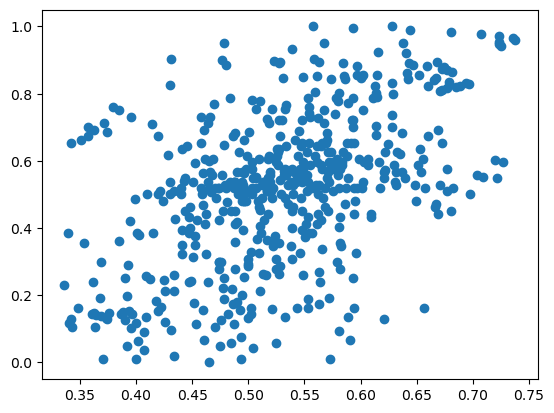

In [199]:
plt.scatter(Ypred21, Y_test)

In [17]:
from joblib import dump, load

In [17]:
model22 = Sequential()
model22.add(InputLayer((7, 14)))
model22.add(LSTM(128))
model22.add(Dense(8, 'relu'))
model22.add(Dense(1, 'linear'))

model22.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               73216     
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 74257 (290.07 KB)
Trainable params: 74257 (290.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
cp22 = ModelCheckpoint('models/model22_15win/', save_best_only=True)
model22.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
Model22 = model22.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, callbacks=[cp22])


Epoch 1/30


2024-04-25 18:38:25.011937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


102/102 [==============================] - ETA: 0s - loss: 0.0454 - root_mean_squared_error: 0.2132INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 4s 30ms/step - loss: 0.0454 - root_mean_squared_error: 0.2132 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1457
Epoch 2/30
102/102 [==============================] - ETA: 0s - loss: 0.0273 - root_mean_squared_error: 0.1653INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 32ms/step - loss: 0.0273 - root_mean_squared_error: 0.1653 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1387
Epoch 3/30
 97/102 [===========================>..] - ETA: 0s - loss: 0.0253 - root_mean_squared_error: 0.1592INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 27ms/step - loss: 0.0252 - root_mean_squared_error: 0.1589 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1349
Epoch 4/30
101/102 [============================>.] - ETA: 0s - loss: 0.0235 - root_mean_squared_error: 0.1533INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 28ms/step - loss: 0.0236 - root_mean_squared_error: 0.1535 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1328
Epoch 5/30
 99/102 [============================>.] - ETA: 0s - loss: 0.0226 - root_mean_squared_error: 0.1503INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 27ms/step - loss: 0.0225 - root_mean_squared_error: 0.1499 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1288
Epoch 6/30
100/102 [============================>.] - ETA: 0s - loss: 0.0216 - root_mean_squared_error: 0.1469INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 26ms/step - loss: 0.0218 - root_mean_squared_error: 0.1476 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1273
Epoch 7/30
100/102 [============================>.] - ETA: 0s - loss: 0.0208 - root_mean_squared_error: 0.1441INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 28ms/step - loss: 0.0207 - root_mean_squared_error: 0.1440 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1255
Epoch 8/30
100/102 [============================>.] - ETA: 0s - loss: 0.0202 - root_mean_squared_error: 0.1422INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 25ms/step - loss: 0.0201 - root_mean_squared_error: 0.1419 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1232
Epoch 9/30
101/102 [============================>.] - ETA: 0s - loss: 0.0194 - root_mean_squared_error: 0.1392INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 28ms/step - loss: 0.0193 - root_mean_squared_error: 0.1390 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1213
Epoch 10/30
102/102 [==============================] - ETA: 0s - loss: 0.0187 - root_mean_squared_error: 0.1369INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 32ms/step - loss: 0.0187 - root_mean_squared_error: 0.1369 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1198
Epoch 11/30
101/102 [============================>.] - ETA: 0s - loss: 0.0181 - root_mean_squared_error: 0.1346INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 33ms/step - loss: 0.0181 - root_mean_squared_error: 0.1346 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1174
Epoch 12/30
101/102 [============================>.] - ETA: 0s - loss: 0.0175 - root_mean_squared_error: 0.1323INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 34ms/step - loss: 0.0176 - root_mean_squared_error: 0.1325 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1170
Epoch 13/30
102/102 [==============================] - ETA: 0s - loss: 0.0170 - root_mean_squared_error: 0.1302INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 4s 36ms/step - loss: 0.0170 - root_mean_squared_error: 0.1302 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144
Epoch 14/30
100/102 [============================>.] - ETA: 0s - loss: 0.0167 - root_mean_squared_error: 0.1293INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 30ms/step - loss: 0.0166 - root_mean_squared_error: 0.1287 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 15/30
101/102 [============================>.] - ETA: 0s - loss: 0.0162 - root_mean_squared_error: 0.1273INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 34ms/step - loss: 0.0162 - root_mean_squared_error: 0.1275 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 16/30
102/102 [==============================] - 1s 11ms/step - loss: 0.0158 - root_mean_squared_error: 0.1258 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 17/30
101/102 [============================>.] - ETA: 0s - loss: 0.0155 - root_mean_squared_error: 0.1244INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 31ms/step - loss: 0.0155 - root_mean_squared_error: 0.1245 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105
Epoch 18/30
100/102 [============================>.] - ETA: 0s - loss: 0.0152 - root_mean_squared_error: 0.1232INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 26ms/step - loss: 0.0153 - root_mean_squared_error: 0.1236 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 19/30
102/102 [==============================] - ETA: 0s - loss: 0.0151 - root_mean_squared_error: 0.1231INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 26ms/step - loss: 0.0151 - root_mean_squared_error: 0.1231 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1086
Epoch 20/30
 97/102 [===========================>..] - ETA: 0s - loss: 0.0151 - root_mean_squared_error: 0.1227INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 2s 25ms/step - loss: 0.0152 - root_mean_squared_error: 0.1234 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 21/30
102/102 [==============================] - 1s 10ms/step - loss: 0.0150 - root_mean_squared_error: 0.1223 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 22/30
 97/102 [===========================>..] - ETA: 0s - loss: 0.0142 - root_mean_squared_error: 0.1192INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 33ms/step - loss: 0.0146 - root_mean_squared_error: 0.1210 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 23/30
101/102 [============================>.] - ETA: 0s - loss: 0.0146 - root_mean_squared_error: 0.1208INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 26ms/step - loss: 0.0145 - root_mean_squared_error: 0.1205 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1070
Epoch 24/30
102/102 [==============================] - ETA: 0s - loss: 0.0145 - root_mean_squared_error: 0.1206INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 2s 25ms/step - loss: 0.0145 - root_mean_squared_error: 0.1206 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 25/30
 97/102 [===========================>..] - ETA: 0s - loss: 0.0142 - root_mean_squared_error: 0.1191INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 29ms/step - loss: 0.0142 - root_mean_squared_error: 0.1193 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1063
Epoch 26/30
 99/102 [============================>.] - ETA: 0s - loss: 0.0144 - root_mean_squared_error: 0.1201INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 28ms/step - loss: 0.0143 - root_mean_squared_error: 0.1198 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1056
Epoch 27/30
102/102 [==============================] - 2s 16ms/step - loss: 0.0143 - root_mean_squared_error: 0.1196 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1056
Epoch 28/30
101/102 [============================>.] - ETA: 0s - loss: 0.0143 - root_mean_squared_error: 0.1194INFO:tensorflow:Assets written to: models/model22_15win/assets


INFO:tensorflow:Assets written to: models/model22_15win/assets


102/102 [==============================] - 3s 33ms/step - loss: 0.0142 - root_mean_squared_error: 0.1192 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1055
Epoch 29/30
102/102 [==============================] - 1s 14ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1058
Epoch 30/30
102/102 [==============================] - 1s 14ms/step - loss: 0.0143 - root_mean_squared_error: 0.1196 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068


17/17 [==============================] - 0s 4ms/step


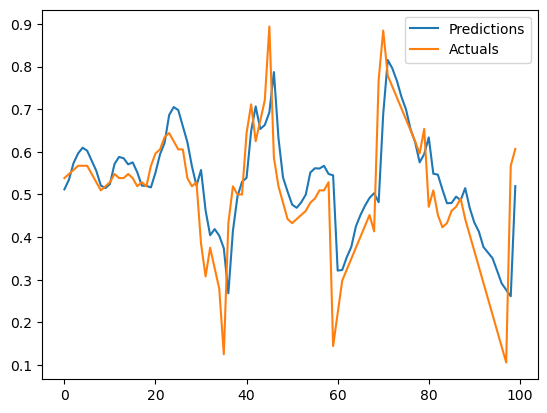

MSE for Predictions: 0.015901747589132233
MAE:  0.08873899
r_squared error:  0.6945263966065426
     Predictions   Actuals
58      0.548185  0.528846
59      0.544860  0.144231
60      0.321429  0.221154
61      0.322828  0.298077
62      0.352934  0.323718
63      0.377175  0.349359
64      0.424998  0.375000
65      0.451713  0.400641
66      0.473698  0.426282
67      0.491888  0.451923
68      0.503035  0.413462
69      0.481793  0.769231
70      0.688930  0.884615
71      0.815683  0.778846
72      0.795888  0.753205
73      0.766705  0.727564
74      0.729231  0.701923
75      0.699744  0.676282
76      0.653037  0.650641
77      0.623025  0.625000
78      0.575371  0.596154
79      0.594795  0.653846
80      0.633871  0.471154
81      0.548753  0.509615
82      0.546527  0.451923
83      0.511634  0.423077
84      0.479558  0.432692
85      0.479971  0.461538
86      0.494958  0.471154
87      0.486511  0.490385
88      0.514914  0.442308
89      0.468192  0.404915
90      0.434

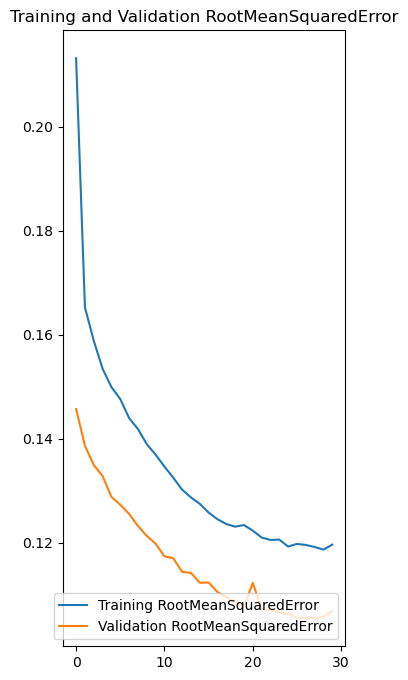

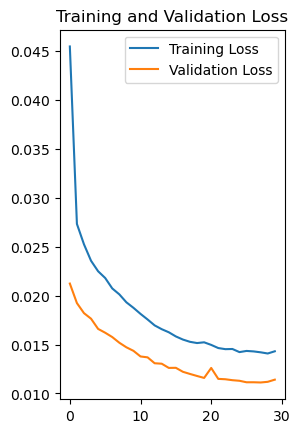

In [20]:
Ypred22=model22.predict(X_test)
plot_predictions2(model22, X_test, Y_test)
pltGraph(Model22, 30)


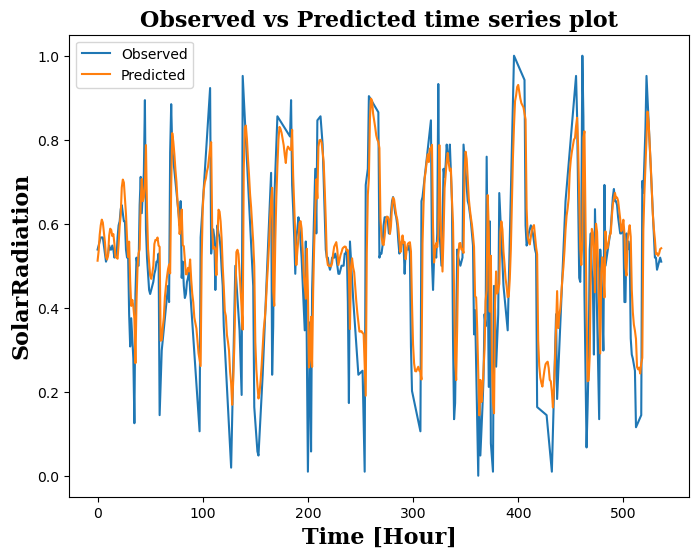

In [21]:
plt.figure(figsize=(8,6))

plt.plot(Y_test)
plt.plot(Ypred22)



plt.xlabel('Time [Hour]',fontsize=16, fontweight='bold',fontfamily='serif')
plt.ylabel('SolarRadiation',fontsize=16, fontweight='bold',fontfamily='serif')
plt.title('Observed vs Predicted time series plot',fontsize=16, fontweight='bold',fontfamily='serif')
plt.legend(['Observed','Predicted'])

Text(0, 0.5, 'Prediction')

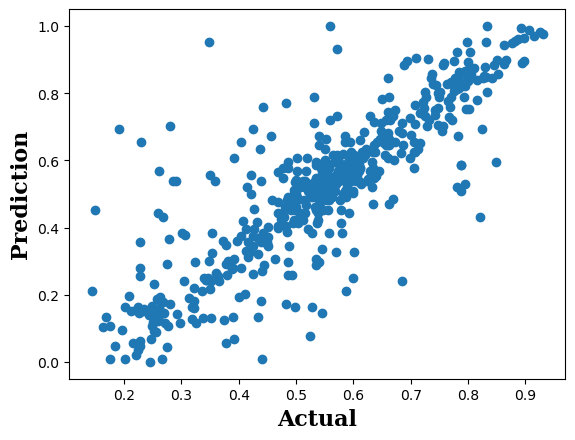

In [22]:
plt.scatter(Ypred22, Y_test)
plt.xlabel('Actual',fontsize=16, fontweight='bold',fontfamily='serif')
plt.ylabel('Prediction',fontsize=16, fontweight='bold',fontfamily='serif')

In [23]:
cp15 = ModelCheckpoint('model/model15_40eps/', save_best_only=True)
model15.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
Model15 = model15.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, callbacks=[cp15])

Epoch 1/40
102/102 [==============================] - ETA: 0s - loss: 0.0780 - root_mean_squared_error: 0.2792INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 5s 38ms/step - loss: 0.0780 - root_mean_squared_error: 0.2792 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1498
Epoch 2/40
101/102 [============================>.] - ETA: 0s - loss: 0.0316 - root_mean_squared_error: 0.1778INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 33ms/step - loss: 0.0316 - root_mean_squared_error: 0.1779 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1440
Epoch 3/40
 99/102 [============================>.] - ETA: 0s - loss: 0.0289 - root_mean_squared_error: 0.1699INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 31ms/step - loss: 0.0288 - root_mean_squared_error: 0.1696 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1377
Epoch 4/40
101/102 [============================>.] - ETA: 0s - loss: 0.0255 - root_mean_squared_error: 0.1598INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 33ms/step - loss: 0.0255 - root_mean_squared_error: 0.1598 - val_loss: 0.0184 - val_root_mean_squared_error: 0.1356
Epoch 5/40
102/102 [==============================] - ETA: 0s - loss: 0.0232 - root_mean_squared_error: 0.1522INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 4s 36ms/step - loss: 0.0232 - root_mean_squared_error: 0.1522 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1296
Epoch 6/40
101/102 [============================>.] - ETA: 0s - loss: 0.0219 - root_mean_squared_error: 0.1480INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 4s 38ms/step - loss: 0.0219 - root_mean_squared_error: 0.1479 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1278
Epoch 7/40
 98/102 [===========================>..] - ETA: 0s - loss: 0.0210 - root_mean_squared_error: 0.1451INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 30ms/step - loss: 0.0211 - root_mean_squared_error: 0.1452 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1245
Epoch 8/40
 99/102 [============================>.] - ETA: 0s - loss: 0.0198 - root_mean_squared_error: 0.1406INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 30ms/step - loss: 0.0197 - root_mean_squared_error: 0.1405 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1210
Epoch 9/40
102/102 [==============================] - ETA: 0s - loss: 0.0185 - root_mean_squared_error: 0.1361INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 32ms/step - loss: 0.0185 - root_mean_squared_error: 0.1361 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1174
Epoch 10/40
 99/102 [============================>.] - ETA: 0s - loss: 0.0180 - root_mean_squared_error: 0.1343INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 30ms/step - loss: 0.0179 - root_mean_squared_error: 0.1339 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1170
Epoch 11/40
 99/102 [============================>.] - ETA: 0s - loss: 0.0164 - root_mean_squared_error: 0.1282INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 30ms/step - loss: 0.0165 - root_mean_squared_error: 0.1285 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1131
Epoch 12/40
 99/102 [============================>.] - ETA: 0s - loss: 0.0164 - root_mean_squared_error: 0.1280INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 29ms/step - loss: 0.0162 - root_mean_squared_error: 0.1273 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1123
Epoch 13/40
102/102 [==============================] - 1s 11ms/step - loss: 0.0160 - root_mean_squared_error: 0.1266 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 14/40
102/102 [==============================] - ETA: 0s - loss: 0.0155 - root_mean_squared_error: 0.1247INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 30ms/step - loss: 0.0155 - root_mean_squared_error: 0.1247 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 15/40
 98/102 [===========================>..] - ETA: 0s - loss: 0.0155 - root_mean_squared_error: 0.1244INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 28ms/step - loss: 0.0154 - root_mean_squared_error: 0.1239 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 16/40
101/102 [============================>.] - ETA: 0s - loss: 0.0149 - root_mean_squared_error: 0.1221INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 27ms/step - loss: 0.0149 - root_mean_squared_error: 0.1221 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1080
Epoch 17/40
102/102 [==============================] - 1s 11ms/step - loss: 0.0148 - root_mean_squared_error: 0.1215 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 18/40
102/102 [==============================] - 1s 11ms/step - loss: 0.0146 - root_mean_squared_error: 0.1208 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1085
Epoch 19/40
102/102 [==============================] - 1s 11ms/step - loss: 0.0146 - root_mean_squared_error: 0.1206 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1088
Epoch 20/40
101/102 [============================>.] - ETA: 0s - loss: 0.0142 - root_mean_squared_error: 0.1192INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 30ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1051
Epoch 21/40
102/102 [==============================] - 1s 11ms/step - loss: 0.0146 - root_mean_squared_error: 0.1208 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 22/40
102/102 [==============================] - 1s 11ms/step - loss: 0.0141 - root_mean_squared_error: 0.1187 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1070
Epoch 23/40
 99/102 [============================>.] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.1178INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 27ms/step - loss: 0.0139 - root_mean_squared_error: 0.1177 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1042
Epoch 24/40
 99/102 [============================>.] - ETA: 0s - loss: 0.0136 - root_mean_squared_error: 0.1166INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 29ms/step - loss: 0.0138 - root_mean_squared_error: 0.1174 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 25/40
101/102 [============================>.] - ETA: 0s - loss: 0.0140 - root_mean_squared_error: 0.1181INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 27ms/step - loss: 0.0139 - root_mean_squared_error: 0.1180 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1037
Epoch 26/40
102/102 [==============================] - 1s 11ms/step - loss: 0.0137 - root_mean_squared_error: 0.1171 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 27/40
 99/102 [============================>.] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.1178INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 29ms/step - loss: 0.0138 - root_mean_squared_error: 0.1175 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 28/40
102/102 [==============================] - 1s 11ms/step - loss: 0.0135 - root_mean_squared_error: 0.1162 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1032
Epoch 29/40
102/102 [==============================] - 1s 11ms/step - loss: 0.0136 - root_mean_squared_error: 0.1164 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 30/40
100/102 [============================>.] - ETA: 0s - loss: 0.0134 - root_mean_squared_error: 0.1156INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 27ms/step - loss: 0.0134 - root_mean_squared_error: 0.1157 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1028
Epoch 31/40
102/102 [==============================] - 1s 11ms/step - loss: 0.0135 - root_mean_squared_error: 0.1160 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1044
Epoch 32/40
102/102 [==============================] - 1s 11ms/step - loss: 0.0132 - root_mean_squared_error: 0.1151 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1032
Epoch 33/40
 99/102 [============================>.] - ETA: 0s - loss: 0.0134 - root_mean_squared_error: 0.1159INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 27ms/step - loss: 0.0133 - root_mean_squared_error: 0.1154 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1026
Epoch 34/40
100/102 [============================>.] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.1155INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 29ms/step - loss: 0.0133 - root_mean_squared_error: 0.1155 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1023
Epoch 35/40
102/102 [==============================] - 1s 11ms/step - loss: 0.0132 - root_mean_squared_error: 0.1148 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1027
Epoch 36/40
102/102 [==============================] - 1s 11ms/step - loss: 0.0131 - root_mean_squared_error: 0.1144 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 37/40
102/102 [==============================] - 1s 11ms/step - loss: 0.0132 - root_mean_squared_error: 0.1147 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1046
Epoch 38/40
102/102 [==============================] - 1s 11ms/step - loss: 0.0131 - root_mean_squared_error: 0.1143 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1029
Epoch 39/40
102/102 [==============================] - 1s 11ms/step - loss: 0.0131 - root_mean_squared_error: 0.1144 - val_loss: 0.0107 - val_

INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 28ms/step - loss: 0.0131 - root_mean_squared_error: 0.1144 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1020


17/17 [==============================] - 0s 4ms/step


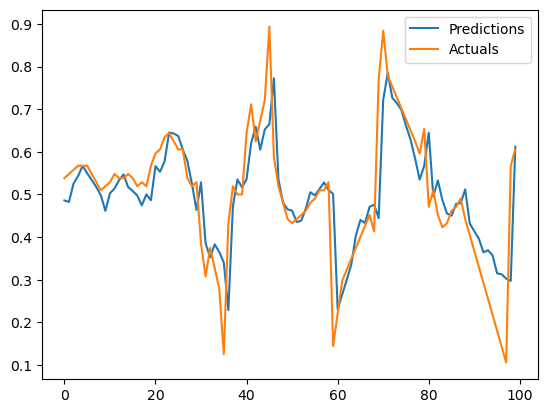

MSE for Predictions: 0.01485956779003757
MAE:  0.08592949
r_squared error:  0.7145467381966011
     Predictions   Actuals
58      0.510781  0.528846
59      0.500958  0.144231
60      0.230398  0.221154
61      0.265581  0.298077
62      0.299673  0.323718
63      0.336282  0.349359
64      0.404226  0.375000
65      0.440177  0.400641
66      0.433067  0.426282
67      0.470831  0.451923
68      0.476149  0.413462
69      0.444623  0.769231
70      0.721871  0.884615
71      0.785431  0.778846
72      0.726709  0.753205
73      0.714399  0.727564
74      0.698123  0.701923
75      0.661159  0.676282
76      0.629012  0.650641
77      0.584278  0.625000
78      0.534790  0.596154
79      0.567341  0.653846
80      0.644839  0.471154
81      0.495199  0.509615
82      0.532997  0.451923
83      0.486574  0.423077
84      0.455292  0.432692
85      0.450108  0.461538
86      0.478047  0.471154
87      0.479390  0.490385
88      0.512113  0.442308
89      0.432099  0.404915
90      0.4136

In [24]:
Ypred15n=model15.predict(X_test)
plot_predictions2(model15, X_test, Y_test)

Text(0, 0.5, 'Prediction')

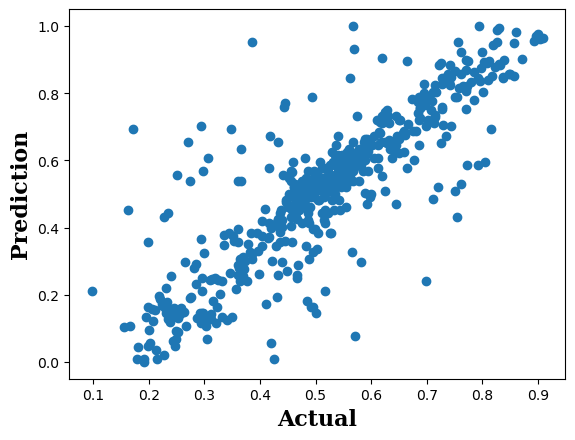

In [28]:
plt.scatter(Ypred15n, Y_test)
plt.xlabel('Actual',fontsize=16, fontweight='bold',fontfamily='serif')
plt.ylabel('Prediction',fontsize=16, fontweight='bold',fontfamily='serif')

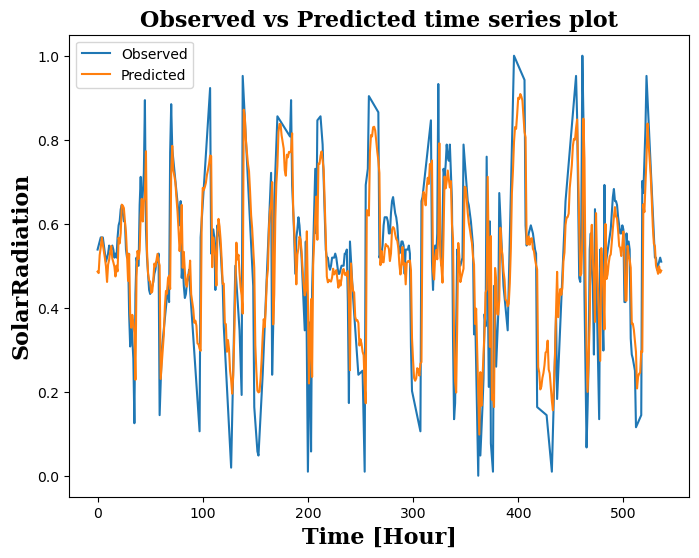

In [29]:
plt.figure(figsize=(8,6))

plt.plot(Y_test)
plt.plot(Ypred15n)



plt.xlabel('Time [Hour]',fontsize=16, fontweight='bold',fontfamily='serif')
plt.ylabel('SolarRadiation',fontsize=16, fontweight='bold',fontfamily='serif')
plt.title('Observed vs Predicted time series plot',fontsize=16, fontweight='bold',fontfamily='serif')
plt.legend(['Observed','Predicted'])

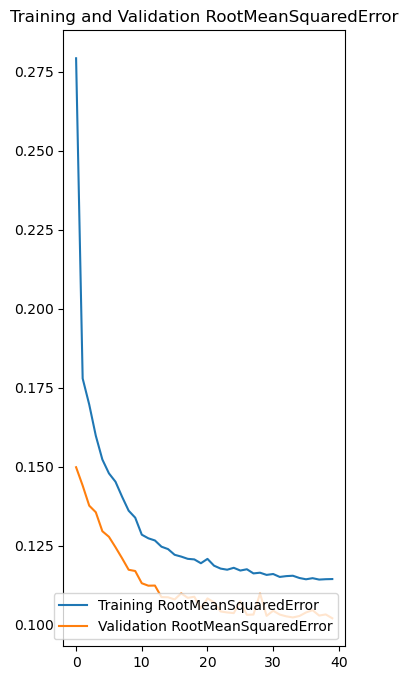

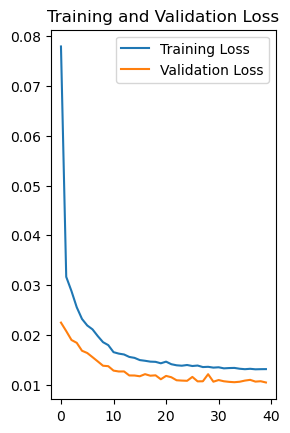

In [27]:
pltGraph(Model15, 40)

Epoch 1/30
102/102 [==============================] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.1099INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 7s 48ms/step - loss: 0.0121 - root_mean_squared_error: 0.1099 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1035
Epoch 2/30
102/102 [==============================] - 2s 17ms/step - loss: 0.0120 - root_mean_squared_error: 0.1094 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1055
Epoch 3/30
102/102 [==============================] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.1102INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 4s 37ms/step - loss: 0.0121 - root_mean_squared_error: 0.1102 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1035
Epoch 4/30
102/102 [==============================] - 1s 13ms/step - loss: 0.0119 - root_mean_squared_error: 0.1090 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1065
Epoch 5/30
101/102 [============================>.] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.1091INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 30ms/step - loss: 0.0118 - root_mean_squared_error: 0.1089 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1034
Epoch 6/30
102/102 [==============================] - 2s 16ms/step - loss: 0.0117 - root_mean_squared_error: 0.1082 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1035
Epoch 7/30
102/102 [==============================] - 1s 14ms/step - loss: 0.0117 - root_mean_squared_error: 0.1083 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 8/30
101/102 [============================>.] - ETA: 0s - loss: 0.0117 - root_mean_squared_error: 0.1082INFO:tensorflow:Assets written to: model/model15_40eps/assets


INFO:tensorflow:Assets written to: model/model15_40eps/assets


102/102 [==============================] - 3s 32ms/step - loss: 0.0118 - root_mean_squared_error: 0.1088 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1028
Epoch 9/30
102/102 [==============================] - 2s 16ms/step - loss: 0.0117 - root_mean_squared_error: 0.1081 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038
Epoch 10/30
102/102 [==============================] - 1s 12ms/step - loss: 0.0116 - root_mean_squared_error: 0.1077 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1034
Epoch 11/30
102/102 [==============================] - 1s 14ms/step - loss: 0.0118 - root_mean_squared_error: 0.1085 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1098
Epoch 12/30
102/102 [==============================] - 1s 13ms/step - loss: 0.0117 - root_mean_squared_error: 0.1081 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1055
Epoch 13/30
102/102 [==============================] - 1s 12ms/step - loss: 0.0116 - root_mean_squared_error: 0.1078 - val_loss: 0.0111 - val_r

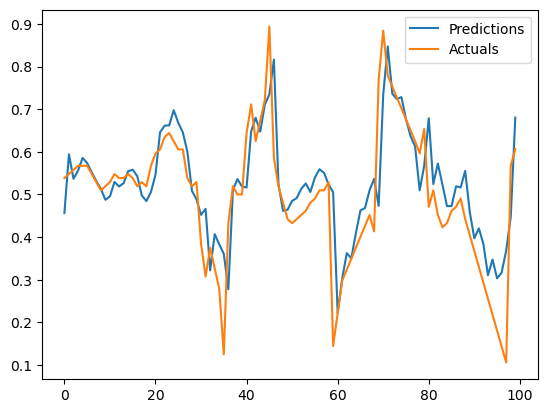

MAPE: 336567386.1412345
MSE for Predictions: 0.014693877902890066
MAE:  0.08315735


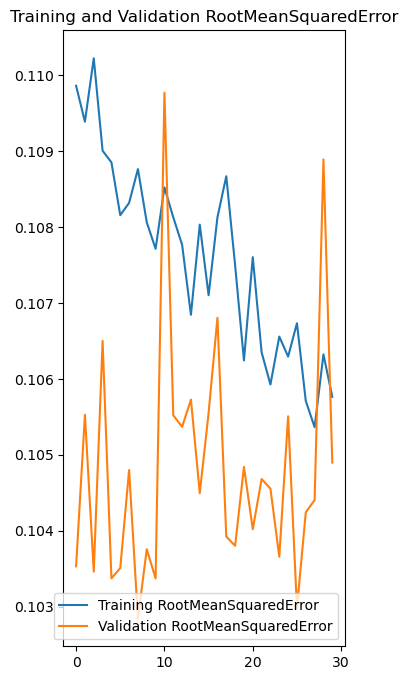

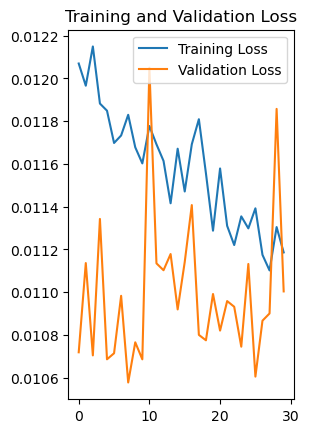

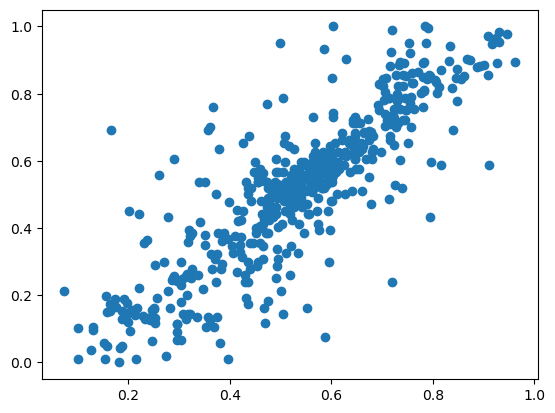

In [210]:
cp15 = ModelCheckpoint('model/model15_40eps/', save_best_only=True)
model15.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
Model15 = model15.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, callbacks=[cp15])

Ypred15n=model15.predict(X_test)
plot_predictions2(model15, X_test, Y_test)
pltGraph(Model15, 30)
plt.scatter(Ypred15n, Y_test)


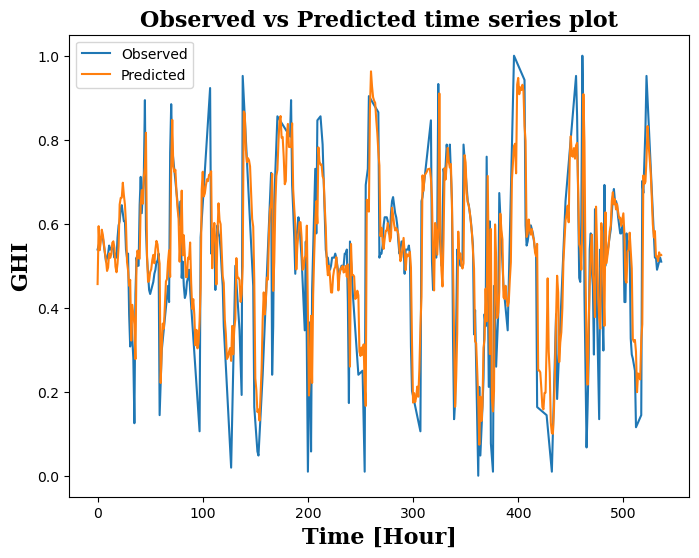

In [211]:
plt.figure(figsize=(8,6))

plt.plot(Y_test)
plt.plot(Ypred15n)



plt.xlabel('Time [Hour]',fontsize=16, fontweight='bold',fontfamily='serif')
plt.ylabel('GHI',fontsize=16, fontweight='bold',fontfamily='serif')
plt.title('Observed vs Predicted time series plot',fontsize=16, fontweight='bold',fontfamily='serif')
plt.legend(['Observed','Predicted'])

In [38]:
cp21n = ModelCheckpoint('models/model21_30eps/', save_best_only=True)
model.compile(loss=Huber(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(),'mse', 'mae'])
Model = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, callbacks=[cp21n])



Epoch 1/30
102/102 [==============================] - ETA: 0s - loss: 0.0065 - root_mean_squared_error: 0.1138 - mse: 0.0129 - mae: 0.0696INFO:tensorflow:Assets written to: models/model21_30eps/assets


INFO:tensorflow:Assets written to: models/model21_30eps/assets


102/102 [==============================] - 12s 82ms/step - loss: 0.0065 - root_mean_squared_error: 0.1138 - mse: 0.0129 - mae: 0.0696 - val_loss: 0.0050 - val_root_mean_squared_error: 0.1003 - val_mse: 0.0101 - val_mae: 0.0585
Epoch 2/30
102/102 [==============================] - 3s 32ms/step - loss: 0.0065 - root_mean_squared_error: 0.1137 - mse: 0.0129 - mae: 0.0695 - val_loss: 0.0052 - val_root_mean_squared_error: 0.1016 - val_mse: 0.0103 - val_mae: 0.0634
Epoch 3/30
102/102 [==============================] - 3s 30ms/step - loss: 0.0064 - root_mean_squared_error: 0.1132 - mse: 0.0128 - mae: 0.0693 - val_loss: 0.0053 - val_root_mean_squared_error: 0.1026 - val_mse: 0.0105 - val_mae: 0.0651
Epoch 4/30
101/102 [============================>.] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.1133 - mse: 0.0128 - mae: 0.0692INFO:tensorflow:Assets written to: models/model21_30eps/assets


INFO:tensorflow:Assets written to: models/model21_30eps/assets


102/102 [==============================] - 8s 76ms/step - loss: 0.0064 - root_mean_squared_error: 0.1131 - mse: 0.0128 - mae: 0.0690 - val_loss: 0.0050 - val_root_mean_squared_error: 0.1002 - val_mse: 0.0100 - val_mae: 0.0588
Epoch 5/30
102/102 [==============================] - 3s 29ms/step - loss: 0.0063 - root_mean_squared_error: 0.1124 - mse: 0.0126 - mae: 0.0686 - val_loss: 0.0050 - val_root_mean_squared_error: 0.1005 - val_mse: 0.0101 - val_mae: 0.0593
Epoch 6/30
102/102 [==============================] - 3s 33ms/step - loss: 0.0064 - root_mean_squared_error: 0.1128 - mse: 0.0127 - mae: 0.0690 - val_loss: 0.0051 - val_root_mean_squared_error: 0.1007 - val_mse: 0.0101 - val_mae: 0.0610
Epoch 7/30
102/102 [==============================] - 3s 27ms/step - loss: 0.0063 - root_mean_squared_error: 0.1122 - mse: 0.0126 - mae: 0.0681 - val_loss: 0.0053 - val_root_mean_squared_error: 0.1028 - val_mse: 0.0106 - val_mae: 0.0655
Epoch 8/30
102/102 [==============================] - 3s 31ms/s

INFO:tensorflow:Assets written to: models/model21_30eps/assets


102/102 [==============================] - 7s 73ms/step - loss: 0.0063 - root_mean_squared_error: 0.1124 - mse: 0.0126 - mae: 0.0686 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0995 - val_mse: 0.0099 - val_mae: 0.0580
Epoch 10/30
102/102 [==============================] - 2s 22ms/step - loss: 0.0063 - root_mean_squared_error: 0.1123 - mse: 0.0126 - mae: 0.0677 - val_loss: 0.0053 - val_root_mean_squared_error: 0.1028 - val_mse: 0.0106 - val_mae: 0.0653
Epoch 11/30
102/102 [==============================] - 2s 22ms/step - loss: 0.0063 - root_mean_squared_error: 0.1125 - mse: 0.0127 - mae: 0.0689 - val_loss: 0.0050 - val_root_mean_squared_error: 0.1003 - val_mse: 0.0101 - val_mae: 0.0597
Epoch 12/30
102/102 [==============================] - 2s 22ms/step - loss: 0.0063 - root_mean_squared_error: 0.1122 - mse: 0.0126 - mae: 0.0676 - val_loss: 0.0054 - val_root_mean_squared_error: 0.1037 - val_mse: 0.0108 - val_mae: 0.0676
Epoch 13/30
102/102 [==============================] - 2s 22

17/17 [==============================] - 0s 6ms/step


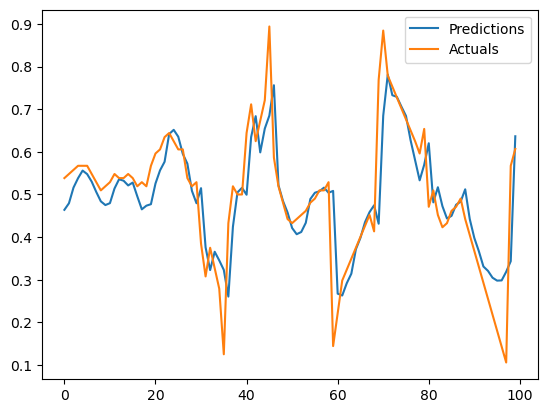

MSE for Predictions: 0.014632652523583646
MAE:  0.085506976
r_squared error:  0.7189057951945903
     Predictions   Actuals
58      0.504089  0.528846
59      0.508357  0.144231
60      0.267253  0.221154
61      0.262945  0.298077
62      0.291884  0.323718
63      0.314114  0.349359
64      0.371471  0.375000
65      0.398332  0.400641
66      0.434903  0.426282
67      0.458668  0.451923
68      0.474633  0.413462
69      0.431430  0.769231
70      0.684786  0.884615
71      0.781346  0.778846
72      0.732962  0.753205
73      0.729013  0.727564
74      0.706055  0.701923
75      0.684324  0.676282
76      0.627765  0.650641
77      0.580428  0.625000
78      0.533194  0.596154
79      0.569806  0.653846
80      0.620193  0.471154
81      0.481489  0.509615
82      0.516982  0.451923
83      0.472565  0.423077
84      0.443514  0.432692
85      0.449868  0.461538
86      0.475893  0.471154
87      0.483227  0.490385
88      0.512122  0.442308
89      0.442354  0.404915
90      0.39

In [39]:
Ypred21n=model.predict(X_test)
plot_predictions2(model, X_test, Y_test)


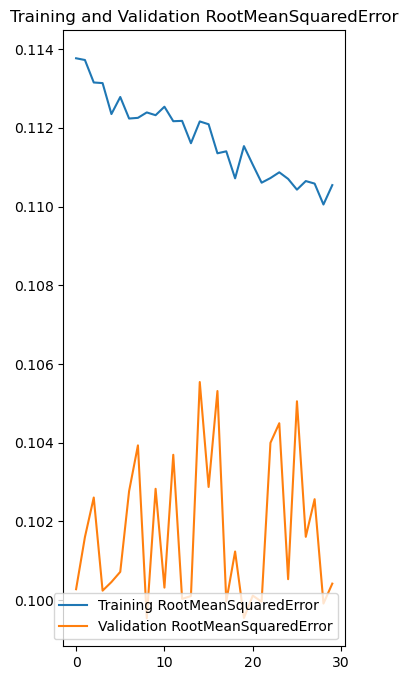

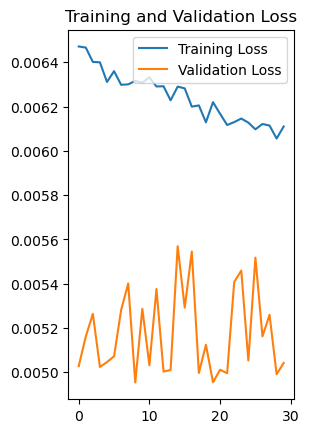

In [40]:
pltGraph(Model, 30)

Text(0, 0.5, 'Prediction')

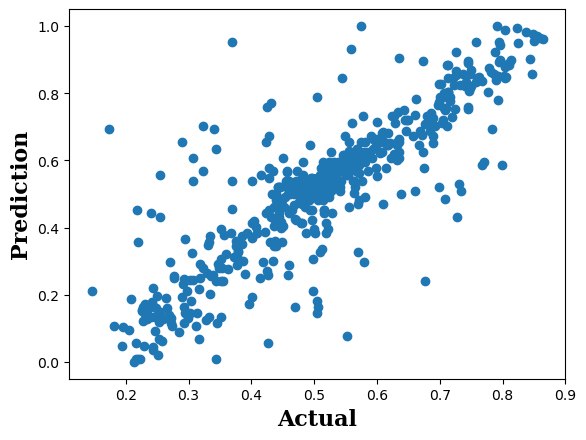

In [36]:
plt.scatter(Ypred21n, Y_test)
plt.xlabel('Actual',fontsize=16, fontweight='bold',fontfamily='serif')
plt.ylabel('Prediction',fontsize=16, fontweight='bold',fontfamily='serif')

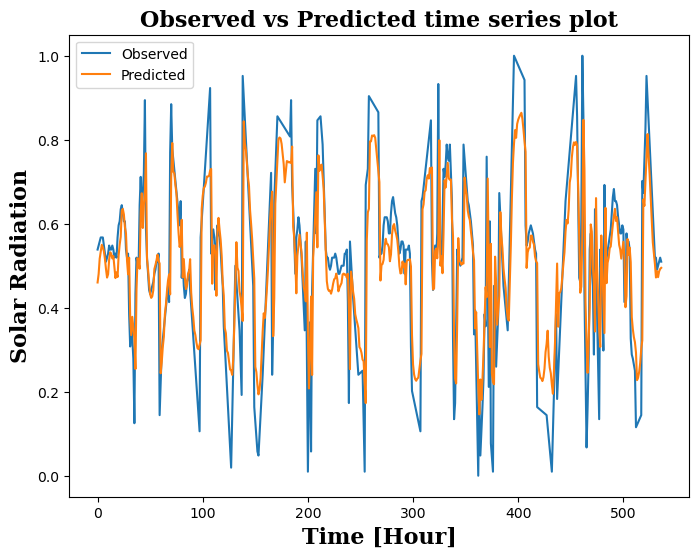

In [37]:
plt.figure(figsize=(8,6))

plt.plot(Y_test)
plt.plot(Ypred21n)



plt.xlabel('Time [Hour]',fontsize=16, fontweight='bold',fontfamily='serif')
plt.ylabel('Solar Radiation',fontsize=16, fontweight='bold',fontfamily='serif')
plt.title('Observed vs Predicted time series plot',fontsize=16, fontweight='bold',fontfamily='serif')
plt.legend(['Observed','Predicted'])

In [159]:
cp23 = ModelCheckpoint('models/model21_30epsss/', save_best_only=True)
model.compile(loss=Huber(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(),'mse', 'mae'])
Model = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, callbacks=[cp23])

Ypred21n=model.predict(X_test)
plot_predictions2(model, X_test, Y_test)
pltGraph(Model, 30)
plt.scatter(Ypred21n, Y_test)

Epoch 1/30
102/102 [==============================] - ETA: 0s - loss: 0.0293 - root_mean_squared_error: 0.2422 - mse: 0.0587 - mae: 0.1819INFO:tensorflow:Assets written to: models/model21_30epsss/assets


INFO:tensorflow:Assets written to: models/model21_30epsss/assets


102/102 [==============================] - 8s 52ms/step - loss: 0.0293 - root_mean_squared_error: 0.2422 - mse: 0.0587 - mae: 0.1819 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1492 - val_mse: 0.0223 - val_mae: 0.1002
Epoch 2/30
102/102 [==============================] - ETA: 0s - loss: 0.0156 - root_mean_squared_error: 0.1767 - mse: 0.0312 - mae: 0.1303INFO:tensorflow:Assets written to: models/model21_30epsss/assets


INFO:tensorflow:Assets written to: models/model21_30epsss/assets


102/102 [==============================] - 5s 45ms/step - loss: 0.0156 - root_mean_squared_error: 0.1767 - mse: 0.0312 - mae: 0.1303 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1458 - val_mse: 0.0213 - val_mae: 0.0971
Epoch 3/30
  1/102 [..............................] - ETA: 2s - loss: 0.0191 - root_mean_squared_error: 0.1954 - mse: 0.0382 - mae: 0.1451

KeyboardInterrupt: 

In [217]:
from tensorflow.keras.losses import Huber

model26 = Sequential()

model26.add(Conv1D(filters=128,  kernel_size= 2, activation='tanh',padding='same',input_shape=(7,14)))
# model.add(MaxPooling1D(pool_size=1, padding='same'))
model26.add(LSTM(units=256, return_sequences=True,activation='tanh'))

model26.add(Dropout(0.5))

model26.add(Conv1D(filters=64,  kernel_size= 2, activation='tanh',padding='same',input_shape=(7,14)))
# model.add(MaxPooling1D(pool_size=1, padding='same'))
model26.add(LSTM(units=128, return_sequences=True,activation='tanh'))

model26.add(Dropout(0.4))

model26.add(Conv1D(filters=32,  kernel_size= 2, activation='tanh',padding='same',input_shape=(7,14)))
# model.add(MaxPooling1D(pool_size=1, padding='same'))
model26.add(LSTM(units=64, return_sequences=True,activation='tanh'))

model26.add(Dropout(0.5))

model26.add(Conv1D(filters=16,  kernel_size= 2, activation='tanh',padding='same',input_shape=(7,14)))
# model.add(MaxPooling1D(pool_size=1, padding='same'))
model26.add(LSTM(units=64, return_sequences=False,activation='tanh'))

model26.add(Dense(1))

model26.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_66 (Conv1D)          (None, 7, 128)            3712      
                                                                 
 lstm_67 (LSTM)              (None, 7, 256)            394240    
                                                                 
 dropout_22 (Dropout)        (None, 7, 256)            0         
                                                                 
 conv1d_67 (Conv1D)          (None, 7, 64)             32832     
                                                                 
 lstm_68 (LSTM)              (None, 7, 128)            98816     
                                                                 
 dropout_23 (Dropout)        (None, 7, 128)            0         
                                                                 
 conv1d_68 (Conv1D)          (None, 7, 32)           

Epoch 1/30
102/102 [==============================] - ETA: 0s - loss: 0.0392 - root_mean_squared_error: 0.2800 - mse: 0.0784 - mae: 0.2103INFO:tensorflow:Assets written to: models/model26/assets


INFO:tensorflow:Assets written to: models/model26/assets


102/102 [==============================] - 23s 161ms/step - loss: 0.0392 - root_mean_squared_error: 0.2800 - mse: 0.0784 - mae: 0.2103 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1481 - val_mse: 0.0219 - val_mae: 0.0974
Epoch 2/30
102/102 [==============================] - ETA: 0s - loss: 0.0164 - root_mean_squared_error: 0.1811 - mse: 0.0328 - mae: 0.1334INFO:tensorflow:Assets written to: models/model26/assets


INFO:tensorflow:Assets written to: models/model26/assets


102/102 [==============================] - 9s 88ms/step - loss: 0.0164 - root_mean_squared_error: 0.1811 - mse: 0.0328 - mae: 0.1334 - val_loss: 0.0109 - val_root_mean_squared_error: 0.1476 - val_mse: 0.0218 - val_mae: 0.0953
Epoch 3/30
102/102 [==============================] - 3s 30ms/step - loss: 0.0157 - root_mean_squared_error: 0.1773 - mse: 0.0314 - mae: 0.1303 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1482 - val_mse: 0.0220 - val_mae: 0.0986
Epoch 4/30
102/102 [==============================] - 3s 31ms/step - loss: 0.0148 - root_mean_squared_error: 0.1718 - mse: 0.0295 - mae: 0.1255 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1530 - val_mse: 0.0234 - val_mae: 0.1118
Epoch 5/30
101/102 [============================>.] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.1681 - mse: 0.0282 - mae: 0.1212INFO:tensorflow:Assets written to: models/model26/assets


INFO:tensorflow:Assets written to: models/model26/assets


102/102 [==============================] - 10s 94ms/step - loss: 0.0142 - root_mean_squared_error: 0.1683 - mse: 0.0283 - mae: 0.1213 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1421 - val_mse: 0.0202 - val_mae: 0.0961
Epoch 6/30
102/102 [==============================] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.1658 - mse: 0.0275 - mae: 0.1201INFO:tensorflow:Assets written to: models/model26/assets


INFO:tensorflow:Assets written to: models/model26/assets


102/102 [==============================] - 13s 127ms/step - loss: 0.0137 - root_mean_squared_error: 0.1658 - mse: 0.0275 - mae: 0.1201 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1414 - val_mse: 0.0200 - val_mae: 0.0946
Epoch 7/30
102/102 [==============================] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.1625 - mse: 0.0264 - mae: 0.1164INFO:tensorflow:Assets written to: models/model26/assets


INFO:tensorflow:Assets written to: models/model26/assets


102/102 [==============================] - 11s 109ms/step - loss: 0.0132 - root_mean_squared_error: 0.1625 - mse: 0.0264 - mae: 0.1164 - val_loss: 0.0096 - val_root_mean_squared_error: 0.1385 - val_mse: 0.0192 - val_mae: 0.0934
Epoch 8/30
102/102 [==============================] - ETA: 0s - loss: 0.0126 - root_mean_squared_error: 0.1587 - mse: 0.0252 - mae: 0.1133INFO:tensorflow:Assets written to: models/model26/assets


INFO:tensorflow:Assets written to: models/model26/assets


102/102 [==============================] - 9s 86ms/step - loss: 0.0126 - root_mean_squared_error: 0.1587 - mse: 0.0252 - mae: 0.1133 - val_loss: 0.0091 - val_root_mean_squared_error: 0.1349 - val_mse: 0.0182 - val_mae: 0.0894
Epoch 9/30
102/102 [==============================] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.1540 - mse: 0.0237 - mae: 0.1096INFO:tensorflow:Assets written to: models/model26/assets


INFO:tensorflow:Assets written to: models/model26/assets


102/102 [==============================] - 9s 86ms/step - loss: 0.0119 - root_mean_squared_error: 0.1540 - mse: 0.0237 - mae: 0.1096 - val_loss: 0.0085 - val_root_mean_squared_error: 0.1303 - val_mse: 0.0170 - val_mae: 0.0862
Epoch 10/30
102/102 [==============================] - 3s 27ms/step - loss: 0.0115 - root_mean_squared_error: 0.1514 - mse: 0.0229 - mae: 0.1088 - val_loss: 0.0088 - val_root_mean_squared_error: 0.1325 - val_mse: 0.0175 - val_mae: 0.0923
Epoch 11/30
102/102 [==============================] - 3s 26ms/step - loss: 0.0105 - root_mean_squared_error: 0.1447 - mse: 0.0209 - mae: 0.1016 - val_loss: 0.0086 - val_root_mean_squared_error: 0.1310 - val_mse: 0.0172 - val_mae: 0.0906
Epoch 12/30
102/102 [==============================] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.1418 - mse: 0.0201 - mae: 0.0988INFO:tensorflow:Assets written to: models/model26/assets


INFO:tensorflow:Assets written to: models/model26/assets


102/102 [==============================] - 8s 84ms/step - loss: 0.0101 - root_mean_squared_error: 0.1418 - mse: 0.0201 - mae: 0.0988 - val_loss: 0.0076 - val_root_mean_squared_error: 0.1229 - val_mse: 0.0151 - val_mae: 0.0807
Epoch 13/30
102/102 [==============================] - 3s 26ms/step - loss: 0.0101 - root_mean_squared_error: 0.1422 - mse: 0.0202 - mae: 0.0995 - val_loss: 0.0080 - val_root_mean_squared_error: 0.1268 - val_mse: 0.0161 - val_mae: 0.0897
Epoch 14/30
102/102 [==============================] - 3s 26ms/step - loss: 0.0095 - root_mean_squared_error: 0.1381 - mse: 0.0191 - mae: 0.0955 - val_loss: 0.0084 - val_root_mean_squared_error: 0.1296 - val_mse: 0.0168 - val_mae: 0.0897
Epoch 15/30
102/102 [==============================] - 3s 26ms/step - loss: 0.0093 - root_mean_squared_error: 0.1363 - mse: 0.0186 - mae: 0.0936 - val_loss: 0.0097 - val_root_mean_squared_error: 0.1392 - val_mse: 0.0194 - val_mae: 0.1041
Epoch 16/30
102/102 [==============================] - 3s 25

INFO:tensorflow:Assets written to: models/model26/assets


102/102 [==============================] - 11s 104ms/step - loss: 0.0088 - root_mean_squared_error: 0.1329 - mse: 0.0177 - mae: 0.0896 - val_loss: 0.0071 - val_root_mean_squared_error: 0.1188 - val_mse: 0.0141 - val_mae: 0.0776
Epoch 18/30
102/102 [==============================] - ETA: 0s - loss: 0.0089 - root_mean_squared_error: 0.1331 - mse: 0.0177 - mae: 0.0912INFO:tensorflow:Assets written to: models/model26/assets


INFO:tensorflow:Assets written to: models/model26/assets


102/102 [==============================] - 9s 85ms/step - loss: 0.0089 - root_mean_squared_error: 0.1331 - mse: 0.0177 - mae: 0.0912 - val_loss: 0.0070 - val_root_mean_squared_error: 0.1182 - val_mse: 0.0140 - val_mae: 0.0805
Epoch 19/30
102/102 [==============================] - 3s 27ms/step - loss: 0.0086 - root_mean_squared_error: 0.1308 - mse: 0.0171 - mae: 0.0882 - val_loss: 0.0072 - val_root_mean_squared_error: 0.1201 - val_mse: 0.0144 - val_mae: 0.0788
Epoch 20/30
102/102 [==============================] - ETA: 0s - loss: 0.0084 - root_mean_squared_error: 0.1298 - mse: 0.0168 - mae: 0.0874INFO:tensorflow:Assets written to: models/model26/assets


INFO:tensorflow:Assets written to: models/model26/assets


102/102 [==============================] - 9s 89ms/step - loss: 0.0084 - root_mean_squared_error: 0.1298 - mse: 0.0168 - mae: 0.0874 - val_loss: 0.0067 - val_root_mean_squared_error: 0.1155 - val_mse: 0.0133 - val_mae: 0.0747
Epoch 21/30
102/102 [==============================] - 3s 27ms/step - loss: 0.0082 - root_mean_squared_error: 0.1278 - mse: 0.0163 - mae: 0.0853 - val_loss: 0.0068 - val_root_mean_squared_error: 0.1170 - val_mse: 0.0137 - val_mae: 0.0773
Epoch 22/30
102/102 [==============================] - 3s 25ms/step - loss: 0.0082 - root_mean_squared_error: 0.1277 - mse: 0.0163 - mae: 0.0845 - val_loss: 0.0075 - val_root_mean_squared_error: 0.1221 - val_mse: 0.0149 - val_mae: 0.0855
Epoch 23/30
102/102 [==============================] - 3s 25ms/step - loss: 0.0082 - root_mean_squared_error: 0.1278 - mse: 0.0163 - mae: 0.0849 - val_loss: 0.0073 - val_root_mean_squared_error: 0.1212 - val_mse: 0.0147 - val_mae: 0.0879
Epoch 24/30
102/102 [==============================] - ETA: 

INFO:tensorflow:Assets written to: models/model26/assets


102/102 [==============================] - 9s 85ms/step - loss: 0.0078 - root_mean_squared_error: 0.1250 - mse: 0.0156 - mae: 0.0836 - val_loss: 0.0061 - val_root_mean_squared_error: 0.1107 - val_mse: 0.0123 - val_mae: 0.0707
Epoch 25/30
102/102 [==============================] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.1250 - mse: 0.0156 - mae: 0.0840INFO:tensorflow:Assets written to: models/model26/assets


INFO:tensorflow:Assets written to: models/model26/assets


102/102 [==============================] - 11s 110ms/step - loss: 0.0078 - root_mean_squared_error: 0.1250 - mse: 0.0156 - mae: 0.0840 - val_loss: 0.0060 - val_root_mean_squared_error: 0.1096 - val_mse: 0.0120 - val_mae: 0.0686
Epoch 26/30
102/102 [==============================] - 3s 26ms/step - loss: 0.0077 - root_mean_squared_error: 0.1241 - mse: 0.0154 - mae: 0.0824 - val_loss: 0.0078 - val_root_mean_squared_error: 0.1249 - val_mse: 0.0156 - val_mae: 0.0884
Epoch 27/30
101/102 [============================>.] - ETA: 0s - loss: 0.0080 - root_mean_squared_error: 0.1267 - mse: 0.0161 - mae: 0.0848INFO:tensorflow:Assets written to: models/model26/assets


INFO:tensorflow:Assets written to: models/model26/assets


102/102 [==============================] - 9s 86ms/step - loss: 0.0080 - root_mean_squared_error: 0.1268 - mse: 0.0161 - mae: 0.0848 - val_loss: 0.0059 - val_root_mean_squared_error: 0.1087 - val_mse: 0.0118 - val_mae: 0.0681
Epoch 28/30
102/102 [==============================] - ETA: 0s - loss: 0.0074 - root_mean_squared_error: 0.1214 - mse: 0.0147 - mae: 0.0787INFO:tensorflow:Assets written to: models/model26/assets


INFO:tensorflow:Assets written to: models/model26/assets


102/102 [==============================] - 9s 86ms/step - loss: 0.0074 - root_mean_squared_error: 0.1214 - mse: 0.0147 - mae: 0.0787 - val_loss: 0.0059 - val_root_mean_squared_error: 0.1083 - val_mse: 0.0117 - val_mae: 0.0692
Epoch 29/30
101/102 [============================>.] - ETA: 0s - loss: 0.0074 - root_mean_squared_error: 0.1217 - mse: 0.0148 - mae: 0.0800INFO:tensorflow:Assets written to: models/model26/assets


INFO:tensorflow:Assets written to: models/model26/assets


102/102 [==============================] - 11s 105ms/step - loss: 0.0074 - root_mean_squared_error: 0.1216 - mse: 0.0148 - mae: 0.0799 - val_loss: 0.0058 - val_root_mean_squared_error: 0.1079 - val_mse: 0.0116 - val_mae: 0.0684
Epoch 30/30
17/17 [==============================] - 2s 31ms/step


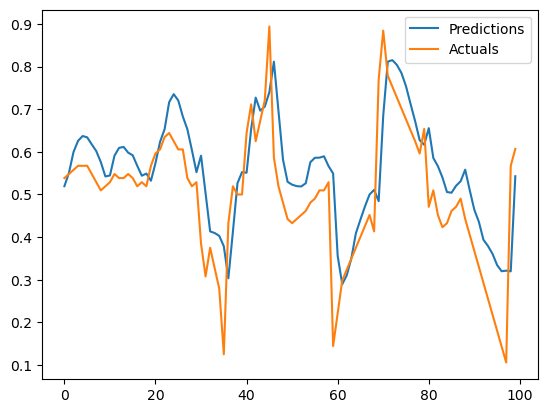

MAPE: 466708479.09439915
MSE for Predictions: 0.017872885090343807
MAE:  0.09720948


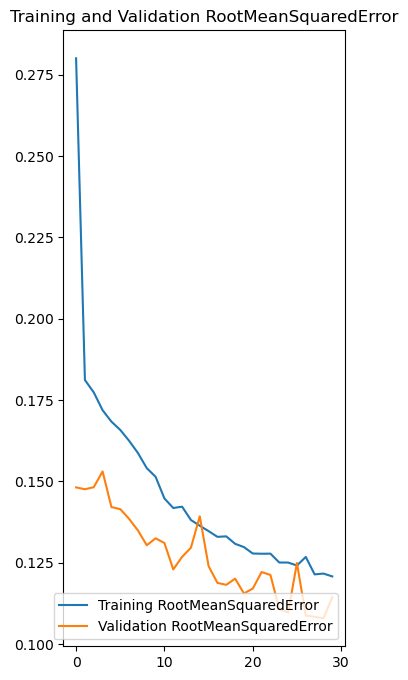

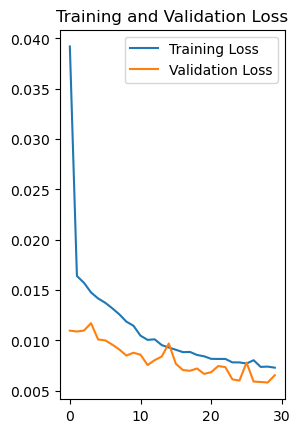

In [218]:
cp26 = ModelCheckpoint('models/model26/', save_best_only=True)
model26.compile(loss=Huber(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(),'mse', 'mae'])
Model26 = model26.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, callbacks=[cp26])

Ypred26=model.predict(X_test)
plot_predictions2(model26, X_test, Y_test)
pltGraph(Model26, 30)
Ypred26_flat = Ypred26.flatten()

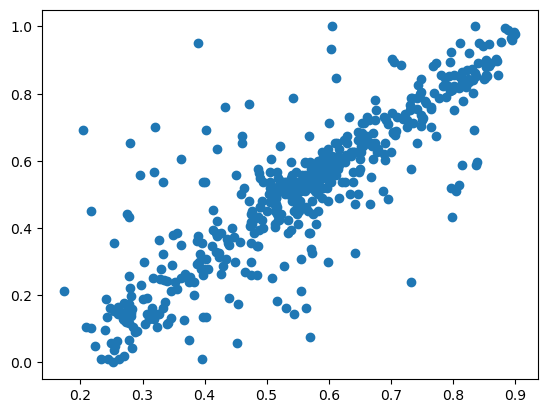

In [220]:
plt.scatter(Ypred26_flat, Y_test)

In [221]:
model30 = Sequential()

model30.add(InputLayer((7, 14)))
# 1D CNN layers
model30.add(Conv1D(filters=32, kernel_size=3, activation='tanh', padding='same', input_shape=(7, 14)))

model30.add(LSTM(units=256, return_sequences=True))

model30.add(Dropout(0.5))

model30.add(Conv1D(filters=64, kernel_size=3, activation='tanh', padding='same'))

model30.add(LSTM(units=128, return_sequences=False))

model30.add(Dropout(0.5))


# Reshape for 2D CNN layer
model30.add(Reshape((64, 1, 2)))  # reshape to (batch_size, 64, 1, 1)

# 2D CNN layers
model30.add(Conv2D(filters=32, kernel_size=(3, 3), activation='tanh', padding='same'))

model30.add(Conv2D(filters=64, kernel_size=(3, 3), activation='tanh', padding='same'))

# Flatten layer
model30.add(Flatten())

model30.add(Reshape((64, 64))) 

model30.add(LSTM(units=64, return_sequences=False))

model30.add(Dropout(0.5))

# Output layer
model30.add(Dense(units=1, activation='linear'))

# Display model summary
model30.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_70 (Conv1D)          (None, 7, 32)             1376      
                                                                 
 lstm_71 (LSTM)              (None, 7, 256)            295936    
                                                                 
 dropout_25 (Dropout)        (None, 7, 256)            0         
                                                                 
 conv1d_71 (Conv1D)          (None, 7, 64)             49216     
                                                                 
 lstm_72 (LSTM)              (None, 128)               98816     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 reshape_7 (Reshape)         (None, 64, 1, 2)        

Epoch 1/30
102/102 [==============================] - ETA: 0s - loss: 0.1046 - root_mean_squared_error: 0.3234INFO:tensorflow:Assets written to: models/model30_30epsss/assets


INFO:tensorflow:Assets written to: models/model30_30epsss/assets


102/102 [==============================] - 16s 108ms/step - loss: 0.1046 - root_mean_squared_error: 0.3234 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1686
Epoch 2/30
102/102 [==============================] - ETA: 0s - loss: 0.0337 - root_mean_squared_error: 0.1836INFO:tensorflow:Assets written to: models/model30_30epsss/assets


INFO:tensorflow:Assets written to: models/model30_30epsss/assets


102/102 [==============================] - 8s 78ms/step - loss: 0.0337 - root_mean_squared_error: 0.1836 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1595
Epoch 3/30
102/102 [==============================] - ETA: 0s - loss: 0.0320 - root_mean_squared_error: 0.1789INFO:tensorflow:Assets written to: models/model30_30epsss/assets


INFO:tensorflow:Assets written to: models/model30_30epsss/assets


102/102 [==============================] - 8s 76ms/step - loss: 0.0320 - root_mean_squared_error: 0.1789 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1593
Epoch 4/30
102/102 [==============================] - ETA: 0s - loss: 0.0292 - root_mean_squared_error: 0.1708INFO:tensorflow:Assets written to: models/model30_30epsss/assets


INFO:tensorflow:Assets written to: models/model30_30epsss/assets


102/102 [==============================] - 11s 110ms/step - loss: 0.0292 - root_mean_squared_error: 0.1708 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1516
Epoch 5/30
102/102 [==============================] - ETA: 0s - loss: 0.0275 - root_mean_squared_error: 0.1659INFO:tensorflow:Assets written to: models/model30_30epsss/assets


INFO:tensorflow:Assets written to: models/model30_30epsss/assets


102/102 [==============================] - 8s 75ms/step - loss: 0.0275 - root_mean_squared_error: 0.1659 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1396
Epoch 6/30
102/102 [==============================] - 3s 29ms/step - loss: 0.0252 - root_mean_squared_error: 0.1588 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1449
Epoch 7/30
102/102 [==============================] - 3s 27ms/step - loss: 0.0243 - root_mean_squared_error: 0.1560 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1559
Epoch 8/30
102/102 [==============================] - ETA: 0s - loss: 0.0228 - root_mean_squared_error: 0.1510INFO:tensorflow:Assets written to: models/model30_30epsss/assets


INFO:tensorflow:Assets written to: models/model30_30epsss/assets


102/102 [==============================] - 8s 82ms/step - loss: 0.0228 - root_mean_squared_error: 0.1510 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1280
Epoch 9/30
102/102 [==============================] - 3s 34ms/step - loss: 0.0212 - root_mean_squared_error: 0.1456 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1314
Epoch 10/30
102/102 [==============================] - 3s 26ms/step - loss: 0.0203 - root_mean_squared_error: 0.1423 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1353
Epoch 11/30
102/102 [==============================] - 3s 28ms/step - loss: 0.0196 - root_mean_squared_error: 0.1401 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1283
Epoch 12/30
101/102 [============================>.] - ETA: 0s - loss: 0.0192 - root_mean_squared_error: 0.1384INFO:tensorflow:Assets written to: models/model30_30epsss/assets


INFO:tensorflow:Assets written to: models/model30_30epsss/assets


102/102 [==============================] - 7s 73ms/step - loss: 0.0190 - root_mean_squared_error: 0.1380 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1220
Epoch 13/30
102/102 [==============================] - 3s 27ms/step - loss: 0.0188 - root_mean_squared_error: 0.1372 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1281
Epoch 14/30
102/102 [==============================] - 3s 33ms/step - loss: 0.0185 - root_mean_squared_error: 0.1359 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1239
Epoch 15/30
102/102 [==============================] - 3s 27ms/step - loss: 0.0183 - root_mean_squared_error: 0.1352 - val_loss: 0.0196 - val_root_mean_squared_error: 0.1402
Epoch 16/30
102/102 [==============================] - ETA: 0s - loss: 0.0186 - root_mean_squared_error: 0.1363INFO:tensorflow:Assets written to: models/model30_30epsss/assets


INFO:tensorflow:Assets written to: models/model30_30epsss/assets


102/102 [==============================] - 8s 82ms/step - loss: 0.0186 - root_mean_squared_error: 0.1363 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1176
Epoch 17/30
102/102 [==============================] - 4s 35ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1285
Epoch 18/30
102/102 [==============================] - 3s 26ms/step - loss: 0.0176 - root_mean_squared_error: 0.1325 - val_loss: 0.0177 - val_root_mean_squared_error: 0.1332
Epoch 19/30
102/102 [==============================] - 3s 26ms/step - loss: 0.0170 - root_mean_squared_error: 0.1305 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1328
Epoch 20/30
102/102 [==============================] - 3s 27ms/step - loss: 0.0180 - root_mean_squared_error: 0.1340 - val_loss: 0.0168 - val_root_mean_squared_error: 0.1298
Epoch 21/30
102/102 [==============================] - 3s 27ms/step - loss: 0.0169 - root_mean_squared_error: 0.1299 - val_loss: 0.0175 - val_

INFO:tensorflow:Assets written to: models/model30_30epsss/assets


102/102 [==============================] - 11s 107ms/step - loss: 0.0160 - root_mean_squared_error: 0.1266 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161
Epoch 25/30
102/102 [==============================] - 4s 34ms/step - loss: 0.0159 - root_mean_squared_error: 0.1261 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193
Epoch 26/30
102/102 [==============================] - 3s 33ms/step - loss: 0.0158 - root_mean_squared_error: 0.1257 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1211
Epoch 27/30
102/102 [==============================] - 3s 30ms/step - loss: 0.0154 - root_mean_squared_error: 0.1241 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193
Epoch 28/30
100/102 [============================>.] - ETA: 0s - loss: 0.0155 - root_mean_squared_error: 0.1245INFO:tensorflow:Assets written to: models/model30_30epsss/assets


INFO:tensorflow:Assets written to: models/model30_30epsss/assets


102/102 [==============================] - 8s 76ms/step - loss: 0.0156 - root_mean_squared_error: 0.1248 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 29/30
102/102 [==============================] - 3s 32ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1217
Epoch 30/30
17/17 [==============================] - 0s 10ms/step


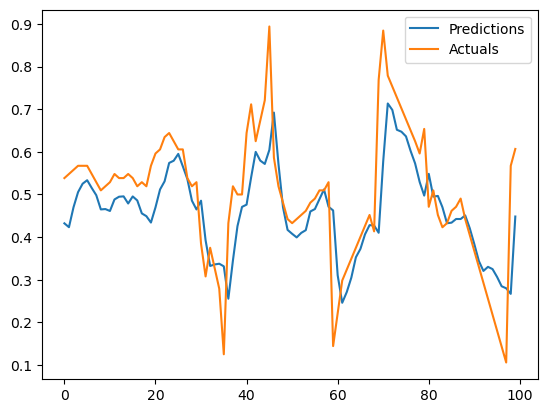

MAPE: 398531136.0049408
MSE for Predictions: 0.01958017909460601
MAE:  0.10917983


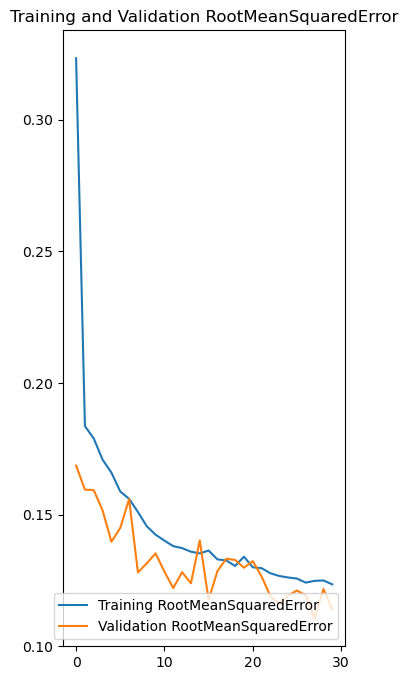

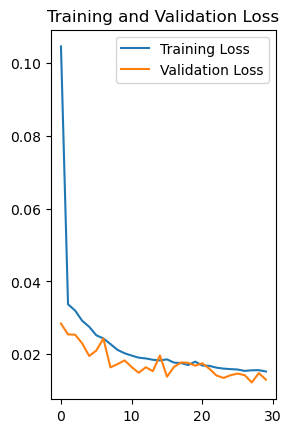

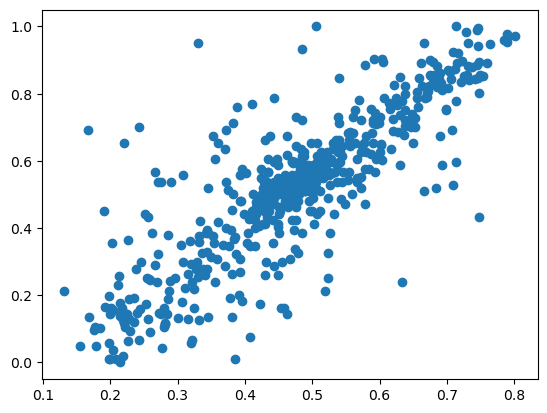

In [222]:
from tensorflow.keras.losses import Huber

cp30 = ModelCheckpoint('models/model30_30epsss/', save_best_only=True)

model30.compile(loss=MeanSquaredError(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
Model30 = model30.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, callbacks=[cp30])

Ypred21n=model30.predict(X_test)
plot_predictions2(model30, X_test, Y_test)
pltGraph(Model30, 30)
plt.scatter(Ypred21n, Y_test)

Epoch 1/30
102/102 [==============================] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.1253 - mse: 0.0157 - mae: 0.0827INFO:tensorflow:Assets written to: models/model30_huber/assets


INFO:tensorflow:Assets written to: models/model30_huber/assets


102/102 [==============================] - 17s 108ms/step - loss: 0.0078 - root_mean_squared_error: 0.1253 - mse: 0.0157 - mae: 0.0827 - val_loss: 0.0073 - val_root_mean_squared_error: 0.1205 - val_mse: 0.0145 - val_mae: 0.0895
Epoch 2/30
102/102 [==============================] - ETA: 0s - loss: 0.0075 - root_mean_squared_error: 0.1228 - mse: 0.0151 - mae: 0.0811INFO:tensorflow:Assets written to: models/model30_huber/assets


INFO:tensorflow:Assets written to: models/model30_huber/assets


102/102 [==============================] - 8s 78ms/step - loss: 0.0075 - root_mean_squared_error: 0.1228 - mse: 0.0151 - mae: 0.0811 - val_loss: 0.0059 - val_root_mean_squared_error: 0.1088 - val_mse: 0.0118 - val_mae: 0.0720
Epoch 3/30
102/102 [==============================] - 3s 28ms/step - loss: 0.0075 - root_mean_squared_error: 0.1224 - mse: 0.0150 - mae: 0.0796 - val_loss: 0.0093 - val_root_mean_squared_error: 0.1362 - val_mse: 0.0185 - val_mae: 0.1098
Epoch 4/30
102/102 [==============================] - 3s 27ms/step - loss: 0.0076 - root_mean_squared_error: 0.1234 - mse: 0.0152 - mae: 0.0820 - val_loss: 0.0063 - val_root_mean_squared_error: 0.1120 - val_mse: 0.0125 - val_mae: 0.0779
Epoch 5/30
102/102 [==============================] - 3s 27ms/step - loss: 0.0075 - root_mean_squared_error: 0.1229 - mse: 0.0151 - mae: 0.0814 - val_loss: 0.0076 - val_root_mean_squared_error: 0.1236 - val_mse: 0.0153 - val_mae: 0.0945
Epoch 6/30
102/102 [==============================] - 4s 38ms/s

INFO:tensorflow:Assets written to: models/model30_huber/assets


102/102 [==============================] - 11s 107ms/step - loss: 0.0071 - root_mean_squared_error: 0.1189 - mse: 0.0141 - mae: 0.0768 - val_loss: 0.0056 - val_root_mean_squared_error: 0.1061 - val_mse: 0.0113 - val_mae: 0.0698
Epoch 18/30
102/102 [==============================] - 3s 27ms/step - loss: 0.0073 - root_mean_squared_error: 0.1205 - mse: 0.0145 - mae: 0.0789 - val_loss: 0.0089 - val_root_mean_squared_error: 0.1336 - val_mse: 0.0178 - val_mae: 0.1077
Epoch 19/30
102/102 [==============================] - 3s 26ms/step - loss: 0.0072 - root_mean_squared_error: 0.1204 - mse: 0.0145 - mae: 0.0782 - val_loss: 0.0080 - val_root_mean_squared_error: 0.1263 - val_mse: 0.0159 - val_mae: 0.0990
Epoch 20/30
102/102 [==============================] - 3s 26ms/step - loss: 0.0071 - root_mean_squared_error: 0.1193 - mse: 0.0142 - mae: 0.0763 - val_loss: 0.0074 - val_root_mean_squared_error: 0.1220 - val_mse: 0.0149 - val_mae: 0.0939
Epoch 21/30
102/102 [==============================] - 3s 

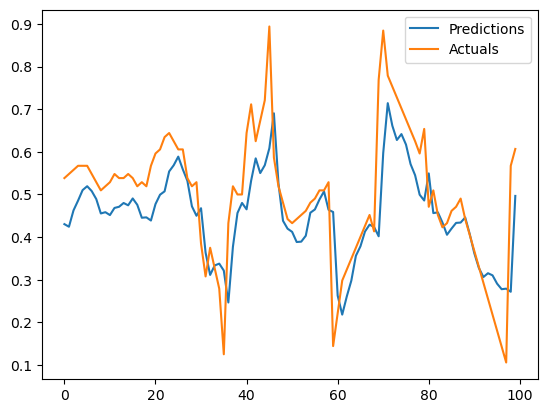

MAPE: 369018567.2568938
MSE for Predictions: 0.01967698581694653
MAE:  0.110887386


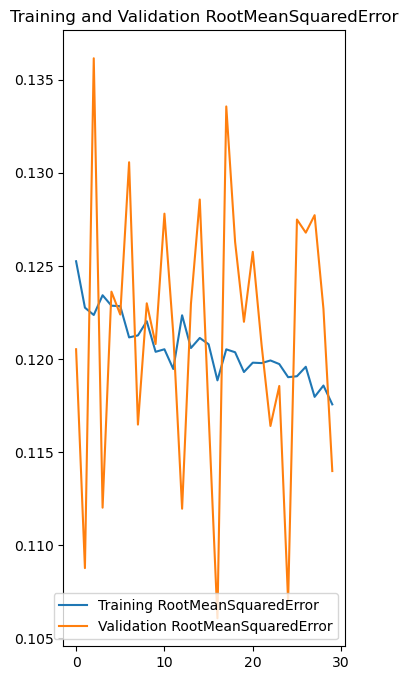

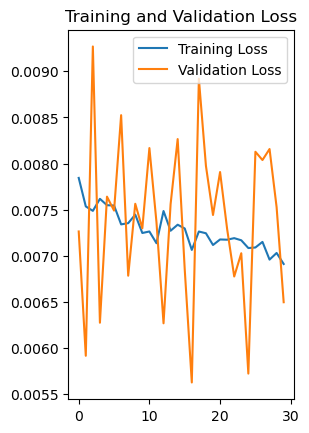

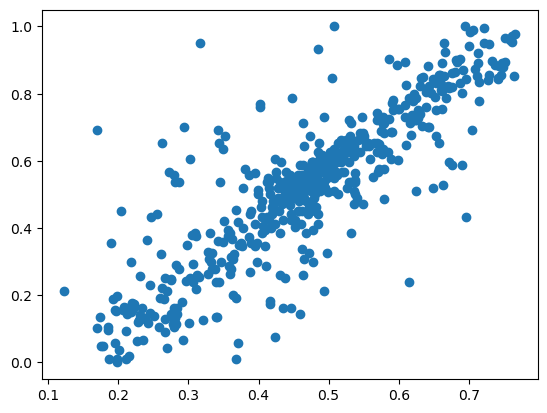

In [223]:
from tensorflow.keras.losses import Huber

cp30_1 = ModelCheckpoint('models/model30_huber/', save_best_only=True)

model30.compile(loss=Huber(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(),'mse', 'mae'])
Model30 = model30.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, callbacks=[cp30_1])

Ypred21n=model30.predict(X_test)
plot_predictions2(model30, X_test, Y_test)
pltGraph(Model30, 30)
plt.scatter(Ypred21n, Y_test)

# Best Model So far  Model 32

In [224]:
model32 = Sequential()

model32.add(InputLayer((7, 14)))
# 1D CNN layers
model32.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=(7, 16)))
model32.add(LSTM(units=256, return_sequences=True))
model32.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model32.add(LSTM(units=128, return_sequences=True))


model32.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))

model32.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))

model32.add(LSTM(units=64, return_sequences=False))
# Flatten layer
model32.add(Flatten())

# Output layer
model32.add(Dense(units=1, activation='linear'))

# Display model summary
model32.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_72 (Conv1D)          (None, 7, 128)            5504      
                                                                 
 lstm_74 (LSTM)              (None, 7, 256)            394240    
                                                                 
 conv1d_73 (Conv1D)          (None, 7, 64)             49216     
                                                                 
 lstm_75 (LSTM)              (None, 7, 128)            98816     
                                                                 
 conv1d_74 (Conv1D)          (None, 7, 32)             12320     
                                                                 
 conv1d_75 (Conv1D)          (None, 7, 32)             3104      
                                                                 
 lstm_76 (LSTM)              (None, 64)              

Epoch 1/30
102/102 [==============================] - ETA: 0s - loss: 0.0387 - root_mean_squared_error: 0.2782 - mse: 0.0774 - mae: 0.2099INFO:tensorflow:Assets written to: models/model32_huber/assets


INFO:tensorflow:Assets written to: models/model32_huber/assets


102/102 [==============================] - 17s 113ms/step - loss: 0.0387 - root_mean_squared_error: 0.2782 - mse: 0.0774 - mae: 0.2099 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1527 - val_mse: 0.0233 - val_mae: 0.1084
Epoch 2/30
102/102 [==============================] - 3s 27ms/step - loss: 0.0154 - root_mean_squared_error: 0.1757 - mse: 0.0309 - mae: 0.1292 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1549 - val_mse: 0.0240 - val_mae: 0.1141
Epoch 3/30
102/102 [==============================] - ETA: 0s - loss: 0.0147 - root_mean_squared_error: 0.1712 - mse: 0.0293 - mae: 0.1246INFO:tensorflow:Assets written to: models/model32_huber/assets


INFO:tensorflow:Assets written to: models/model32_huber/assets


102/102 [==============================] - 7s 71ms/step - loss: 0.0147 - root_mean_squared_error: 0.1712 - mse: 0.0293 - mae: 0.1246 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1464 - val_mse: 0.0214 - val_mae: 0.1005
Epoch 4/30
102/102 [==============================] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.1657 - mse: 0.0275 - mae: 0.1191INFO:tensorflow:Assets written to: models/model32_huber/assets


INFO:tensorflow:Assets written to: models/model32_huber/assets


102/102 [==============================] - 8s 77ms/step - loss: 0.0137 - root_mean_squared_error: 0.1657 - mse: 0.0275 - mae: 0.1191 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1443 - val_mse: 0.0208 - val_mae: 0.0990
Epoch 5/30
102/102 [==============================] - ETA: 0s - loss: 0.0136 - root_mean_squared_error: 0.1651 - mse: 0.0273 - mae: 0.1199INFO:tensorflow:Assets written to: models/model32_huber/assets


INFO:tensorflow:Assets written to: models/model32_huber/assets


102/102 [==============================] - 9s 92ms/step - loss: 0.0136 - root_mean_squared_error: 0.1651 - mse: 0.0273 - mae: 0.1199 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1429 - val_mse: 0.0204 - val_mae: 0.0970
Epoch 6/30
102/102 [==============================] - 3s 24ms/step - loss: 0.0130 - root_mean_squared_error: 0.1610 - mse: 0.0259 - mae: 0.1157 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1463 - val_mse: 0.0214 - val_mae: 0.1016
Epoch 7/30
102/102 [==============================] - ETA: 0s - loss: 0.0122 - root_mean_squared_error: 0.1562 - mse: 0.0244 - mae: 0.1110INFO:tensorflow:Assets written to: models/model32_huber/assets


INFO:tensorflow:Assets written to: models/model32_huber/assets


102/102 [==============================] - 8s 79ms/step - loss: 0.0122 - root_mean_squared_error: 0.1562 - mse: 0.0244 - mae: 0.1110 - val_loss: 0.0089 - val_root_mean_squared_error: 0.1337 - val_mse: 0.0179 - val_mae: 0.0907
Epoch 8/30
102/102 [==============================] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.1500 - mse: 0.0225 - mae: 0.1057INFO:tensorflow:Assets written to: models/model32_huber/assets


INFO:tensorflow:Assets written to: models/model32_huber/assets


102/102 [==============================] - 7s 71ms/step - loss: 0.0113 - root_mean_squared_error: 0.1500 - mse: 0.0225 - mae: 0.1057 - val_loss: 0.0086 - val_root_mean_squared_error: 0.1311 - val_mse: 0.0172 - val_mae: 0.0884
Epoch 9/30
102/102 [==============================] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.1425 - mse: 0.0203 - mae: 0.0990INFO:tensorflow:Assets written to: models/model32_huber/assets


INFO:tensorflow:Assets written to: models/model32_huber/assets


102/102 [==============================] - 7s 68ms/step - loss: 0.0102 - root_mean_squared_error: 0.1425 - mse: 0.0203 - mae: 0.0990 - val_loss: 0.0084 - val_root_mean_squared_error: 0.1294 - val_mse: 0.0167 - val_mae: 0.0877
Epoch 10/30
102/102 [==============================] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.1366 - mse: 0.0186 - mae: 0.0953INFO:tensorflow:Assets written to: models/model32_huber/assets


INFO:tensorflow:Assets written to: models/model32_huber/assets


102/102 [==============================] - 7s 73ms/step - loss: 0.0093 - root_mean_squared_error: 0.1366 - mse: 0.0186 - mae: 0.0953 - val_loss: 0.0077 - val_root_mean_squared_error: 0.1238 - val_mse: 0.0153 - val_mae: 0.0821
Epoch 11/30
102/102 [==============================] - 3s 25ms/step - loss: 0.0088 - root_mean_squared_error: 0.1329 - mse: 0.0177 - mae: 0.0908 - val_loss: 0.0079 - val_root_mean_squared_error: 0.1257 - val_mse: 0.0158 - val_mae: 0.0844
Epoch 12/30
100/102 [============================>.] - ETA: 0s - loss: 0.0085 - root_mean_squared_error: 0.1304 - mse: 0.0170 - mae: 0.0886INFO:tensorflow:Assets written to: models/model32_huber/assets


INFO:tensorflow:Assets written to: models/model32_huber/assets


102/102 [==============================] - 7s 67ms/step - loss: 0.0085 - root_mean_squared_error: 0.1302 - mse: 0.0169 - mae: 0.0885 - val_loss: 0.0068 - val_root_mean_squared_error: 0.1169 - val_mse: 0.0137 - val_mae: 0.0788
Epoch 13/30
100/102 [============================>.] - ETA: 0s - loss: 0.0085 - root_mean_squared_error: 0.1304 - mse: 0.0170 - mae: 0.0889INFO:tensorflow:Assets written to: models/model32_huber/assets


INFO:tensorflow:Assets written to: models/model32_huber/assets


102/102 [==============================] - 10s 96ms/step - loss: 0.0085 - root_mean_squared_error: 0.1300 - mse: 0.0169 - mae: 0.0886 - val_loss: 0.0067 - val_root_mean_squared_error: 0.1156 - val_mse: 0.0134 - val_mae: 0.0753
Epoch 14/30
102/102 [==============================] - 2s 22ms/step - loss: 0.0079 - root_mean_squared_error: 0.1254 - mse: 0.0157 - mae: 0.0830 - val_loss: 0.0068 - val_root_mean_squared_error: 0.1162 - val_mse: 0.0135 - val_mae: 0.0800
Epoch 15/30
102/102 [==============================] - 2s 22ms/step - loss: 0.0078 - root_mean_squared_error: 0.1246 - mse: 0.0155 - mae: 0.0836 - val_loss: 0.0067 - val_root_mean_squared_error: 0.1161 - val_mse: 0.0135 - val_mae: 0.0769
Epoch 16/30
100/102 [============================>.] - ETA: 0s - loss: 0.0076 - root_mean_squared_error: 0.1235 - mse: 0.0153 - mae: 0.0821INFO:tensorflow:Assets written to: models/model32_huber/assets


INFO:tensorflow:Assets written to: models/model32_huber/assets


102/102 [==============================] - 7s 65ms/step - loss: 0.0076 - root_mean_squared_error: 0.1232 - mse: 0.0152 - mae: 0.0818 - val_loss: 0.0059 - val_root_mean_squared_error: 0.1089 - val_mse: 0.0119 - val_mae: 0.0697
Epoch 17/30
102/102 [==============================] - 2s 21ms/step - loss: 0.0072 - root_mean_squared_error: 0.1204 - mse: 0.0145 - mae: 0.0781 - val_loss: 0.0060 - val_root_mean_squared_error: 0.1094 - val_mse: 0.0120 - val_mae: 0.0704
Epoch 18/30
102/102 [==============================] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.1201 - mse: 0.0144 - mae: 0.0783INFO:tensorflow:Assets written to: models/model32_huber/assets


INFO:tensorflow:Assets written to: models/model32_huber/assets


102/102 [==============================] - 7s 65ms/step - loss: 0.0072 - root_mean_squared_error: 0.1201 - mse: 0.0144 - mae: 0.0783 - val_loss: 0.0057 - val_root_mean_squared_error: 0.1065 - val_mse: 0.0113 - val_mae: 0.0677
Epoch 19/30
102/102 [==============================] - 2s 22ms/step - loss: 0.0071 - root_mean_squared_error: 0.1189 - mse: 0.0141 - mae: 0.0777 - val_loss: 0.0067 - val_root_mean_squared_error: 0.1157 - val_mse: 0.0134 - val_mae: 0.0803
Epoch 20/30
102/102 [==============================] - 2s 23ms/step - loss: 0.0071 - root_mean_squared_error: 0.1190 - mse: 0.0142 - mae: 0.0789 - val_loss: 0.0065 - val_root_mean_squared_error: 0.1142 - val_mse: 0.0130 - val_mae: 0.0779
Epoch 21/30
102/102 [==============================] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.1162 - mse: 0.0135 - mae: 0.0749INFO:tensorflow:Assets written to: models/model32_huber/assets


INFO:tensorflow:Assets written to: models/model32_huber/assets


102/102 [==============================] - 7s 69ms/step - loss: 0.0068 - root_mean_squared_error: 0.1162 - mse: 0.0135 - mae: 0.0749 - val_loss: 0.0055 - val_root_mean_squared_error: 0.1048 - val_mse: 0.0110 - val_mae: 0.0665
Epoch 22/30
102/102 [==============================] - 2s 23ms/step - loss: 0.0068 - root_mean_squared_error: 0.1166 - mse: 0.0136 - mae: 0.0755 - val_loss: 0.0055 - val_root_mean_squared_error: 0.1053 - val_mse: 0.0111 - val_mae: 0.0663
Epoch 23/30
102/102 [==============================] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.1148 - mse: 0.0132 - mae: 0.0738INFO:tensorflow:Assets written to: models/model32_huber/assets


INFO:tensorflow:Assets written to: models/model32_huber/assets


102/102 [==============================] - 7s 68ms/step - loss: 0.0066 - root_mean_squared_error: 0.1148 - mse: 0.0132 - mae: 0.0738 - val_loss: 0.0054 - val_root_mean_squared_error: 0.1034 - val_mse: 0.0107 - val_mae: 0.0660
Epoch 24/30
102/102 [==============================] - 2s 22ms/step - loss: 0.0066 - root_mean_squared_error: 0.1152 - mse: 0.0133 - mae: 0.0742 - val_loss: 0.0055 - val_root_mean_squared_error: 0.1044 - val_mse: 0.0109 - val_mae: 0.0670
Epoch 25/30
100/102 [============================>.] - ETA: 0s - loss: 0.0066 - root_mean_squared_error: 0.1148 - mse: 0.0132 - mae: 0.0734INFO:tensorflow:Assets written to: models/model32_huber/assets


INFO:tensorflow:Assets written to: models/model32_huber/assets


102/102 [==============================] - 9s 87ms/step - loss: 0.0066 - root_mean_squared_error: 0.1145 - mse: 0.0131 - mae: 0.0732 - val_loss: 0.0053 - val_root_mean_squared_error: 0.1033 - val_mse: 0.0107 - val_mae: 0.0657
Epoch 26/30
102/102 [==============================] - 2s 22ms/step - loss: 0.0064 - root_mean_squared_error: 0.1133 - mse: 0.0128 - mae: 0.0722 - val_loss: 0.0056 - val_root_mean_squared_error: 0.1055 - val_mse: 0.0111 - val_mae: 0.0659
Epoch 27/30
102/102 [==============================] - 2s 21ms/step - loss: 0.0065 - root_mean_squared_error: 0.1141 - mse: 0.0130 - mae: 0.0725 - val_loss: 0.0054 - val_root_mean_squared_error: 0.1037 - val_mse: 0.0108 - val_mae: 0.0665
Epoch 28/30
102/102 [==============================] - 2s 21ms/step - loss: 0.0064 - root_mean_squared_error: 0.1132 - mse: 0.0128 - mae: 0.0724 - val_loss: 0.0054 - val_root_mean_squared_error: 0.1040 - val_mse: 0.0108 - val_mae: 0.0662
Epoch 29/30
100/102 [============================>.] - ETA: 

INFO:tensorflow:Assets written to: models/model32_huber/assets


102/102 [==============================] - 7s 66ms/step - loss: 0.0065 - root_mean_squared_error: 0.1139 - mse: 0.0130 - mae: 0.0725 - val_loss: 0.0053 - val_root_mean_squared_error: 0.1033 - val_mse: 0.0107 - val_mae: 0.0666
Epoch 30/30
17/17 [==============================] - 0s 7ms/step


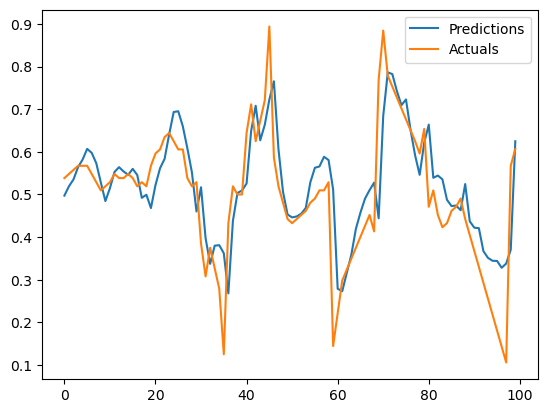

MAPE: 416146172.5627083
MSE for Predictions: 0.016055151643440693
MAE:  0.09146683


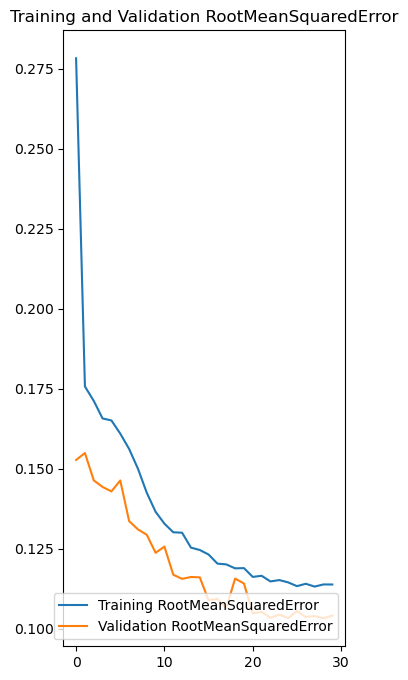

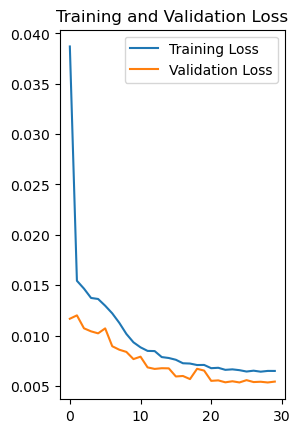

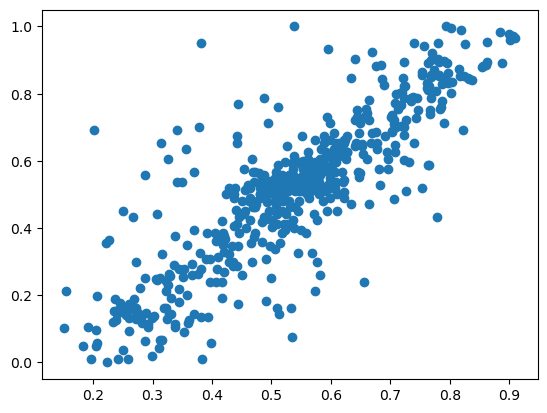

In [225]:
from tensorflow.keras.losses import Huber

cp32_1 = ModelCheckpoint('models/model32_huber/', save_best_only=True)

model32.compile(loss=Huber(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(),'mse', 'mae'])
Model32 = model32.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, callbacks=[cp32_1])

Ypred32=model32.predict(X_test)
plot_predictions2(model32, X_test, Y_test)
pltGraph(Model32, 30)
plt.scatter(Ypred32, Y_test)

In [195]:
model33 = Sequential()

model33.add(InputLayer((7, 14)))
# 1D CNN layers
model33.add(Conv1D(filters=256, kernel_size=2, activation='tanh', padding='same', input_shape=(7, 16)))
model33.add(LSTM(units=256, return_sequences=True))
model33.add(Conv1D(filters=128, kernel_size=2, activation='tanh', padding='same'))
model33.add(LSTM(units=128, return_sequences=True))


model33.add(Conv1D(filters=64, kernel_size=2, activation='tanh', padding='same'))

model33.add(Conv1D(filters=32, kernel_size=2, activation='tanh', padding='same'))

model33.add(LSTM(units=64, return_sequences=False))

# Flatten layer
model33.add(Flatten())

# Output layer

model33.add(Dense(units=1, activation='linear'))

# Display model summary
model33.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 7, 256)            7424      
                                                                 
 lstm_6 (LSTM)               (None, 7, 256)            525312    
                                                                 
 conv1d_6 (Conv1D)           (None, 7, 128)            65664     
                                                                 
 lstm_7 (LSTM)               (None, 7, 128)            131584    
                                                                 
 conv1d_7 (Conv1D)           (None, 7, 64)             16448     
                                                                 
 conv1d_8 (Conv1D)           (None, 7, 32)             4128      
                                                                 
 lstm_8 (LSTM)               (None, 64)               

Epoch 1/30
102/102 [==============================] - ETA: 0s - loss: 0.0232 - root_mean_squared_error: 0.2155 - mse: 0.0465 - mae: 0.1585INFO:tensorflow:Assets written to: models/model33_huber/assets


INFO:tensorflow:Assets written to: models/model33_huber/assets


102/102 [==============================] - 13s 85ms/step - loss: 0.0232 - root_mean_squared_error: 0.2155 - mse: 0.0465 - mae: 0.1585 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1431 - val_mse: 0.0205 - val_mae: 0.0951
Epoch 2/30
102/102 [==============================] - ETA: 0s - loss: 0.0138 - root_mean_squared_error: 0.1659 - mse: 0.0275 - mae: 0.1201INFO:tensorflow:Assets written to: models/model33_huber/assets


INFO:tensorflow:Assets written to: models/model33_huber/assets


102/102 [==============================] - 10s 95ms/step - loss: 0.0138 - root_mean_squared_error: 0.1659 - mse: 0.0275 - mae: 0.1201 - val_loss: 0.0094 - val_root_mean_squared_error: 0.1373 - val_mse: 0.0189 - val_mae: 0.0922
Epoch 3/30
102/102 [==============================] - 4s 40ms/step - loss: 0.0128 - root_mean_squared_error: 0.1600 - mse: 0.0256 - mae: 0.1147 - val_loss: 0.0098 - val_root_mean_squared_error: 0.1401 - val_mse: 0.0196 - val_mae: 0.0965
Epoch 4/30
102/102 [==============================] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.1559 - mse: 0.0243 - mae: 0.1110INFO:tensorflow:Assets written to: models/model33_huber/assets


INFO:tensorflow:Assets written to: models/model33_huber/assets


102/102 [==============================] - 9s 88ms/step - loss: 0.0121 - root_mean_squared_error: 0.1559 - mse: 0.0243 - mae: 0.1110 - val_loss: 0.0090 - val_root_mean_squared_error: 0.1338 - val_mse: 0.0179 - val_mae: 0.0904
Epoch 5/30
100/102 [============================>.] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.1500 - mse: 0.0225 - mae: 0.1055INFO:tensorflow:Assets written to: models/model33_huber/assets


INFO:tensorflow:Assets written to: models/model33_huber/assets


102/102 [==============================] - 8s 79ms/step - loss: 0.0112 - root_mean_squared_error: 0.1496 - mse: 0.0224 - mae: 0.1051 - val_loss: 0.0081 - val_root_mean_squared_error: 0.1273 - val_mse: 0.0162 - val_mae: 0.0850
Epoch 6/30
102/102 [==============================] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.1430 - mse: 0.0204 - mae: 0.0998INFO:tensorflow:Assets written to: models/model33_huber/assets


INFO:tensorflow:Assets written to: models/model33_huber/assets


102/102 [==============================] - 8s 74ms/step - loss: 0.0102 - root_mean_squared_error: 0.1430 - mse: 0.0204 - mae: 0.0998 - val_loss: 0.0074 - val_root_mean_squared_error: 0.1213 - val_mse: 0.0147 - val_mae: 0.0805
Epoch 7/30
102/102 [==============================] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.1362 - mse: 0.0185 - mae: 0.0939INFO:tensorflow:Assets written to: models/model33_huber/assets


INFO:tensorflow:Assets written to: models/model33_huber/assets


102/102 [==============================] - 8s 74ms/step - loss: 0.0093 - root_mean_squared_error: 0.1362 - mse: 0.0185 - mae: 0.0939 - val_loss: 0.0070 - val_root_mean_squared_error: 0.1180 - val_mse: 0.0139 - val_mae: 0.0776
Epoch 8/30
100/102 [============================>.] - ETA: 0s - loss: 0.0091 - root_mean_squared_error: 0.1351 - mse: 0.0182 - mae: 0.0926INFO:tensorflow:Assets written to: models/model33_huber/assets


INFO:tensorflow:Assets written to: models/model33_huber/assets


102/102 [==============================] - 7s 71ms/step - loss: 0.0092 - root_mean_squared_error: 0.1356 - mse: 0.0184 - mae: 0.0930 - val_loss: 0.0067 - val_root_mean_squared_error: 0.1159 - val_mse: 0.0134 - val_mae: 0.0764
Epoch 9/30
100/102 [============================>.] - ETA: 0s - loss: 0.0085 - root_mean_squared_error: 0.1302 - mse: 0.0169 - mae: 0.0872INFO:tensorflow:Assets written to: models/model33_huber/assets


INFO:tensorflow:Assets written to: models/model33_huber/assets


102/102 [==============================] - 7s 72ms/step - loss: 0.0085 - root_mean_squared_error: 0.1301 - mse: 0.0169 - mae: 0.0872 - val_loss: 0.0067 - val_root_mean_squared_error: 0.1153 - val_mse: 0.0133 - val_mae: 0.0748
Epoch 10/30
102/102 [==============================] - ETA: 0s - loss: 0.0085 - root_mean_squared_error: 0.1305 - mse: 0.0170 - mae: 0.0883INFO:tensorflow:Assets written to: models/model33_huber/assets


INFO:tensorflow:Assets written to: models/model33_huber/assets


102/102 [==============================] - 7s 71ms/step - loss: 0.0085 - root_mean_squared_error: 0.1305 - mse: 0.0170 - mae: 0.0883 - val_loss: 0.0064 - val_root_mean_squared_error: 0.1133 - val_mse: 0.0128 - val_mae: 0.0755
Epoch 11/30
102/102 [==============================] - 2s 23ms/step - loss: 0.0083 - root_mean_squared_error: 0.1285 - mse: 0.0165 - mae: 0.0858 - val_loss: 0.0066 - val_root_mean_squared_error: 0.1145 - val_mse: 0.0131 - val_mae: 0.0746
Epoch 12/30
101/102 [============================>.] - ETA: 0s - loss: 0.0082 - root_mean_squared_error: 0.1283 - mse: 0.0164 - mae: 0.0873INFO:tensorflow:Assets written to: models/model33_huber/assets


INFO:tensorflow:Assets written to: models/model33_huber/assets


102/102 [==============================] - 7s 66ms/step - loss: 0.0082 - root_mean_squared_error: 0.1280 - mse: 0.0164 - mae: 0.0873 - val_loss: 0.0060 - val_root_mean_squared_error: 0.1094 - val_mse: 0.0120 - val_mae: 0.0677
Epoch 13/30
102/102 [==============================] - ETA: 0s - loss: 0.0078 - root_mean_squared_error: 0.1251 - mse: 0.0157 - mae: 0.0823INFO:tensorflow:Assets written to: models/model33_huber/assets


INFO:tensorflow:Assets written to: models/model33_huber/assets


102/102 [==============================] - 9s 89ms/step - loss: 0.0078 - root_mean_squared_error: 0.1251 - mse: 0.0157 - mae: 0.0823 - val_loss: 0.0059 - val_root_mean_squared_error: 0.1087 - val_mse: 0.0118 - val_mae: 0.0660
Epoch 14/30
102/102 [==============================] - 3s 26ms/step - loss: 0.0077 - root_mean_squared_error: 0.1241 - mse: 0.0154 - mae: 0.0818 - val_loss: 0.0059 - val_root_mean_squared_error: 0.1090 - val_mse: 0.0119 - val_mae: 0.0671
Epoch 15/30
102/102 [==============================] - 3s 32ms/step - loss: 0.0074 - root_mean_squared_error: 0.1216 - mse: 0.0148 - mae: 0.0787 - val_loss: 0.0060 - val_root_mean_squared_error: 0.1093 - val_mse: 0.0119 - val_mae: 0.0673
Epoch 16/30
102/102 [==============================] - 4s 38ms/step - loss: 0.0074 - root_mean_squared_error: 0.1215 - mse: 0.0148 - mae: 0.0789 - val_loss: 0.0060 - val_root_mean_squared_error: 0.1093 - val_mse: 0.0120 - val_mae: 0.0708
Epoch 17/30
100/102 [============================>.] - ETA: 

INFO:tensorflow:Assets written to: models/model33_huber/assets


102/102 [==============================] - 7s 71ms/step - loss: 0.0071 - root_mean_squared_error: 0.1192 - mse: 0.0142 - mae: 0.0755 - val_loss: 0.0057 - val_root_mean_squared_error: 0.1067 - val_mse: 0.0114 - val_mae: 0.0646
Epoch 18/30
101/102 [============================>.] - ETA: 0s - loss: 0.0074 - root_mean_squared_error: 0.1219 - mse: 0.0149 - mae: 0.0791INFO:tensorflow:Assets written to: models/model33_huber/assets


INFO:tensorflow:Assets written to: models/model33_huber/assets


102/102 [==============================] - 8s 78ms/step - loss: 0.0074 - root_mean_squared_error: 0.1215 - mse: 0.0148 - mae: 0.0789 - val_loss: 0.0056 - val_root_mean_squared_error: 0.1057 - val_mse: 0.0112 - val_mae: 0.0642
Epoch 19/30
102/102 [==============================] - 3s 28ms/step - loss: 0.0070 - root_mean_squared_error: 0.1187 - mse: 0.0141 - mae: 0.0758 - val_loss: 0.0056 - val_root_mean_squared_error: 0.1061 - val_mse: 0.0113 - val_mae: 0.0635
Epoch 20/30
102/102 [==============================] - 3s 27ms/step - loss: 0.0069 - root_mean_squared_error: 0.1178 - mse: 0.0139 - mae: 0.0735 - val_loss: 0.0057 - val_root_mean_squared_error: 0.1066 - val_mse: 0.0114 - val_mae: 0.0664
Epoch 21/30
102/102 [==============================] - 2s 23ms/step - loss: 0.0071 - root_mean_squared_error: 0.1191 - mse: 0.0142 - mae: 0.0772 - val_loss: 0.0059 - val_root_mean_squared_error: 0.1090 - val_mse: 0.0119 - val_mae: 0.0704
Epoch 22/30
102/102 [==============================] - 2s 22

INFO:tensorflow:Assets written to: models/model33_huber/assets


102/102 [==============================] - 7s 65ms/step - loss: 0.0072 - root_mean_squared_error: 0.1204 - mse: 0.0145 - mae: 0.0784 - val_loss: 0.0052 - val_root_mean_squared_error: 0.1021 - val_mse: 0.0104 - val_mae: 0.0614
Epoch 24/30
102/102 [==============================] - 2s 23ms/step - loss: 0.0068 - root_mean_squared_error: 0.1167 - mse: 0.0136 - mae: 0.0718 - val_loss: 0.0053 - val_root_mean_squared_error: 0.1025 - val_mse: 0.0105 - val_mae: 0.0607
Epoch 25/30
102/102 [==============================] - ETA: 0s - loss: 0.0070 - root_mean_squared_error: 0.1182 - mse: 0.0140 - mae: 0.0753INFO:tensorflow:Assets written to: models/model33_huber/assets


INFO:tensorflow:Assets written to: models/model33_huber/assets


102/102 [==============================] - 8s 82ms/step - loss: 0.0070 - root_mean_squared_error: 0.1182 - mse: 0.0140 - mae: 0.0753 - val_loss: 0.0052 - val_root_mean_squared_error: 0.1020 - val_mse: 0.0104 - val_mae: 0.0614
Epoch 26/30
102/102 [==============================] - 2s 23ms/step - loss: 0.0068 - root_mean_squared_error: 0.1164 - mse: 0.0135 - mae: 0.0734 - val_loss: 0.0052 - val_root_mean_squared_error: 0.1025 - val_mse: 0.0105 - val_mae: 0.0606
Epoch 27/30
102/102 [==============================] - 2s 23ms/step - loss: 0.0067 - root_mean_squared_error: 0.1158 - mse: 0.0134 - mae: 0.0723 - val_loss: 0.0052 - val_root_mean_squared_error: 0.1021 - val_mse: 0.0104 - val_mae: 0.0619
Epoch 28/30
102/102 [==============================] - 2s 23ms/step - loss: 0.0069 - root_mean_squared_error: 0.1171 - mse: 0.0137 - mae: 0.0749 - val_loss: 0.0054 - val_root_mean_squared_error: 0.1035 - val_mse: 0.0107 - val_mae: 0.0616
Epoch 29/30
102/102 [==============================] - 2s 23

INFO:tensorflow:Assets written to: models/model33_huber/assets


17/17 [==============================] - 0s 7ms/step


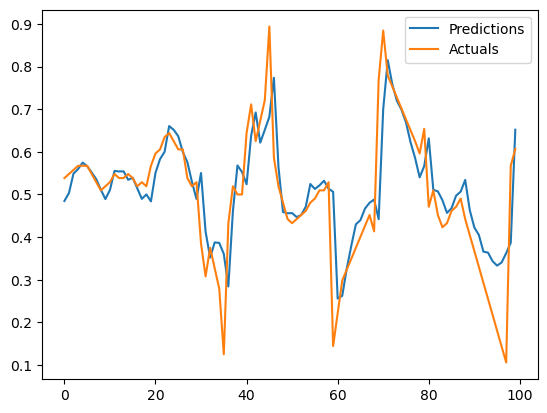

MSE for Predictions: 0.015607317551003587
MAE:  0.08875859
r_squared error:  0.7001824167508881
     Predictions   Actuals
350     0.728511  0.721154
351     0.677713  0.687500
352     0.631841  0.653846
353     0.625237  0.644231
354     0.618781  0.625000
355     0.587233  0.605769
356     0.564971  0.576923
357     0.543881  0.548077
358     0.518991  0.336538
359     0.378366  0.394231
360     0.379417  0.262821
361     0.325583  0.131410
362     0.218574  0.000000
363     0.124212  0.211538
364     0.204464  0.048077
365     0.191309  0.105769
366     0.242827  0.163462
367     0.318719  0.230769
368     0.392660  0.384615
369     0.481267  0.355769
370     0.474294  0.759615
371     0.697612  0.485577
372     0.563491  0.211538
373     0.296217  0.605769
374     0.506421  0.076923
375     0.262525  0.043269
376     0.206618  0.009615
377     0.236296  0.451923
378     0.522543  0.394231
379     0.554684  0.259615


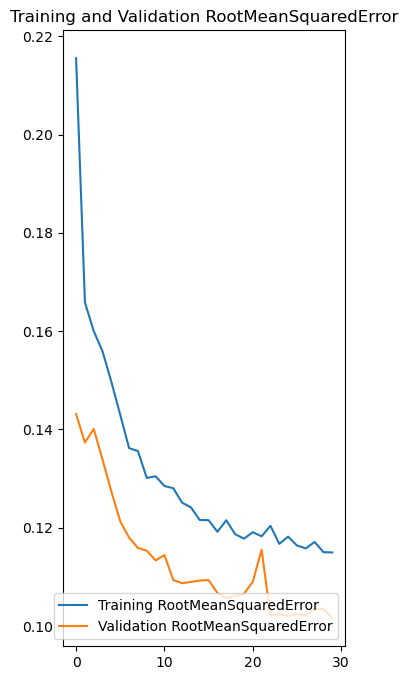

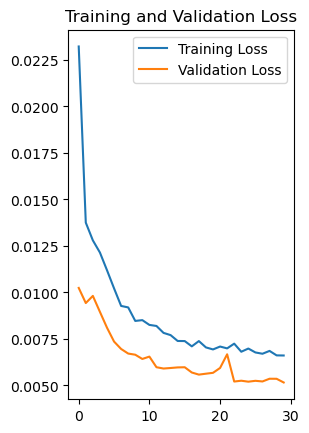

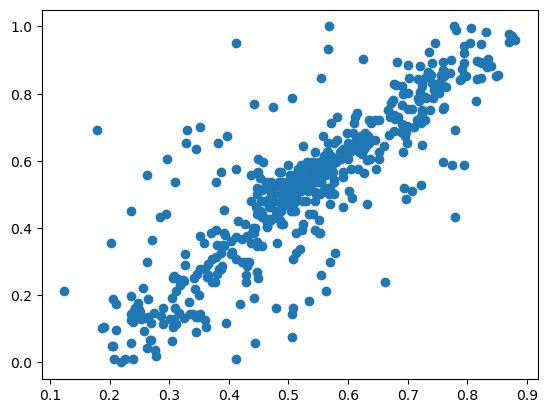

In [196]:


cp33_1 = ModelCheckpoint('models/model33_huber/', save_best_only=True)

model33.compile(loss=Huber(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(),'mse', 'mae'])
Model33 = model33.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, callbacks=[cp33_1])

Ypred33=model33.predict(X_test)
plot_predictions2(model33, X_test, Y_test)
pltGraph(Model33, 30)
plt.scatter(Ypred33, Y_test)

17/17 [==============================] - 0s 6ms/step


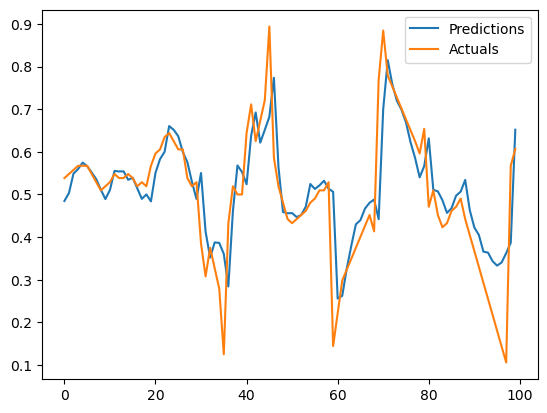

MSE for Predictions: 0.015607317551003587
MAE:  0.08875859
r_squared error:  0.7001824167508881
     Predictions   Actuals
58      0.513659  0.528846
59      0.506221  0.144231
60      0.255691  0.221154
61      0.262209  0.298077
62      0.326420  0.323718
63      0.380052  0.349359
64      0.429973  0.375000
65      0.439785  0.400641
66      0.466940  0.426282
67      0.480531  0.451923
68      0.488159  0.413462
69      0.442033  0.769231
70      0.700654  0.884615
71      0.814990  0.778846
72      0.758300  0.753205
73      0.719759  0.727564
74      0.699308  0.701923
75      0.668918  0.676282
76      0.622614  0.650641
77      0.585629  0.625000
78      0.540185  0.596154
79      0.566514  0.653846
80      0.631606  0.471154
81      0.510947  0.509615
82      0.507181  0.451923
83      0.486539  0.423077
84      0.456780  0.432692
85      0.467873  0.461538
86      0.497303  0.471154
87      0.506603  0.490385
88      0.534141  0.442308
89      0.463416  0.404915
90      0.422

In [210]:
Ypred33=model33.predict(X_test)
plot_predictions2(model33, X_test, Y_test)

In [121]:
model15 = Sequential()

model15.add(InputLayer((7, 14)))
# 1D CNN layers
model15.add(Conv1D(filters=128, kernel_size=3, activation='tanh', padding='same', input_shape=(7, 13)))
model15.add(LSTM(units=128, return_sequences=True))
model15.add(Conv1D(filters=64, kernel_size=3, activation='tanh', padding='same'))
model15.add(LSTM(units=64, return_sequences=True))

model15.add(LSTM(units=64, return_sequences=False))

# Reshape for 2D CNN layer
model15.add(Reshape((64, 1, 1)))  # reshape to (batch_size, 64, 1, 1)

# 2D CNN layers
model15.add(Conv2D(filters=32, kernel_size=(3, 3), activation='tanh', padding='same'))

model15.add(Conv2D(filters=64, kernel_size=(3, 3), activation='tanh', padding='same'))

model15.add(LSTM(units=64, return_sequences=False))
# Flatten layer
model15.add(Flatten())

# Output layer
model15.add(Dense(units=1, activation='linear'))

# Display model summary
model15.summary()


ValueError: Input 0 of layer "lstm_42" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 64, 1, 64)

In [ ]:
cp15_1 = ModelCheckpoint('models/model33_huber/', save_best_only=True)

model15.compile(loss=Huber(), optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError(),'mse', 'mae'])
Model15 = model15.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=30, callbacks=[cp15_1])

Ypred15=model15.predict(X_test)
plot_predictions2(model15, X_test, Y_test)
pltGraph(Model15, 30)
plt.scatter(Ypred15, Y_test)